<a href="https://colab.research.google.com/github/Harihara04sudhan/naan-mudhalvan/blob/main/IBM_NM_AV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Kaggle Package


In [ ]:
!pip install kaggle

## Uploaded the kaggle.json file from the local drive

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hari04sudhan","key":"ee10c40d15b3f8d1ff1c5bc269883274"}'}

## Creating a new kaggle foder

In [ ]:
! mkdir ~/.kaggle

## Copy uploaded kaggle.json file to craeted kaggle folder

In [ ]:
! cp kaggle.json ~/.kaggle/

## Permission for json file to act

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

# List the Datasets availble in Kaggle

In [ ]:
! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
girumwondemagegn/dataset-for-renewable-energy-systems               Dataset for renewable energy systems                853KB  2024-05-17 23:51:25            910         28  1.0              
zeesolver/spotfy                                                    Spotify Songs Album                                  47KB  2024-05-10 09:21:57           1065         22  1.0              
rahulvyasm/netflix-movies-and-tv-shows                              Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38          23964        512  1.0              
vladimirmijatovic/data-scientists-salari

## Import BadODD: Bangladeshi Autonomous Driving Object Detection Dataset

In [ ]:
! kaggle competitions download -c dl-enigma-10-sust-cse-carnival-2024

 99% 3.20G/3.23G [00:32<00:00, 136MB/s]
100% 3.23G/3.23G [00:32<00:00, 107MB/s]


## Unzipping the Dataset

In [ ]:
! unzip dl-enigma-10-sust-cse-carnival-2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5400.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5460.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5580.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5640.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5760.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5820.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5940.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6000.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6120.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6300.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6360.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6480.txt  
  inflating: dlenigma1/BadODD/labels/train/chuada

## Install pybboxes library

In [ ]:
! pip install pybboxes
! pip install pascal_voc_writer

## Importing necessary libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import cv2
from tqdm import tqdm
import pybboxes as pbx

import matplotlib.pyplot as plt
import colorsys

## create a dataframe from the input dataset



In [ ]:
with open(
    '/content/dlenigma1/BadODD/badodd.txt', 'r'
) as f:
    class_labels = [line.strip().replace('_', ' ') for line in f.readlines()]

class_label_map = {class_labels[i]: i for i in range(len(class_labels))}
class_label_map


{'auto rickshaw': 0,
 'bicycle': 1,
 'bus': 2,
 'car': 3,
 'cart vehicle': 4,
 'construction vehicle': 5,
 'motorbike': 6,
 'person': 7,
 'priority vehicle': 8,
 'three wheeler': 9,
 'train': 10,
 'truck': 11,
 'wheelchair': 12}

## Train the data

In [ ]:
def get_possible_box_format(bbox, input_shape=None):
    if input_shape is None:
        return None, None, None

    voc_bbox = pbx.convert_bbox(
        bbox, from_type="yolo", to_type="voc", image_size=input_shape
    )
    coco_bbox = pbx.convert_bbox(
        bbox, from_type="yolo", to_type="coco", image_size=input_shape
    )
    yolo_bbox = ', '.join(map(str, bbox))
    return ', '.join(map(str, voc_bbox)), ', '.join(map(str, coco_bbox)), yolo_bbox

def prepare_dataframe(image_dir, label_dir):
    data = []
    for image_file in tqdm(os.listdir(image_dir), desc='Processing images'):
        img_path = os.path.join(image_dir, image_file)
        print(f"Processing image: {img_path}")
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}. Skipping...")
            continue

        img_h, img_w = img.shape[:2]
        image_id = image_file.split('.')[0]
        label_file = os.path.join(label_dir, image_id + '.txt')

        if not os.path.exists(label_file):
            print(f"Label file not found for image: {image_file}. Skipping...")
            continue

        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_label, *bbox = map(float, line.strip().split())
                class_label = int(class_label)
                voc_bbox, coco_bbox, yolo_bbox = get_possible_box_format(
                    bbox, input_shape=(img_w, img_h)
                )
                if voc_bbox is None or coco_bbox is None or yolo_bbox is None:
                    print(f"Failed to get box format for image: {image_file}. Skipping...")
                    continue

                data.append({
                    'image_id': image_id,
                    'voc_bbox': voc_bbox,
                    'coco_bbox': coco_bbox,
                    'yolo_bbox': yolo_bbox,
                    'class_label': class_label,
                    'image_height': img_h,
                    'image_width': img_w,
                })

    df = pd.DataFrame(data)
    return df

# Example usage:
image_dir = '/content/dlenigma1/BadODD/images/train'
label_dir = '/content/dlenigma1/BadODD/labels/train'
train_df = prepare_dataframe(image_dir, label_dir)
print(train_df.head())


Processing images:   0%|          | 2/5896 [00:00<05:14, 18.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145457.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7511.jpg


Processing images:   0%|          | 10/5896 [00:00<03:21, 29.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_348.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15222.jpg


Processing images:   0%|          | 18/5896 [00:00<03:08, 31.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29677.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16860.jpg


Processing images:   0%|          | 26/5896 [00:00<03:10, 30.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28860.jpg


Processing images:   1%|          | 30/5896 [00:00<03:09, 30.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50267.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63961.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2773.jpg


Processing images:   1%|          | 39/5896 [00:01<02:55, 33.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16410.jpg


Processing images:   1%|          | 47/5896 [00:01<02:52, 33.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23718.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3507.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6330.jpg


Processing images:   1%|          | 55/5896 [00:01<03:03, 31.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_51094.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2242.jpg


Processing images:   1%|          | 59/5896 [00:01<03:01, 32.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43253.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3658.jpg


Processing images:   1%|          | 67/5896 [00:02<03:07, 31.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22879.jpg


Processing images:   1%|▏         | 75/5896 [00:02<03:03, 31.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50209.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1003.jpg


Processing images:   1%|▏         | 83/5896 [00:02<03:06, 31.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37347.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26580.jpg


Processing images:   1%|▏         | 87/5896 [00:02<02:59, 32.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100200.jpg


Processing images:   2%|▏         | 95/5896 [00:03<03:13, 29.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12213.jpg


Processing images:   2%|▏         | 104/5896 [00:03<03:01, 31.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6699.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6431.jpg


Processing images:   2%|▏         | 108/5896 [00:03<03:05, 31.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119572.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69305.jpg


Processing images:   2%|▏         | 116/5896 [00:03<03:00, 32.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31020.jpg


Processing images:   2%|▏         | 124/5896 [00:03<02:49, 34.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1440.jpg


Processing images:   2%|▏         | 132/5896 [00:04<03:06, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23069.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1680.jpg


Processing images:   2%|▏         | 141/5896 [00:04<02:49, 33.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5945.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36816.jpg


Processing images:   2%|▏         | 145/5896 [00:04<02:50, 33.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_8660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23187.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45925.jpg


Processing images:   3%|▎         | 153/5896 [00:04<02:48, 34.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2065.jpg


Processing images:   3%|▎         | 161/5896 [00:05<02:59, 31.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2871.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12154.jpg


Processing images:   3%|▎         | 169/5896 [00:05<02:54, 32.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1015.jpg


Processing images:   3%|▎         | 173/5896 [00:05<02:56, 32.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118904.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7830.jpg


Processing images:   3%|▎         | 181/5896 [00:05<02:59, 31.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111389.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1595.jpg


Processing images:   3%|▎         | 189/5896 [00:05<03:01, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_7348.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1947.jpg


Processing images:   3%|▎         | 198/5896 [00:06<02:52, 33.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101870.jpg


Processing images:   3%|▎         | 202/5896 [00:06<02:56, 32.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5336.jpg


Processing images:   4%|▎         | 210/5896 [00:06<03:01, 31.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21360.jpg


Processing images:   4%|▎         | 218/5896 [00:06<02:56, 32.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47428.jpg


Processing images:   4%|▍         | 226/5896 [00:07<02:52, 32.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25252.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2726.jpg


Processing images:   4%|▍         | 234/5896 [00:07<02:52, 32.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45607.jpg


Processing images:   4%|▍         | 238/5896 [00:07<02:54, 32.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156312.jpg


Processing images:   4%|▍         | 246/5896 [00:07<02:50, 33.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22833.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92184.jpg


Processing images:   4%|▍         | 254/5896 [00:07<02:56, 31.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4860.jpg


Processing images:   4%|▍         | 262/5896 [00:08<02:57, 31.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43955.jpg


Processing images:   5%|▍         | 270/5896 [00:08<03:00, 31.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8790.jpg


Processing images:   5%|▍         | 275/5896 [00:08<02:42, 34.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5280.jpg


Processing images:   5%|▍         | 283/5896 [00:08<02:50, 32.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134268.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_783.jpg


Processing images:   5%|▍         | 291/5896 [00:09<02:51, 32.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_28438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52864.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3422.jpg


Processing images:   5%|▌         | 299/5896 [00:09<02:55, 31.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48675.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44190.jpg


Processing images:   5%|▌         | 308/5896 [00:09<02:41, 34.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35636.jpg


Processing images:   5%|▌         | 312/5896 [00:09<02:57, 31.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17340.jpg


Processing images:   5%|▌         | 316/5896 [00:09<03:31, 26.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30149.jpg


Processing images:   5%|▌         | 322/5896 [00:10<04:15, 21.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23246.jpg


Processing images:   6%|▌         | 325/5896 [00:10<04:06, 22.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7670.jpg


Processing images:   6%|▌         | 331/5896 [00:10<04:39, 19.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3451.jpg


Processing images:   6%|▌         | 334/5896 [00:10<04:53, 18.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3364.jpg


Processing images:   6%|▌         | 340/5896 [00:11<04:30, 20.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12626.jpg


Processing images:   6%|▌         | 346/5896 [00:11<04:15, 21.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35571.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2871.jpg


Processing images:   6%|▌         | 349/5896 [00:11<04:31, 20.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97361.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140781.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37760.jpg


Processing images:   6%|▌         | 355/5896 [00:11<04:18, 21.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5684.jpg


Processing images:   6%|▌         | 361/5896 [00:12<04:27, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_108049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5015.jpg


Processing images:   6%|▌         | 364/5896 [00:12<04:42, 19.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1421.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7424.jpg


Processing images:   6%|▋         | 369/5896 [00:12<04:57, 18.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_0.jpg


Processing images:   6%|▋         | 373/5896 [00:12<04:59, 18.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42126.jpg


Processing images:   6%|▋         | 379/5896 [00:13<04:04, 22.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13026.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_64517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11220.jpg


Processing images:   7%|▋         | 387/5896 [00:13<03:10, 28.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61289.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1160.jpg


Processing images:   7%|▋         | 394/5896 [00:13<03:07, 29.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10384.jpg


Processing images:   7%|▋         | 402/5896 [00:13<02:50, 32.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11151.jpg


Processing images:   7%|▋         | 406/5896 [00:13<02:59, 30.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2523.jpg


Processing images:   7%|▋         | 415/5896 [00:14<02:44, 33.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19830.jpg


Processing images:   7%|▋         | 423/5896 [00:14<02:49, 32.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17818.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69472.jpg


Processing images:   7%|▋         | 427/5896 [00:14<02:52, 31.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23482.jpg


Processing images:   7%|▋         | 435/5896 [00:14<02:52, 31.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3599.jpg


Processing images:   8%|▊         | 443/5896 [00:15<02:53, 31.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31506.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3660.jpg


Processing images:   8%|▊         | 451/5896 [00:15<02:54, 31.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_22516.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68971.jpg


Processing images:   8%|▊         | 455/5896 [00:15<03:03, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11022.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7743.jpg


Processing images:   8%|▊         | 462/5896 [00:15<02:54, 31.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96693.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3683.jpg


Processing images:   8%|▊         | 470/5896 [00:15<02:45, 32.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_531.jpg


Processing images:   8%|▊         | 478/5896 [00:16<02:53, 31.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140614.jpg


Processing images:   8%|▊         | 482/5896 [00:16<02:52, 31.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155978.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_126252.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17460.jpg


Processing images:   8%|▊         | 490/5896 [00:16<02:48, 32.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19440.jpg


Processing images:   8%|▊         | 498/5896 [00:16<02:42, 33.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28143.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6000.jpg


Processing images:   9%|▊         | 506/5896 [00:17<02:50, 31.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42834.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_28578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9322.jpg


Processing images:   9%|▊         | 510/5896 [00:17<02:55, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21720.jpg


Processing images:   9%|▉         | 518/5896 [00:17<02:46, 32.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1503.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1357.jpg


Processing images:   9%|▉         | 526/5896 [00:17<02:52, 31.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34633.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26386.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7847.jpg


Processing images:   9%|▉         | 530/5896 [00:17<02:55, 30.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7221.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_295.jpg


Processing images:   9%|▉         | 538/5896 [00:18<02:55, 30.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18270.jpg


Processing images:   9%|▉         | 546/5896 [00:18<02:44, 32.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125417.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4008.jpg


Processing images:   9%|▉         | 550/5896 [00:18<02:55, 30.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25311.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26904.jpg


Processing images:   9%|▉         | 558/5896 [00:18<02:52, 30.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1044.jpg


Processing images:  10%|▉         | 566/5896 [00:18<02:51, 31.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22080.jpg


Processing images:  10%|▉         | 570/5896 [00:19<02:52, 30.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64963.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24662.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5365.jpg


Processing images:  10%|▉         | 578/5896 [00:19<02:54, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27081.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3658.jpg


Processing images:  10%|▉         | 586/5896 [00:19<02:54, 30.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_32042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11505.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41359.jpg


Processing images:  10%|█         | 594/5896 [00:19<02:43, 32.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28740.jpg


Processing images:  10%|█         | 598/5896 [00:20<02:45, 32.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149966.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41477.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70641.jpg


Processing images:  10%|█         | 606/5896 [00:20<02:40, 33.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19883.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30208.jpg


Processing images:  10%|█         | 614/5896 [00:20<02:44, 32.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8787.jpg


Processing images:  10%|█         | 618/5896 [00:20<02:40, 32.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_19052.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1276.jpg


Processing images:  11%|█         | 626/5896 [00:20<02:44, 32.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8845.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70808.jpg


Processing images:  11%|█         | 634/5896 [00:21<02:43, 32.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19680.jpg


Processing images:  11%|█         | 642/5896 [00:21<02:40, 32.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44309.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_8851.jpg


Processing images:  11%|█         | 650/5896 [00:21<02:40, 32.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55342.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1972.jpg


Processing images:  11%|█         | 654/5896 [00:21<02:49, 30.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_45898.jpg


Processing images:  11%|█         | 662/5896 [00:21<02:41, 32.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30227.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_826.jpg


Processing images:  11%|█▏        | 670/5896 [00:22<02:48, 31.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26940.jpg


Processing images:  11%|█▏        | 678/5896 [00:22<02:40, 32.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20430.jpg


Processing images:  12%|█▏        | 682/5896 [00:22<02:46, 31.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_42001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41713.jpg


Processing images:  12%|█▏        | 690/5896 [00:22<02:42, 31.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3186.jpg


Processing images:  12%|█▏        | 694/5896 [00:23<03:15, 26.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51507.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33984.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16560.jpg


Processing images:  12%|█▏        | 700/5896 [00:23<03:43, 23.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2220.jpg


Processing images:  12%|█▏        | 703/5896 [00:23<03:53, 22.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54776.jpg


Processing images:  12%|█▏        | 709/5896 [00:23<04:12, 20.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33984.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37937.jpg


Processing images:  12%|█▏        | 712/5896 [00:24<04:10, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8265.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9360.jpg


Processing images:  12%|█▏        | 718/5896 [00:24<04:20, 19.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51979.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30780.jpg


Processing images:  12%|█▏        | 721/5896 [00:24<04:26, 19.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86005.jpg


Processing images:  12%|█▏        | 726/5896 [00:24<04:23, 19.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26255.jpg


Processing images:  12%|█▏        | 730/5896 [00:24<04:34, 18.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7670.jpg


Processing images:  12%|█▎        | 737/5896 [00:25<03:54, 22.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44191.jpg


Processing images:  13%|█▎        | 740/5896 [00:25<03:56, 21.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38586.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8207.jpg


Processing images:  13%|█▎        | 746/5896 [00:25<04:24, 19.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36934.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4530.jpg


Processing images:  13%|█▎        | 749/5896 [00:25<04:07, 20.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6136.jpg


Processing images:  13%|█▎        | 755/5896 [00:26<04:13, 20.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44427.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10089.jpg


Processing images:  13%|█▎        | 761/5896 [00:26<03:47, 22.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6699.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46846.jpg


Processing images:  13%|█▎        | 768/5896 [00:26<03:12, 26.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50268.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50563.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19980.jpg


Processing images:  13%|█▎        | 776/5896 [00:26<02:46, 30.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9810.jpg


Processing images:  13%|█▎        | 781/5896 [00:26<02:30, 34.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40533.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49855.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22380.jpg


Processing images:  13%|█▎        | 789/5896 [00:27<02:25, 35.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98029.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18871.jpg


Processing images:  14%|█▎        | 797/5896 [00:27<02:36, 32.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152805.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15281.jpg


Processing images:  14%|█▎        | 805/5896 [00:27<02:37, 32.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_6062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25800.jpg


Processing images:  14%|█▍        | 813/5896 [00:27<02:40, 31.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33099.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1680.jpg


Processing images:  14%|█▍        | 817/5896 [00:28<02:38, 32.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17051.jpg


Processing images:  14%|█▍        | 825/5896 [00:28<02:39, 31.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26100.jpg


Processing images:  14%|█▍        | 833/5896 [00:28<02:42, 31.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_180.jpg


Processing images:  14%|█▍        | 838/5896 [00:28<02:27, 34.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148463.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6726.jpg


Processing images:  14%|█▍        | 846/5896 [00:28<02:32, 33.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_780.jpg


Processing images:  14%|█▍        | 854/5896 [00:29<02:42, 30.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3683.jpg


Processing images:  15%|█▍        | 858/5896 [00:29<02:41, 31.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_38970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3060.jpg


Processing images:  15%|█▍        | 866/5896 [00:29<02:44, 30.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2301.jpg


Processing images:  15%|█▍        | 874/5896 [00:29<02:43, 30.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49501.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42008.jpg


Processing images:  15%|█▍        | 882/5896 [00:30<02:45, 30.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3161.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1380.jpg


Processing images:  15%|█▌        | 886/5896 [00:30<02:37, 31.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_62785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3009.jpg


Processing images:  15%|█▌        | 894/5896 [00:30<02:37, 31.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43920.jpg


Processing images:  15%|█▌        | 902/5896 [00:30<02:31, 32.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22243.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146960.jpg


Processing images:  15%|█▌        | 910/5896 [00:31<02:34, 32.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37465.jpg


Processing images:  16%|█▌        | 914/5896 [00:31<02:41, 30.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52038.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31440.jpg


Processing images:  16%|█▌        | 923/5896 [00:31<02:24, 34.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1652.jpg


Processing images:  16%|█▌        | 931/5896 [00:31<02:27, 33.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7482.jpg


Processing images:  16%|█▌        | 939/5896 [00:31<02:31, 32.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14640.jpg


Processing images:  16%|█▌        | 947/5896 [00:32<02:23, 34.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28792.jpg


Processing images:  16%|█▌        | 955/5896 [00:32<02:25, 33.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_767.jpg


Processing images:  16%|█▋        | 959/5896 [00:32<02:35, 31.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75317.jpg


Processing images:  16%|█▋        | 967/5896 [00:32<02:34, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23777.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19647.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39746.jpg


Processing images:  17%|█▋        | 976/5896 [00:32<02:18, 35.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57281.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6254.jpg


Processing images:  17%|█▋        | 984/5896 [00:33<02:24, 33.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20532.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22440.jpg


Processing images:  17%|█▋        | 988/5896 [00:33<02:25, 33.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12090.jpg


Processing images:  17%|█▋        | 997/5896 [00:33<02:16, 35.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138109.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2773.jpg


Processing images:  17%|█▋        | 1005/5896 [00:33<02:25, 33.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13320.jpg


Processing images:  17%|█▋        | 1009/5896 [00:33<02:23, 33.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6409.jpg


Processing images:  17%|█▋        | 1017/5896 [00:34<02:28, 32.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5192.jpg


Processing images:  17%|█▋        | 1025/5896 [00:34<02:34, 31.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37819.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11580.jpg


Processing images:  17%|█▋        | 1029/5896 [00:34<02:33, 31.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101035.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17464.jpg


Processing images:  18%|█▊        | 1037/5896 [00:34<02:41, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_133099.jpg


Processing images:  18%|█▊        | 1041/5896 [00:35<02:46, 29.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6195.jpg


Processing images:  18%|█▊        | 1049/5896 [00:35<02:32, 31.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10915.jpg


Processing images:  18%|█▊        | 1057/5896 [00:35<02:33, 31.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15281.jpg


Processing images:  18%|█▊        | 1061/5896 [00:35<02:30, 32.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6630.jpg


Processing images:  18%|█▊        | 1069/5896 [00:35<02:34, 31.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3245.jpg


Processing images:  18%|█▊        | 1077/5896 [00:36<02:34, 31.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5546.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28202.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6240.jpg


Processing images:  18%|█▊        | 1081/5896 [00:36<02:40, 29.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13560.jpg


Processing images:  18%|█▊        | 1085/5896 [00:36<02:57, 27.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5841.jpg


Processing images:  19%|█▊        | 1091/5896 [00:36<03:26, 23.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54988.jpg


Processing images:  19%|█▊        | 1097/5896 [00:37<03:22, 23.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1947.jpg


Processing images:  19%|█▊        | 1100/5896 [00:37<03:43, 21.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46787.jpg


Processing images:  19%|█▊        | 1103/5896 [00:37<03:51, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1357.jpg


Processing images:  19%|█▉        | 1109/5896 [00:37<04:01, 19.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_61486.jpg


Processing images:  19%|█▉        | 1114/5896 [00:37<04:05, 19.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3127.jpg


Processing images:  19%|█▉        | 1117/5896 [00:38<03:59, 19.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26904.jpg


Processing images:  19%|█▉        | 1123/5896 [00:38<04:02, 19.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1980.jpg


Processing images:  19%|█▉        | 1127/5896 [00:38<04:14, 18.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24131.jpg


Processing images:  19%|█▉        | 1132/5896 [00:38<03:56, 20.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49737.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2958.jpg


Processing images:  19%|█▉        | 1135/5896 [00:39<03:58, 20.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_330.jpg


Processing images:  19%|█▉        | 1141/5896 [00:39<03:58, 19.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18990.jpg


Processing images:  19%|█▉        | 1144/5896 [00:39<03:57, 19.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8909.jpg


Processing images:  20%|█▉        | 1150/5896 [00:39<03:50, 20.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32686.jpg


Processing images:  20%|█▉        | 1158/5896 [00:40<02:52, 27.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12626.jpg


Processing images:  20%|█▉        | 1161/5896 [00:40<02:53, 27.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147795.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13080.jpg


Processing images:  20%|█▉        | 1171/5896 [00:40<02:46, 28.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9106.jpg


Processing images:  20%|█▉        | 1175/5896 [00:40<02:40, 29.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27317.jpg


Processing images:  20%|██        | 1183/5896 [00:40<02:29, 31.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_295.jpg


Processing images:  20%|██        | 1191/5896 [00:41<02:23, 32.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30267.jpg


Processing images:  20%|██        | 1200/5896 [00:41<02:07, 36.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136940.jpg


Processing images:  20%|██        | 1208/5896 [00:41<02:12, 35.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6960.jpg


Processing images:  21%|██        | 1212/5896 [00:41<02:24, 32.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6873.jpg


Processing images:  21%|██        | 1220/5896 [00:41<02:26, 31.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52333.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4543.jpg


Processing images:  21%|██        | 1228/5896 [00:42<02:24, 32.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10325.jpg


Processing images:  21%|██        | 1237/5896 [00:42<02:15, 34.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25429.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_334.jpg


Processing images:  21%|██        | 1245/5896 [00:42<02:20, 33.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6120.jpg


Processing images:  21%|██        | 1249/5896 [00:42<02:22, 32.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22892.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44486.jpg


Processing images:  21%|██▏       | 1257/5896 [00:43<02:27, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36072.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19352.jpg


Processing images:  21%|██▏       | 1265/5896 [00:43<02:17, 33.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32391.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_531.jpg


Processing images:  22%|██▏       | 1273/5896 [00:43<02:26, 31.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_600.jpg


Processing images:  22%|██▏       | 1277/5896 [00:43<02:22, 32.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2146.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112224.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37170.jpg


Processing images:  22%|██▏       | 1285/5896 [00:43<02:20, 32.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32155.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1888.jpg


Processing images:  22%|██▏       | 1293/5896 [00:44<02:21, 32.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143286.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_348.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47762.jpg


Processing images:  22%|██▏       | 1301/5896 [00:44<02:22, 32.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2655.jpg


Processing images:  22%|██▏       | 1309/5896 [00:44<02:20, 32.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52156.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30503.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5075.jpg


Processing images:  22%|██▏       | 1317/5896 [00:44<02:29, 30.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10030.jpg


Processing images:  22%|██▏       | 1321/5896 [00:45<02:33, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53941.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13861.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10020.jpg


Processing images:  23%|██▎       | 1328/5896 [00:45<02:22, 32.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43542.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_23815.jpg


Processing images:  23%|██▎       | 1332/5896 [00:45<02:32, 29.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9853.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3900.jpg


Processing images:  23%|██▎       | 1340/5896 [00:45<02:34, 29.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42716.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12626.jpg


Processing images:  23%|██▎       | 1348/5896 [00:45<02:30, 30.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2130.jpg


Processing images:  23%|██▎       | 1356/5896 [00:46<02:17, 32.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52628.jpg


Processing images:  23%|██▎       | 1360/5896 [00:46<02:24, 31.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148964.jpg


Processing images:  23%|██▎       | 1368/5896 [00:46<02:24, 31.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_15588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46964.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7163.jpg


Processing images:  23%|██▎       | 1376/5896 [00:46<02:23, 31.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22230.jpg


Processing images:  23%|██▎       | 1380/5896 [00:46<02:16, 33.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148129.jpg


Processing images:  24%|██▎       | 1388/5896 [00:47<02:22, 31.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3540.jpg


Processing images:  24%|██▎       | 1397/5896 [00:47<02:14, 33.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7434.jpg


Processing images:  24%|██▍       | 1401/5896 [00:47<02:15, 33.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75651.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1888.jpg


Processing images:  24%|██▍       | 1409/5896 [00:47<02:22, 31.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56279.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6726.jpg


Processing images:  24%|██▍       | 1417/5896 [00:48<02:13, 33.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16992.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_40269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120908.jpg


Processing images:  24%|██▍       | 1425/5896 [00:48<02:13, 33.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22260.jpg


Processing images:  24%|██▍       | 1433/5896 [00:48<02:20, 31.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51603.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13590.jpg

Processing images:  24%|██▍       | 1437/5896 [00:48<02:17, 32.54it/s]


Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6931.jpg


Processing images:  25%|██▍       | 1445/5896 [00:48<02:17, 32.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2755.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9480.jpg


Processing images:  25%|██▍       | 1454/5896 [00:49<02:02, 36.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15060.jpg


Processing images:  25%|██▍       | 1462/5896 [00:49<02:06, 35.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31919.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2714.jpg


Processing images:  25%|██▍       | 1466/5896 [00:49<02:19, 31.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55401.jpg


Processing images:  25%|██▌       | 1474/5896 [00:49<02:26, 30.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4307.jpg


Processing images:  25%|██▌       | 1478/5896 [00:50<02:44, 26.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38645.jpg


Processing images:  25%|██▌       | 1484/5896 [00:50<03:09, 23.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18810.jpg


Processing images:  25%|██▌       | 1487/5896 [00:50<03:32, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34402.jpg


Processing images:  25%|██▌       | 1490/5896 [00:50<03:42, 19.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16225.jpg


Processing images:  25%|██▌       | 1496/5896 [00:51<03:32, 20.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137441.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19234.jpg


Processing images:  25%|██▌       | 1499/5896 [00:51<03:37, 20.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48026.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25783.jpg


Processing images:  26%|██▌       | 1505/5896 [00:51<03:37, 20.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3658.jpg


Processing images:  26%|██▌       | 1508/5896 [00:51<03:39, 19.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157982.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7801.jpg


Processing images:  26%|██▌       | 1514/5896 [00:51<03:34, 20.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_261.jpg


Processing images:  26%|██▌       | 1517/5896 [00:52<03:43, 19.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4897.jpg


Processing images:  26%|██▌       | 1522/5896 [00:52<03:47, 19.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3599.jpg


Processing images:  26%|██▌       | 1526/5896 [00:52<03:57, 18.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71476.jpg


Processing images:  26%|██▌       | 1531/5896 [00:52<03:58, 18.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6903.jpg


Processing images:  26%|██▌       | 1536/5896 [00:53<03:40, 19.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41654.jpg


Processing images:  26%|██▌       | 1542/5896 [00:53<03:19, 21.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6077.jpg


Processing images:  26%|██▋       | 1550/5896 [00:53<02:37, 27.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_32732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_26413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39471.jpg


Processing images:  26%|██▋       | 1557/5896 [00:53<02:30, 28.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36360.jpg


Processing images:  27%|██▋       | 1565/5896 [00:54<02:21, 30.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1479.jpg


Processing images:  27%|██▋       | 1573/5896 [00:54<02:13, 32.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18231.jpg


Processing images:  27%|██▋       | 1577/5896 [00:54<02:13, 32.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16343.jpg


Processing images:  27%|██▋       | 1585/5896 [00:54<02:19, 31.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13983.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46728.jpg


Processing images:  27%|██▋       | 1593/5896 [00:54<02:17, 31.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2204.jpg


Processing images:  27%|██▋       | 1601/5896 [00:55<02:07, 33.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28020.jpg


Processing images:  27%|██▋       | 1609/5896 [00:55<02:04, 34.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36639.jpg


Processing images:  27%|██▋       | 1617/5896 [00:55<02:00, 35.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1080.jpg


Processing images:  27%|██▋       | 1621/5896 [00:55<02:01, 35.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18203.jpg


Processing images:  28%|██▊       | 1629/5896 [00:55<02:09, 32.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32332.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3270.jpg


Processing images:  28%|██▊       | 1638/5896 [00:56<02:02, 34.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna3_87.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_39836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46846.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9971.jpg


Processing images:  28%|██▊       | 1646/5896 [00:56<02:08, 33.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4920.jpg


Processing images:  28%|██▊       | 1650/5896 [00:56<02:14, 31.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44663.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10915.jpg


Processing images:  28%|██▊       | 1658/5896 [00:56<02:13, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57112.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4060.jpg


Processing images:  28%|██▊       | 1666/5896 [00:57<02:10, 32.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4307.jpg


Processing images:  28%|██▊       | 1674/5896 [00:57<02:13, 31.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1180.jpg


Processing images:  29%|██▊       | 1682/5896 [00:57<02:07, 32.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20473.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1003.jpg


Processing images:  29%|██▊       | 1690/5896 [00:57<02:04, 33.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24662.jpg


Processing images:  29%|██▊       | 1694/5896 [00:57<02:10, 32.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8961.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19410.jpg


Processing images:  29%|██▉       | 1702/5896 [00:58<02:11, 32.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22892.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1829.jpg


Processing images:  29%|██▉       | 1710/5896 [00:58<02:14, 31.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4248.jpg


Processing images:  29%|██▉       | 1718/5896 [00:58<02:11, 31.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18113.jpg


Processing images:  29%|██▉       | 1722/5896 [00:58<02:16, 30.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_11258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4175.jpg


Processing images:  29%|██▉       | 1730/5896 [00:59<02:15, 30.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92518.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43837.jpg


Processing images:  29%|██▉       | 1738/5896 [00:59<02:11, 31.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_30.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5959.jpg


Processing images:  30%|██▉       | 1746/5896 [00:59<02:05, 33.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_34640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41880.jpg


Processing images:  30%|██▉       | 1750/5896 [00:59<02:03, 33.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2940.jpg


Processing images:  30%|██▉       | 1758/5896 [00:59<02:10, 31.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_13423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49265.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26220.jpg


Processing images:  30%|██▉       | 1766/5896 [01:00<02:11, 31.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18998.jpg


Processing images:  30%|███       | 1770/5896 [01:00<02:12, 31.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24030.jpg


Processing images:  30%|███       | 1778/5896 [01:00<02:14, 30.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22211.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_48496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23460.jpg


Processing images:  30%|███       | 1786/5896 [01:00<02:13, 30.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28556.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23610.jpg


Processing images:  30%|███       | 1790/5896 [01:01<02:06, 32.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3068.jpg


Processing images:  30%|███       | 1798/5896 [01:01<02:09, 31.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23777.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12685.jpg


Processing images:  31%|███       | 1806/5896 [01:01<02:12, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42244.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26373.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20880.jpg


Processing images:  31%|███       | 1814/5896 [01:01<02:13, 30.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80327.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107381.jpg


Processing images:  31%|███       | 1818/5896 [01:01<02:17, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16170.jpg


Processing images:  31%|███       | 1826/5896 [01:02<02:09, 31.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_3031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3780.jpg


Processing images:  31%|███       | 1834/5896 [01:02<02:13, 30.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43587.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43365.jpg


Processing images:  31%|███       | 1838/5896 [01:02<02:15, 29.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47318.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40297.jpg


Processing images:  31%|███▏      | 1845/5896 [01:02<02:18, 29.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20430.jpg


Processing images:  31%|███▏      | 1853/5896 [01:03<02:12, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38763.jpg


Processing images:  32%|███▏      | 1861/5896 [01:03<02:10, 30.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31200.jpg


Processing images:  32%|███▏      | 1865/5896 [01:03<02:34, 26.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16800.jpg


Processing images:  32%|███▏      | 1871/5896 [01:03<02:50, 23.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3306.jpg


Processing images:  32%|███▏      | 1874/5896 [01:03<02:57, 22.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45758.jpg


Processing images:  32%|███▏      | 1880/5896 [01:04<03:14, 20.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_261.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10440.jpg


Processing images:  32%|███▏      | 1883/5896 [01:04<03:11, 20.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30960.jpg


Processing images:  32%|███▏      | 1889/5896 [01:04<03:24, 19.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53454.jpg


Processing images:  32%|███▏      | 1893/5896 [01:04<03:30, 19.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10855.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3068.jpg


Processing images:  32%|███▏      | 1897/5896 [01:05<03:36, 18.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19140.jpg


Processing images:  32%|███▏      | 1901/5896 [01:05<03:38, 18.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35518.jpg


Processing images:  32%|███▏      | 1905/5896 [01:05<03:41, 17.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17582.jpg


Processing images:  32%|███▏      | 1909/5896 [01:05<03:50, 17.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5160.jpg


Processing images:  32%|███▏      | 1914/5896 [01:06<03:29, 19.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47259.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17405.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_5678.jpg


Processing images:  33%|███▎      | 1919/5896 [01:06<03:26, 19.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26137.jpg


Processing images:  33%|███▎      | 1923/5896 [01:06<03:33, 18.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1914.jpg


Processing images:  33%|███▎      | 1927/5896 [01:06<03:39, 18.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4248.jpg


Processing images:  33%|███▎      | 1933/5896 [01:07<02:51, 23.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_24681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10738.jpg


Processing images:  33%|███▎      | 1939/5896 [01:07<02:35, 25.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5546.jpg


Processing images:  33%|███▎      | 1943/5896 [01:07<02:24, 27.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48439.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20280.jpg


Processing images:  33%|███▎      | 1951/5896 [01:07<02:09, 30.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13098.jpg


Processing images:  33%|███▎      | 1959/5896 [01:07<02:04, 31.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21358.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19116.jpg


Processing images:  33%|███▎      | 1967/5896 [01:08<02:00, 32.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1740.jpg


Processing images:  33%|███▎      | 1975/5896 [01:08<02:06, 31.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19830.jpg


Processing images:  34%|███▎      | 1979/5896 [01:08<02:05, 31.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9000.jpg


Processing images:  34%|███▎      | 1987/5896 [01:08<02:07, 30.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95023.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42716.jpg


Processing images:  34%|███▍      | 1991/5896 [01:08<02:04, 31.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82331.jpg


Processing images:  34%|███▍      | 1999/5896 [01:09<02:03, 31.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11741.jpg


Processing images:  34%|███▍      | 2007/5896 [01:09<02:05, 31.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52274.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26491.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17280.jpg


Processing images:  34%|███▍      | 2015/5896 [01:09<02:03, 31.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117401.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19890.jpg


Processing images:  34%|███▍      | 2019/5896 [01:09<02:05, 30.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71309.jpg


Processing images:  34%|███▍      | 2029/5896 [01:10<01:53, 33.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56876.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2639.jpg


Processing images:  35%|███▍      | 2037/5896 [01:10<02:01, 31.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5074.jpg


Processing images:  35%|███▍      | 2045/5896 [01:10<01:56, 32.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30798.jpg


Processing images:  35%|███▍      | 2049/5896 [01:10<02:03, 31.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75985.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119405.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2183.jpg


Processing images:  35%|███▍      | 2057/5896 [01:11<02:09, 29.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104542.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8260.jpg


Processing images:  35%|███▌      | 2065/5896 [01:11<01:57, 32.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19350.jpg


Processing images:  35%|███▌      | 2069/5896 [01:11<01:59, 32.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5520.jpg


Processing images:  35%|███▌      | 2077/5896 [01:11<02:01, 31.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41064.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6750.jpg


Processing images:  35%|███▌      | 2085/5896 [01:11<02:01, 31.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58951.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5481.jpg


Processing images:  35%|███▌      | 2089/5896 [01:12<02:00, 31.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128423.jpg


Processing images:  36%|███▌      | 2097/5896 [01:12<02:04, 30.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43837.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20768.jpg


Processing images:  36%|███▌      | 2105/5896 [01:12<02:05, 30.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28851.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_53259.jpg


Processing images:  36%|███▌      | 2113/5896 [01:12<02:06, 29.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22656.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3799.jpg


Processing images:  36%|███▌      | 2117/5896 [01:12<02:02, 30.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49796.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17523.jpg


Processing images:  36%|███▌      | 2125/5896 [01:13<02:00, 31.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22560.jpg


Processing images:  36%|███▌      | 2133/5896 [01:13<02:02, 30.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5900.jpg


Processing images:  36%|███▋      | 2141/5896 [01:13<01:56, 32.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67802.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13860.jpg


Processing images:  36%|███▋      | 2145/5896 [01:13<01:59, 31.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4680.jpg


Processing images:  37%|███▋      | 2153/5896 [01:14<01:58, 31.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7375.jpg


Processing images:  37%|███▋      | 2161/5896 [01:14<01:55, 32.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_2171.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8319.jpg


Processing images:  37%|███▋      | 2169/5896 [01:14<02:01, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18644.jpg


Processing images:  37%|███▋      | 2173/5896 [01:14<02:05, 29.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104876.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22715.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1062.jpg


Processing images:  37%|███▋      | 2181/5896 [01:15<02:00, 30.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12095.jpg


Processing images:  37%|███▋      | 2189/5896 [01:15<01:56, 31.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna8_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29520.jpg


Processing images:  37%|███▋      | 2197/5896 [01:15<01:55, 32.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13080.jpg


Processing images:  37%|███▋      | 2201/5896 [01:15<01:58, 31.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_7515.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4380.jpg


Processing images:  37%|███▋      | 2209/5896 [01:15<02:00, 30.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51743.jpg


Processing images:  38%|███▊      | 2217/5896 [01:16<02:02, 29.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_6495.jpg


Processing images:  38%|███▊      | 2221/5896 [01:16<01:59, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22361.jpg


Processing images:  38%|███▊      | 2228/5896 [01:16<02:08, 28.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48085.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36757.jpg


Processing images:  38%|███▊      | 2234/5896 [01:16<02:12, 27.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93687.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23128.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15780.jpg


Processing images:  38%|███▊      | 2242/5896 [01:17<02:13, 27.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57289.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_7794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47318.jpg


Processing images:  38%|███▊      | 2245/5896 [01:17<02:14, 27.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_480.jpg


Processing images:  38%|███▊      | 2251/5896 [01:17<02:36, 23.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45666.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2065.jpg


Processing images:  38%|███▊      | 2254/5896 [01:17<02:48, 21.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2537.jpg


Processing images:  38%|███▊      | 2260/5896 [01:17<02:58, 20.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13230.jpg


Processing images:  38%|███▊      | 2266/5896 [01:18<02:51, 21.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129759.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_16454.jpg


Processing images:  38%|███▊      | 2269/5896 [01:18<03:02, 19.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4640.jpg


Processing images:  39%|███▊      | 2274/5896 [01:18<03:10, 19.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106212.jpg


Processing images:  39%|███▊      | 2279/5896 [01:18<02:57, 20.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11505.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58764.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17160.jpg


Processing images:  39%|███▊      | 2282/5896 [01:19<03:02, 19.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8207.jpg

Processing images:  39%|███▉      | 2287/5896 [01:19<03:07, 19.29it/s]


Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5369.jpg


Processing images:  39%|███▉      | 2291/5896 [01:19<03:10, 18.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7316.jpg


Processing images:  39%|███▉      | 2295/5896 [01:19<03:17, 18.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45489.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1247.jpg


Processing images:  39%|███▉      | 2300/5896 [01:20<03:04, 19.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2596.jpg


Processing images:  39%|███▉      | 2305/5896 [01:20<03:02, 19.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47554.jpg


Processing images:  39%|███▉      | 2307/5896 [01:20<03:09, 18.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_899.jpg


Processing images:  39%|███▉      | 2313/5896 [01:20<02:49, 21.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20237.jpg


Processing images:  39%|███▉      | 2322/5896 [01:20<02:03, 28.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7200.jpg


Processing images:  40%|███▉      | 2330/5896 [01:21<01:52, 31.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8671.jpg


Processing images:  40%|███▉      | 2334/5896 [01:21<01:57, 30.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16860.jpg


Processing images:  40%|███▉      | 2342/5896 [01:21<01:57, 30.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11970.jpg


Processing images:  40%|███▉      | 2350/5896 [01:21<01:57, 30.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20532.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_62458.jpg


Processing images:  40%|███▉      | 2354/5896 [01:21<01:56, 30.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10974.jpg


Processing images:  40%|████      | 2362/5896 [01:22<01:51, 31.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4012.jpg


Processing images:  40%|████      | 2370/5896 [01:22<01:45, 33.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150634.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2726.jpg


Processing images:  40%|████      | 2378/5896 [01:22<01:47, 32.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77154.jpg


Processing images:  40%|████      | 2382/5896 [01:22<01:54, 30.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2146.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11092.jpg


Processing images:  41%|████      | 2390/5896 [01:23<01:59, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4698.jpg


Processing images:  41%|████      | 2397/5896 [01:23<01:57, 29.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40748.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9450.jpg


Processing images:  41%|████      | 2401/5896 [01:23<01:52, 31.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_4330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3600.jpg


Processing images:  41%|████      | 2409/5896 [01:23<01:49, 31.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47141.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2714.jpg


Processing images:  41%|████      | 2417/5896 [01:24<01:55, 29.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129091.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45312.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8850.jpg


Processing images:  41%|████      | 2425/5896 [01:24<01:49, 31.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_0.jpg


Processing images:  41%|████      | 2429/5896 [01:24<01:50, 31.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1050.jpg


Processing images:  41%|████▏     | 2437/5896 [01:24<01:47, 32.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26963.jpg


Processing images:  41%|████▏     | 2445/5896 [01:24<01:50, 31.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42952.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_22949.jpg


Processing images:  42%|████▏     | 2453/5896 [01:25<01:48, 31.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2059.jpg


Processing images:  42%|████▏     | 2461/5896 [01:25<01:44, 32.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27081.jpg


Processing images:  42%|████▏     | 2465/5896 [01:25<01:43, 33.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14190.jpg


Processing images:  42%|████▏     | 2473/5896 [01:25<01:43, 33.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20945.jpg


Processing images:  42%|████▏     | 2481/5896 [01:25<01:44, 32.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37950.jpg


Processing images:  42%|████▏     | 2489/5896 [01:26<01:45, 32.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21181.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16560.jpg


Processing images:  42%|████▏     | 2493/5896 [01:26<01:46, 32.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31388.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28084.jpg


Processing images:  42%|████▏     | 2501/5896 [01:26<01:43, 32.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90347.jpg


Processing images:  43%|████▎     | 2509/5896 [01:26<01:44, 32.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_826.jpg


Processing images:  43%|████▎     | 2513/5896 [01:27<01:53, 29.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11760.jpg


Processing images:  43%|████▎     | 2521/5896 [01:27<01:52, 29.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37229.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5133.jpg


Processing images:  43%|████▎     | 2529/5896 [01:27<01:51, 30.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_870.jpg


Processing images:  43%|████▎     | 2533/5896 [01:27<01:58, 28.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2760.jpg


Processing images:  43%|████▎     | 2539/5896 [01:27<02:01, 27.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29087.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4988.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19942.jpg


Processing images:  43%|████▎     | 2545/5896 [01:28<02:01, 27.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41249.jpg


Processing images:  43%|████▎     | 2553/5896 [01:28<01:51, 29.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4342.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9027.jpg


Processing images:  43%|████▎     | 2561/5896 [01:28<01:52, 29.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6513.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19320.jpg


Processing images:  44%|████▎     | 2568/5896 [01:28<01:47, 30.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20473.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_91015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12921.jpg


Processing images:  44%|████▎     | 2572/5896 [01:29<01:53, 29.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32863.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28674.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53867.jpg


Processing images:  44%|████▎     | 2579/5896 [01:29<01:52, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49324.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34751.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_167.jpg


Processing images:  44%|████▍     | 2587/5896 [01:29<01:42, 32.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41064.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2950.jpg


Processing images:  44%|████▍     | 2595/5896 [01:29<01:39, 33.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11580.jpg


Processing images:  44%|████▍     | 2603/5896 [01:30<01:44, 31.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7434.jpg


Processing images:  44%|████▍     | 2607/5896 [01:30<01:45, 31.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_944.jpg


Processing images:  44%|████▍     | 2615/5896 [01:30<01:39, 32.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18821.jpg


Processing images:  44%|████▍     | 2623/5896 [01:30<01:51, 29.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47377.jpg


Processing images:  45%|████▍     | 2627/5896 [01:30<02:11, 24.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_144288.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6757.jpg


Processing images:  45%|████▍     | 2630/5896 [01:31<02:22, 22.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10950.jpg


Processing images:  45%|████▍     | 2636/5896 [01:31<02:33, 21.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56112.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55460.jpg


Processing images:  45%|████▍     | 2642/5896 [01:31<02:24, 22.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4071.jpg


Processing images:  45%|████▍     | 2645/5896 [01:31<02:34, 20.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1711.jpg


Processing images:  45%|████▍     | 2648/5896 [01:31<02:45, 19.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131262.jpg


Processing images:  45%|████▍     | 2653/5896 [01:32<02:51, 18.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27199.jpg


Processing images:  45%|████▌     | 2658/5896 [01:32<02:55, 18.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1829.jpg


Processing images:  45%|████▌     | 2662/5896 [01:32<02:58, 18.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82832.jpg


Processing images:  45%|████▌     | 2667/5896 [01:32<02:49, 19.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39589.jpg


Processing images:  45%|████▌     | 2670/5896 [01:33<02:47, 19.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27848.jpg


Processing images:  45%|████▌     | 2674/5896 [01:33<02:56, 18.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6060.jpg


Processing images:  45%|████▌     | 2678/5896 [01:33<02:56, 18.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1943.jpg


Processing images:  46%|████▌     | 2684/5896 [01:33<02:46, 19.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45371.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1298.jpg


Processing images:  46%|████▌     | 2688/5896 [01:34<02:50, 18.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17700.jpg


Processing images:  46%|████▌     | 2693/5896 [01:34<02:34, 20.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94355.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154976.jpg


Processing images:  46%|████▌     | 2700/5896 [01:34<02:03, 25.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1305.jpg


Processing images:  46%|████▌     | 2706/5896 [01:34<01:59, 26.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8614.jpg


Processing images:  46%|████▌     | 2713/5896 [01:34<01:45, 30.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10860.jpg


Processing images:  46%|████▌     | 2721/5896 [01:35<01:42, 31.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8584.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49029.jpg


Processing images:  46%|████▌     | 2725/5896 [01:35<01:49, 29.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17640.jpg


Processing images:  46%|████▋     | 2733/5896 [01:35<01:40, 31.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1260.jpg


Processing images:  46%|████▋     | 2741/5896 [01:35<01:38, 32.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40474.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136606.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2436.jpg


Processing images:  47%|████▋     | 2749/5896 [01:36<01:33, 33.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151469.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_180.jpg


Processing images:  47%|████▋     | 2757/5896 [01:36<01:37, 32.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21710.jpg


Processing images:  47%|████▋     | 2765/5896 [01:36<01:37, 32.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10738.jpg


Processing images:  47%|████▋     | 2769/5896 [01:36<01:46, 29.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28615.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2006.jpg


Processing images:  47%|████▋     | 2776/5896 [01:36<01:41, 30.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34633.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2958.jpg


Processing images:  47%|████▋     | 2784/5896 [01:37<01:42, 30.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3741.jpg


Processing images:  47%|████▋     | 2791/5896 [01:37<01:47, 28.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14160.jpg


Processing images:  47%|████▋     | 2798/5896 [01:37<01:45, 29.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9193.jpg


Processing images:  48%|████▊     | 2805/5896 [01:37<01:39, 31.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26640.jpg


Processing images:  48%|████▊     | 2814/5896 [01:38<01:30, 34.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46433.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_23010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21417.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39960.jpg


Processing images:  48%|████▊     | 2818/5896 [01:38<01:34, 32.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29559.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9853.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22890.jpg


Processing images:  48%|████▊     | 2826/5896 [01:38<01:36, 31.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35577.jpg


Processing images:  48%|████▊     | 2834/5896 [01:38<01:33, 32.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6136.jpg


Processing images:  48%|████▊     | 2838/5896 [01:38<01:35, 31.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71977.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32214.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13216.jpg


Processing images:  48%|████▊     | 2846/5896 [01:39<01:36, 31.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_43733.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25134.jpg

Processing images:  48%|████▊     | 2854/5896 [01:39<01:42, 29.71it/s]


Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_33066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42244.jpg


Processing images:  48%|████▊     | 2858/5896 [01:39<01:43, 29.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36226.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37996.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131930.jpg


Processing images:  49%|████▊     | 2865/5896 [01:39<01:38, 30.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44545.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39884.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8070.jpg


Processing images:  49%|████▊     | 2873/5896 [01:40<01:34, 32.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35164.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4620.jpg


Processing images:  49%|████▉     | 2881/5896 [01:40<01:37, 31.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23954.jpg


Processing images:  49%|████▉     | 2885/5896 [01:40<01:40, 29.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18703.jpg


Processing images:  49%|████▉     | 2893/5896 [01:40<01:35, 31.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1015.jpg


Processing images:  49%|████▉     | 2901/5896 [01:41<01:32, 32.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1827.jpg


Processing images:  49%|████▉     | 2909/5896 [01:41<01:37, 30.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3451.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40533.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12358.jpg


Processing images:  49%|████▉     | 2913/5896 [01:41<01:42, 29.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19529.jpg


Processing images:  50%|████▉     | 2920/5896 [01:41<01:37, 30.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17877.jpg


Processing images:  50%|████▉     | 2928/5896 [01:41<01:39, 29.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57448.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41595.jpg


Processing images:  50%|████▉     | 2935/5896 [01:42<01:40, 29.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8968.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8220.jpg


Processing images:  50%|████▉     | 2941/5896 [01:42<01:41, 29.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16830.jpg


Processing images:  50%|█████     | 2948/5896 [01:42<01:38, 29.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19647.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10089.jpg


Processing images:  50%|█████     | 2956/5896 [01:42<01:33, 31.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117067.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6720.jpg


Processing images:  50%|█████     | 2960/5896 [01:43<01:36, 30.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29559.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42952.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1682.jpg


Processing images:  50%|█████     | 2968/5896 [01:43<01:35, 30.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6372.jpg


Processing images:  50%|█████     | 2976/5896 [01:43<01:34, 30.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64128.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17910.jpg


Processing images:  51%|█████     | 2980/5896 [01:43<01:35, 30.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13527.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4089.jpg


Processing images:  51%|█████     | 2987/5896 [01:43<01:38, 29.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_413.jpg


Processing images:  51%|█████     | 2995/5896 [01:44<01:34, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50563.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4484.jpg


Processing images:  51%|█████     | 3003/5896 [01:44<01:47, 26.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8850.jpg


Processing images:  51%|█████     | 3006/5896 [01:44<01:59, 24.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38173.jpg


Processing images:  51%|█████     | 3012/5896 [01:44<01:58, 24.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2891.jpg


Processing images:  51%|█████     | 3015/5896 [01:45<02:10, 22.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31565.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6844.jpg


Processing images:  51%|█████     | 3021/5896 [01:45<02:08, 22.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3828.jpg


Processing images:  51%|█████▏    | 3024/5896 [01:45<02:11, 21.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78657.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21376.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2233.jpg


Processing images:  51%|█████▏    | 3030/5896 [01:45<02:18, 20.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115397.jpg


Processing images:  51%|█████▏    | 3035/5896 [01:46<02:30, 19.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30540.jpg


Processing images:  52%|█████▏    | 3040/5896 [01:46<02:26, 19.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7316.jpg


Processing images:  52%|█████▏    | 3044/5896 [01:46<02:34, 18.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1711.jpg


Processing images:  52%|█████▏    | 3048/5896 [01:46<02:43, 17.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9660.jpg


Processing images:  52%|█████▏    | 3052/5896 [01:47<02:37, 18.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33571.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42362.jpg


Processing images:  52%|█████▏    | 3057/5896 [01:47<02:34, 18.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13350.jpg


Processing images:  52%|█████▏    | 3060/5896 [01:47<02:32, 18.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97695.jpg


Processing images:  52%|█████▏    | 3065/5896 [01:47<02:30, 18.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16980.jpg


Processing images:  52%|█████▏    | 3070/5896 [01:47<02:24, 19.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68637.jpg


Processing images:  52%|█████▏    | 3076/5896 [01:48<01:59, 23.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5490.jpg


Processing images:  52%|█████▏    | 3083/5896 [01:48<01:44, 26.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_113059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1829.jpg


Processing images:  52%|█████▏    | 3089/5896 [01:48<01:40, 28.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34574.jpg


Processing images:  52%|█████▏    | 3093/5896 [01:48<01:36, 28.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90180.jpg


Processing images:  53%|█████▎    | 3100/5896 [01:49<01:37, 28.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4470.jpg


Processing images:  53%|█████▎    | 3106/5896 [01:49<01:37, 28.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19470.jpg


Processing images:  53%|█████▎    | 3113/5896 [01:49<01:32, 30.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1770.jpg


Processing images:  53%|█████▎    | 3119/5896 [01:49<01:37, 28.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18420.jpg


Processing images:  53%|█████▎    | 3128/5896 [01:49<01:25, 32.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_27712.jpg


Processing images:  53%|█████▎    | 3136/5896 [01:50<01:27, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49206.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22066.jpg


Processing images:  53%|█████▎    | 3144/5896 [01:50<01:23, 32.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4425.jpg


Processing images:  53%|█████▎    | 3152/5896 [01:50<01:24, 32.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51153.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32745.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10020.jpg


Processing images:  54%|█████▎    | 3156/5896 [01:50<01:27, 31.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22243.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17995.jpg


Processing images:  54%|█████▎    | 3164/5896 [01:51<01:24, 32.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40414.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40050.jpg


Processing images:  54%|█████▍    | 3172/5896 [01:51<01:26, 31.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna8_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10207.jpg


Processing images:  54%|█████▍    | 3180/5896 [01:51<01:22, 32.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9690.jpg


Processing images:  54%|█████▍    | 3184/5896 [01:51<01:27, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9381.jpg


Processing images:  54%|█████▍    | 3192/5896 [01:51<01:28, 30.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33040.jpg


Processing images:  54%|█████▍    | 3196/5896 [01:52<01:30, 29.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104041.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23423.jpg


Processing images:  54%|█████▍    | 3204/5896 [01:52<01:30, 29.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120574.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37260.jpg


Processing images:  54%|█████▍    | 3212/5896 [01:52<01:22, 32.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37052.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3360.jpg


Processing images:  55%|█████▍    | 3216/5896 [01:52<01:28, 30.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40592.jpg


Processing images:  55%|█████▍    | 3224/5896 [01:53<01:32, 28.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28223.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82665.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3776.jpg


Processing images:  55%|█████▍    | 3230/5896 [01:53<01:34, 28.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27388.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2100.jpg


Processing images:  55%|█████▍    | 3238/5896 [01:53<01:25, 31.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13924.jpg


Processing images:  55%|█████▍    | 3242/5896 [01:53<01:27, 30.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28969.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21594.jpg


Processing images:  55%|█████▌    | 3250/5896 [01:53<01:28, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_480.jpg


Processing images:  55%|█████▌    | 3258/5896 [01:54<01:25, 30.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_35939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46092.jpg


Processing images:  55%|█████▌    | 3262/5896 [01:54<01:28, 29.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56109.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1653.jpg


Processing images:  55%|█████▌    | 3270/5896 [01:54<01:20, 32.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4980.jpg


Processing images:  56%|█████▌    | 3278/5896 [01:54<01:21, 31.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6726.jpg


Processing images:  56%|█████▌    | 3282/5896 [01:54<01:26, 30.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1914.jpg


Processing images:  56%|█████▌    | 3290/5896 [01:55<01:26, 30.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35695.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104208.jpg


Processing images:  56%|█████▌    | 3297/5896 [01:55<01:27, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7198.jpg


Processing images:  56%|█████▌    | 3303/5896 [01:55<01:34, 27.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141115.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9420.jpg


Processing images:  56%|█████▌    | 3311/5896 [01:55<01:21, 31.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30444.jpg


Processing images:  56%|█████▌    | 3315/5896 [01:56<01:26, 29.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43365.jpg


Processing images:  56%|█████▋    | 3323/5896 [01:56<01:23, 30.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_435.jpg


Processing images:  56%|█████▋    | 3331/5896 [01:56<01:23, 30.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42657.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20520.jpg


Processing images:  57%|█████▋    | 3335/5896 [01:56<01:24, 30.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151302.jpg


Processing images:  57%|█████▋    | 3342/5896 [01:56<01:27, 29.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10324.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38232.jpg


Processing images:  57%|█████▋    | 3349/5896 [01:57<01:23, 30.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19620.jpg

Processing images:  57%|█████▋    | 3357/5896 [01:57<01:22, 30.85it/s]


Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46492.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12508.jpg


Processing images:  57%|█████▋    | 3361/5896 [01:57<01:22, 30.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14278.jpg


Processing images:  57%|█████▋    | 3369/5896 [01:57<01:25, 29.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41949.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_7361.jpg


Processing images:  57%|█████▋    | 3375/5896 [01:58<01:34, 26.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29087.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30420.jpg


Processing images:  57%|█████▋    | 3378/5896 [01:58<01:45, 23.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54575.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158483.jpg


Processing images:  57%|█████▋    | 3384/5896 [01:58<01:51, 22.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11859.jpg


Processing images:  57%|█████▋    | 3387/5896 [01:58<01:59, 20.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8791.jpg


Processing images:  58%|█████▊    | 3393/5896 [01:59<02:06, 19.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46197.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41831.jpg


Processing images:  58%|█████▊    | 3396/5896 [01:59<02:08, 19.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12921.jpg


Processing images:  58%|█████▊    | 3402/5896 [01:59<01:53, 21.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_540.jpg


Processing images:  58%|█████▊    | 3408/5896 [01:59<01:54, 21.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_16021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25665.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55165.jpg


Processing images:  58%|█████▊    | 3414/5896 [02:00<01:57, 21.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107214.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22560.jpg


Processing images:  58%|█████▊    | 3417/5896 [02:00<02:03, 20.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8555.jpg


Processing images:  58%|█████▊    | 3422/5896 [02:00<02:11, 18.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3894.jpg


Processing images:  58%|█████▊    | 3426/5896 [02:00<02:11, 18.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36993.jpg


Processing images:  58%|█████▊    | 3431/5896 [02:00<02:02, 20.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39058.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81663.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17641.jpg


Processing images:  58%|█████▊    | 3434/5896 [02:01<02:05, 19.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35341.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24840.jpg


Processing images:  58%|█████▊    | 3438/5896 [02:01<02:13, 18.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31506.jpg


Processing images:  58%|█████▊    | 3442/5896 [02:01<02:12, 18.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_42867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24426.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84502.jpg


Processing images:  58%|█████▊    | 3447/5896 [02:01<02:10, 18.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12480.jpg


Processing images:  59%|█████▊    | 3454/5896 [02:02<01:39, 24.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54752.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31830.jpg


Processing images:  59%|█████▊    | 3462/5896 [02:02<01:24, 28.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57525.jpg


Processing images:  59%|█████▉    | 3469/5896 [02:02<01:24, 28.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_127922.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6903.jpg


Processing images:  59%|█████▉    | 3477/5896 [02:02<01:21, 29.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7772.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142284.jpg


Processing images:  59%|█████▉    | 3485/5896 [02:03<01:21, 29.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54442.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2478.jpg


Processing images:  59%|█████▉    | 3492/5896 [02:03<01:20, 30.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_54558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7788.jpg


Processing images:  59%|█████▉    | 3496/5896 [02:03<01:18, 30.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5307.jpg


Processing images:  59%|█████▉    | 3504/5896 [02:03<01:15, 31.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56758.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4553.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7500.jpg


Processing images:  60%|█████▉    | 3512/5896 [02:03<01:16, 31.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34161.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27022.jpg


Processing images:  60%|█████▉    | 3520/5896 [02:04<01:17, 30.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12870.jpg


Processing images:  60%|█████▉    | 3528/5896 [02:04<01:19, 29.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30326.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1943.jpg


Processing images:  60%|█████▉    | 3532/5896 [02:04<01:18, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_3464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2006.jpg


Processing images:  60%|██████    | 3541/5896 [02:04<01:12, 32.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28056.jpg


Processing images:  60%|██████    | 3549/5896 [02:05<01:10, 33.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_30310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24721.jpg


Processing images:  60%|██████    | 3553/5896 [02:05<01:15, 31.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41241.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3915.jpg


Processing images:  60%|██████    | 3561/5896 [02:05<01:17, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10148.jpg


Processing images:  60%|██████    | 3565/5896 [02:05<01:18, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20827.jpg


Processing images:  61%|██████    | 3573/5896 [02:05<01:17, 30.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97194.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52687.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6431.jpg


Processing images:  61%|██████    | 3581/5896 [02:06<01:16, 30.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75818.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11690.jpg


Processing images:  61%|██████    | 3585/5896 [02:06<01:19, 28.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_126586.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5133.jpg


Processing images:  61%|██████    | 3591/5896 [02:06<01:21, 28.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107047.jpg


Processing images:  61%|██████    | 3597/5896 [02:06<01:21, 28.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34397.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6962.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19080.jpg


Processing images:  61%|██████    | 3603/5896 [02:06<01:23, 27.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26491.jpg


Processing images:  61%|██████    | 3609/5896 [02:07<01:22, 27.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112391.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_127254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40080.jpg


Processing images:  61%|██████▏   | 3616/5896 [02:07<01:16, 29.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_23382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51861.jpg


Processing images:  61%|██████▏   | 3622/5896 [02:07<01:20, 28.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73313.jpg


Processing images:  62%|██████▏   | 3630/5896 [02:07<01:12, 31.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_57589.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9360.jpg


Processing images:  62%|██████▏   | 3638/5896 [02:08<01:13, 30.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12213.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1920.jpg


Processing images:  62%|██████▏   | 3642/5896 [02:08<01:14, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11269.jpg


Processing images:  62%|██████▏   | 3649/5896 [02:08<01:20, 27.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96359.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_31609.jpg


Processing images:  62%|██████▏   | 3656/5896 [02:08<01:17, 28.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36521.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2419.jpg


Processing images:  62%|██████▏   | 3664/5896 [02:09<01:15, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29618.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3599.jpg


Processing images:  62%|██████▏   | 3670/5896 [02:09<01:16, 28.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158817.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44309.jpg


Processing images:  62%|██████▏   | 3676/5896 [02:09<01:19, 27.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20886.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10650.jpg


Processing images:  62%|██████▏   | 3680/5896 [02:09<01:13, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18900.jpg


Processing images:  63%|██████▎   | 3689/5896 [02:09<01:10, 31.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27848.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46079.jpg


Processing images:  63%|██████▎   | 3693/5896 [02:10<01:12, 30.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2714.jpg


Processing images:  63%|██████▎   | 3701/5896 [02:10<01:14, 29.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23718.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35518.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21150.jpg


Processing images:  63%|██████▎   | 3708/5896 [02:10<01:13, 29.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67134.jpg


Processing images:  63%|██████▎   | 3715/5896 [02:10<01:12, 30.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5100.jpg


Processing images:  63%|██████▎   | 3722/5896 [02:11<01:13, 29.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92852.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40946.jpg


Processing images:  63%|██████▎   | 3729/5896 [02:11<01:12, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37996.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13275.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8010.jpg


Processing images:  63%|██████▎   | 3734/5896 [02:11<01:07, 32.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24839.jpg


Processing images:  63%|██████▎   | 3742/5896 [02:11<01:11, 29.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48970.jpg


Processing images:  64%|██████▎   | 3745/5896 [02:11<01:12, 29.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39648.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39412.jpg


Processing images:  64%|██████▎   | 3751/5896 [02:12<01:24, 25.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3990.jpg


Processing images:  64%|██████▎   | 3754/5896 [02:12<01:32, 23.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147962.jpg


Processing images:  64%|██████▍   | 3760/5896 [02:12<01:47, 19.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16284.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37470.jpg


Processing images:  64%|██████▍   | 3763/5896 [02:12<01:51, 19.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8178.jpg


Processing images:  64%|██████▍   | 3769/5896 [02:12<01:35, 22.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111556.jpg


Processing images:  64%|██████▍   | 3775/5896 [02:13<01:36, 21.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35046.jpg


Processing images:  64%|██████▍   | 3778/5896 [02:13<01:46, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_4763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21535.jpg


Processing images:  64%|██████▍   | 3784/5896 [02:13<01:38, 21.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_32398.jpg


Processing images:  64%|██████▍   | 3787/5896 [02:13<01:40, 20.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_48063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5487.jpg


Processing images:  64%|██████▍   | 3793/5896 [02:14<01:45, 19.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7859.jpg


Processing images:  64%|██████▍   | 3796/5896 [02:14<01:50, 18.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_25114.jpg


Processing images:  64%|██████▍   | 3801/5896 [02:14<01:49, 19.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13098.jpg


Processing images:  65%|██████▍   | 3806/5896 [02:14<01:52, 18.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124081.jpg


Processing images:  65%|██████▍   | 3811/5896 [02:15<01:45, 19.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87174.jpg


Processing images:  65%|██████▍   | 3816/5896 [02:15<01:45, 19.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53631.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1357.jpg


Processing images:  65%|██████▍   | 3820/5896 [02:15<01:52, 18.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12692.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1169.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10856.jpg


Processing images:  65%|██████▍   | 3828/5896 [02:15<01:22, 25.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14101.jpg


Processing images:  65%|██████▌   | 3835/5896 [02:16<01:16, 27.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15753.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31152.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40650.jpg


Processing images:  65%|██████▌   | 3842/5896 [02:16<01:12, 28.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16579.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39630.jpg


Processing images:  65%|██████▌   | 3848/5896 [02:16<01:12, 28.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134936.jpg


Processing images:  65%|██████▌   | 3855/5896 [02:16<01:08, 29.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9676.jpg


Processing images:  66%|██████▌   | 3863/5896 [02:17<01:05, 30.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_91182.jpg


Processing images:  66%|██████▌   | 3867/5896 [02:17<01:06, 30.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_31447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44014.jpg


Processing images:  66%|██████▌   | 3875/5896 [02:17<01:07, 29.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48616.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37583.jpg


Processing images:  66%|██████▌   | 3881/5896 [02:17<01:09, 29.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42480.jpg


Processing images:  66%|██████▌   | 3888/5896 [02:17<01:07, 29.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_14289.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15635.jpg


Processing images:  66%|██████▌   | 3896/5896 [02:18<01:02, 31.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38055.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_14722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7047.jpg


Processing images:  66%|██████▌   | 3900/5896 [02:18<01:06, 30.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_51271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27540.jpg


Processing images:  66%|██████▋   | 3908/5896 [02:18<01:01, 32.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103707.jpg


Processing images:  66%|██████▋   | 3916/5896 [02:18<01:03, 30.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29340.jpg


Processing images:  67%|██████▋   | 3924/5896 [02:19<01:03, 31.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17759.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5940.jpg


Processing images:  67%|██████▋   | 3932/5896 [02:19<01:01, 32.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34692.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_59321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63366.jpg


Processing images:  67%|██████▋   | 3936/5896 [02:19<01:05, 29.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_0.jpg


Processing images:  67%|██████▋   | 3944/5896 [02:19<01:04, 30.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7906.jpg


Processing images:  67%|██████▋   | 3952/5896 [02:19<01:06, 29.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3190.jpg


Processing images:  67%|██████▋   | 3955/5896 [02:20<01:06, 29.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24780.jpg


Processing images:  67%|██████▋   | 3964/5896 [02:20<01:00, 31.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132264.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80494.jpg


Processing images:  67%|██████▋   | 3972/5896 [02:20<00:58, 33.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21476.jpg


Processing images:  68%|██████▊   | 3980/5896 [02:20<01:02, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40238.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42752.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16920.jpg


Processing images:  68%|██████▊   | 3988/5896 [02:21<01:03, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1860.jpg


Processing images:  68%|██████▊   | 3996/5896 [02:21<00:58, 32.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139445.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_377.jpg


Processing images:  68%|██████▊   | 4000/5896 [02:21<01:02, 30.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10502.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5945.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25724.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21004.jpg


Processing images:  68%|██████▊   | 4008/5896 [02:21<01:02, 30.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19200.jpg


Processing images:  68%|██████▊   | 4015/5896 [02:22<01:05, 28.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33158.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6989.jpg


Processing images:  68%|██████▊   | 4023/5896 [02:22<01:00, 31.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_930.jpg


Processing images:  68%|██████▊   | 4031/5896 [02:22<00:59, 31.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49383.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7424.jpg


Processing images:  68%|██████▊   | 4035/5896 [02:22<01:02, 29.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4956.jpg


Processing images:  69%|██████▊   | 4043/5896 [02:22<01:00, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_41568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3780.jpg


Processing images:  69%|██████▊   | 4050/5896 [02:23<01:03, 28.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131596.jpg


Processing images:  69%|██████▉   | 4056/5896 [02:23<01:04, 28.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24215.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29460.jpg


Processing images:  69%|██████▉   | 4063/5896 [02:23<01:01, 29.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13140.jpg


Processing images:  69%|██████▉   | 4072/5896 [02:23<00:53, 33.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55991.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9090.jpg


Processing images:  69%|██████▉   | 4080/5896 [02:24<00:58, 31.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41477.jpg


Processing images:  69%|██████▉   | 4088/5896 [02:24<00:58, 30.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18240.jpg


Processing images:  69%|██████▉   | 4092/5896 [02:24<01:01, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14455.jpg


Processing images:  70%|██████▉   | 4099/5896 [02:24<00:59, 30.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3210.jpg


Processing images:  70%|██████▉   | 4108/5896 [02:25<00:57, 31.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20700.jpg


Processing images:  70%|██████▉   | 4112/5896 [02:25<00:57, 31.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42598.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1015.jpg


Processing images:  70%|██████▉   | 4120/5896 [02:25<01:00, 29.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28891.jpg


Processing images:  70%|██████▉   | 4126/5896 [02:25<01:07, 26.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78156.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4200.jpg


Processing images:  70%|███████   | 4129/5896 [02:25<01:14, 23.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_18619.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4089.jpg


Processing images:  70%|███████   | 4135/5896 [02:26<01:23, 21.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3840.jpg


Processing images:  70%|███████   | 4141/5896 [02:26<01:21, 21.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39589.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1830.jpg


Processing images:  70%|███████   | 4144/5896 [02:26<01:16, 22.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_28145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3538.jpg


Processing images:  70%|███████   | 4150/5896 [02:26<01:23, 20.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30621.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7395.jpg


Processing images:  70%|███████   | 4156/5896 [02:27<01:24, 20.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3103.jpg


Processing images:  71%|███████   | 4159/5896 [02:27<01:28, 19.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95524.jpg


Processing images:  71%|███████   | 4164/5896 [02:27<01:35, 18.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9676.jpg


Processing images:  71%|███████   | 4168/5896 [02:27<01:38, 17.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_33901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_990.jpg


Processing images:  71%|███████   | 4171/5896 [02:28<01:32, 18.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5074.jpg


Processing images:  71%|███████   | 4176/5896 [02:28<01:33, 18.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21209.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2117.jpg


Processing images:  71%|███████   | 4181/5896 [02:28<01:29, 19.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155143.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22620.jpg


Processing images:  71%|███████   | 4184/5896 [02:28<01:25, 20.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6549.jpg


Processing images:  71%|███████   | 4190/5896 [02:29<01:21, 21.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_406.jpg


Processing images:  71%|███████   | 4196/5896 [02:29<01:21, 20.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137274.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29618.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3960.jpg


Processing images:  71%|███████▏  | 4203/5896 [02:29<01:06, 25.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_21650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6785.jpg


Processing images:  71%|███████▏  | 4210/5896 [02:29<01:00, 27.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10521.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6600.jpg


Processing images:  72%|███████▏  | 4216/5896 [02:30<00:59, 28.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1620.jpg


Processing images:  72%|███████▏  | 4222/5896 [02:30<00:58, 28.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_32908.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53159.jpg


Processing images:  72%|███████▏  | 4230/5896 [02:30<00:53, 31.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110053.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51937.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5310.jpg


Processing images:  72%|███████▏  | 4234/5896 [02:30<00:54, 30.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53607.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6554.jpg


Processing images:  72%|███████▏  | 4241/5896 [02:30<00:57, 28.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26137.jpg


Processing images:  72%|███████▏  | 4248/5896 [02:31<00:55, 29.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135938.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72311.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22712.jpg


Processing images:  72%|███████▏  | 4254/5896 [02:31<00:57, 28.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78490.jpg


Processing images:  72%|███████▏  | 4261/5896 [02:31<00:55, 29.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_232.jpg


Processing images:  72%|███████▏  | 4264/5896 [02:31<00:59, 27.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_20784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36344.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2537.jpg


Processing images:  72%|███████▏  | 4271/5896 [02:31<00:57, 28.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12930.jpg


Processing images:  73%|███████▎  | 4278/5896 [02:32<00:54, 29.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24013.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89345.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7788.jpg


Processing images:  73%|███████▎  | 4284/5896 [02:32<00:55, 29.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10740.jpg


Processing images:  73%|███████▎  | 4292/5896 [02:32<00:51, 31.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_108383.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45548.jpg


Processing images:  73%|███████▎  | 4299/5896 [02:32<00:55, 28.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37819.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1769.jpg


Processing images:  73%|███████▎  | 4305/5896 [02:33<00:56, 28.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56404.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16461.jpg


Processing images:  73%|███████▎  | 4313/5896 [02:33<00:53, 29.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142618.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60287.jpg


Processing images:  73%|███████▎  | 4319/5896 [02:33<00:56, 27.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42067.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2220.jpg


Processing images:  73%|███████▎  | 4326/5896 [02:33<00:54, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13334.jpg


Processing images:  73%|███████▎  | 4333/5896 [02:33<00:49, 31.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7965.jpg


Processing images:  74%|███████▎  | 4337/5896 [02:34<00:53, 29.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1276.jpg


Processing images:  74%|███████▎  | 4344/5896 [02:34<00:52, 29.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11977.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3799.jpg


Processing images:  74%|███████▍  | 4351/5896 [02:34<00:53, 29.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146459.jpg


Processing images:  74%|███████▍  | 4358/5896 [02:34<00:53, 28.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_26846.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36907.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7560.jpg


Processing images:  74%|███████▍  | 4366/5896 [02:35<00:51, 29.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_10825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46315.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18960.jpg


Processing images:  74%|███████▍  | 4372/5896 [02:35<00:52, 28.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34515.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19560.jpg


Processing images:  74%|███████▍  | 4379/5896 [02:35<00:52, 29.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna3_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23187.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14691.jpg


Processing images:  74%|███████▍  | 4385/5896 [02:35<00:54, 27.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6840.jpg


Processing images:  74%|███████▍  | 4392/5896 [02:36<00:52, 28.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2436.jpg


Processing images:  75%|███████▍  | 4398/5896 [02:36<00:52, 28.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33512.jpg


Processing images:  75%|███████▍  | 4405/5896 [02:36<00:49, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3886.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102037.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4720.jpg


Processing images:  75%|███████▍  | 4411/5896 [02:36<00:51, 28.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9976.jpg


Processing images:  75%|███████▍  | 4417/5896 [02:36<00:53, 27.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7975.jpg


Processing images:  75%|███████▌  | 4423/5896 [02:37<00:53, 27.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_8517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_50661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_7140.jpg


Processing images:  75%|███████▌  | 4430/5896 [02:37<00:49, 29.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37241.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34751.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16815.jpg


Processing images:  75%|███████▌  | 4437/5896 [02:37<00:46, 31.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6903.jpg


Processing images:  75%|███████▌  | 4441/5896 [02:37<00:49, 29.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34574.jpg


Processing images:  75%|███████▌  | 4449/5896 [02:38<00:49, 29.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152137.jpg


Processing images:  76%|███████▌  | 4456/5896 [02:38<00:47, 30.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1320.jpg


Processing images:  76%|███████▌  | 4464/5896 [02:38<00:47, 30.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22007.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30444.jpg


Processing images:  76%|███████▌  | 4468/5896 [02:38<00:49, 28.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7946.jpg


Processing images:  76%|███████▌  | 4474/5896 [02:38<00:50, 28.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44923.jpg


Processing images:  76%|███████▌  | 4480/5896 [02:39<00:51, 27.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna3_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_60620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12210.jpg


Processing images:  76%|███████▌  | 4486/5896 [02:39<00:55, 25.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43247.jpg


Processing images:  76%|███████▌  | 4489/5896 [02:39<01:04, 21.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14880.jpg


Processing images:  76%|███████▌  | 4495/5896 [02:39<01:09, 20.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_61919.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10502.jpg

Processing images:  76%|███████▋  | 4498/5896 [02:40<01:08, 20.33it/s]


Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13200.jpg


Processing images:  76%|███████▋  | 4504/5896 [02:40<01:06, 20.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14632.jpg


Processing images:  76%|███████▋  | 4510/5896 [02:40<01:02, 22.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11033.jpg


Processing images:  77%|███████▋  | 4513/5896 [02:40<01:05, 21.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57615.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24300.jpg


Processing images:  77%|███████▋  | 4519/5896 [02:40<01:06, 20.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21476.jpg


Processing images:  77%|███████▋  | 4522/5896 [02:41<01:10, 19.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_79659.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh6_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45240.jpg


Processing images:  77%|███████▋  | 4528/5896 [02:41<01:08, 20.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27966.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15753.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15989.jpg


Processing images:  77%|███████▋  | 4531/5896 [02:41<01:08, 19.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82999.jpg


Processing images:  77%|███████▋  | 4537/5896 [02:41<01:14, 18.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16620.jpg


Processing images:  77%|███████▋  | 4540/5896 [02:42<01:09, 19.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4838.jpg


Processing images:  77%|███████▋  | 4545/5896 [02:42<01:09, 19.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51212.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32509.jpg


Processing images:  77%|███████▋  | 4549/5896 [02:42<01:10, 19.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26845.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_708.jpg


Processing images:  77%|███████▋  | 4554/5896 [02:42<01:12, 18.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24660.jpg

Processing images:  77%|███████▋  | 4559/5896 [02:43<01:12, 18.54it/s]


Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100367.jpg


Processing images:  77%|███████▋  | 4564/5896 [02:43<01:06, 20.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83333.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7569.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27317.jpg


Processing images:  78%|███████▊  | 4572/5896 [02:43<00:48, 27.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15960.jpg


Processing images:  78%|███████▊  | 4576/5896 [02:43<00:47, 27.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47731.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_203.jpg


Processing images:  78%|███████▊  | 4585/5896 [02:43<00:41, 31.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86339.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44899.jpg


Processing images:  78%|███████▊  | 4593/5896 [02:44<00:43, 29.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8439.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36993.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32096.jpg


Processing images:  78%|███████▊  | 4597/5896 [02:44<00:45, 28.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30300.jpg


Processing images:  78%|███████▊  | 4603/5896 [02:44<00:45, 28.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14927.jpg


Processing images:  78%|███████▊  | 4609/5896 [02:44<00:46, 27.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20001.jpg


Processing images:  78%|███████▊  | 4615/5896 [02:45<00:48, 26.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9263.jpg


Processing images:  78%|███████▊  | 4623/5896 [02:45<00:44, 28.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_87.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11859.jpg


Processing images:  78%|███████▊  | 4626/5896 [02:45<00:46, 27.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44840.jpg


Processing images:  79%|███████▊  | 4633/5896 [02:45<00:46, 27.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124415.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16199.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4484.jpg


Processing images:  79%|███████▊  | 4639/5896 [02:45<00:47, 26.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23069.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4110.jpg


Processing images:  79%|███████▉  | 4645/5896 [02:46<00:45, 27.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36108.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4901.jpg


Processing images:  79%|███████▉  | 4652/5896 [02:46<00:44, 28.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4380.jpg


Processing images:  79%|███████▉  | 4659/5896 [02:46<00:40, 30.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50622.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24190.jpg


Processing images:  79%|███████▉  | 4667/5896 [02:46<00:39, 30.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154141.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_590.jpg


Processing images:  79%|███████▉  | 4671/5896 [02:47<00:38, 31.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1410.jpg


Processing images:  79%|███████▉  | 4679/5896 [02:47<00:40, 29.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39176.jpg


Processing images:  79%|███████▉  | 4685/5896 [02:47<00:41, 28.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17818.jpg


Processing images:  80%|███████▉  | 4692/5896 [02:47<00:42, 28.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48734.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45902.jpg


Processing images:  80%|███████▉  | 4698/5896 [02:47<00:42, 28.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_2004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45424.jpg


Processing images:  80%|███████▉  | 4704/5896 [02:48<00:42, 27.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6264.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34338.jpg


Processing images:  80%|███████▉  | 4710/5896 [02:48<00:43, 27.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14691.jpg


Processing images:  80%|███████▉  | 4716/5896 [02:48<00:42, 27.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10738.jpg


Processing images:  80%|████████  | 4723/5896 [02:48<00:40, 28.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_52393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22656.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46760.jpg


Processing images:  80%|████████  | 4731/5896 [02:49<00:38, 30.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29205.jpg


Processing images:  80%|████████  | 4739/5896 [02:49<00:39, 29.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh6_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_37671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33748.jpg


Processing images:  80%|████████  | 4746/5896 [02:49<00:39, 29.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50386.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12508.jpg


Processing images:  81%|████████  | 4753/5896 [02:49<00:37, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8178.jpg


Processing images:  81%|████████  | 4757/5896 [02:50<00:39, 28.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3120.jpg


Processing images:  81%|████████  | 4764/5896 [02:50<00:41, 27.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_44599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8968.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7139.jpg


Processing images:  81%|████████  | 4770/5896 [02:50<00:40, 27.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26219.jpg


Processing images:  81%|████████  | 4777/5896 [02:50<00:39, 28.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49914.jpg


Processing images:  81%|████████  | 4785/5896 [02:50<00:36, 30.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52746.jpg


Processing images:  81%|████████  | 4789/5896 [02:51<00:36, 30.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32096.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17228.jpg


Processing images:  81%|████████▏ | 4796/5896 [02:51<00:38, 28.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42539.jpg


Processing images:  81%|████████▏ | 4802/5896 [02:51<00:39, 27.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155811.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18349.jpg


Processing images:  82%|████████▏ | 4809/5896 [02:51<00:37, 28.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22140.jpg


Processing images:  82%|████████▏ | 4816/5896 [02:52<00:36, 29.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35164.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5278.jpg


Processing images:  82%|████████▏ | 4822/5896 [02:52<00:37, 28.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102371.jpg


Processing images:  82%|████████▏ | 4831/5896 [02:52<00:31, 33.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11328.jpg


Processing images:  82%|████████▏ | 4839/5896 [02:52<00:34, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27907.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2301.jpg


Processing images:  82%|████████▏ | 4843/5896 [02:52<00:36, 29.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13629.jpg


Processing images:  82%|████████▏ | 4850/5896 [02:53<00:35, 29.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3894.jpg


Processing images:  82%|████████▏ | 4856/5896 [02:53<00:42, 24.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29444.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52215.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25724.jpg


Processing images:  82%|████████▏ | 4859/5896 [02:53<00:44, 23.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6235.jpg


Processing images:  82%|████████▏ | 4862/5896 [02:53<00:49, 20.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_59754.jpg


Processing images:  83%|████████▎ | 4868/5896 [02:54<00:53, 19.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45666.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27420.jpg


Processing images:  83%|████████▎ | 4870/5896 [02:54<00:53, 19.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7906.jpg


Processing images:  83%|████████▎ | 4876/5896 [02:54<00:50, 20.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17995.jpg


Processing images:  83%|████████▎ | 4882/5896 [02:54<00:50, 20.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_90.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25370.jpg


Processing images:  83%|████████▎ | 4885/5896 [02:55<00:51, 19.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38881.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_37238.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42893.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12862.jpg


Processing images:  83%|████████▎ | 4890/5896 [02:55<00:48, 20.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_38537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6136.jpg


Processing images:  83%|████████▎ | 4896/5896 [02:55<00:49, 20.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5940.jpg


Processing images:  83%|████████▎ | 4899/5896 [02:55<00:50, 19.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33158.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138944.jpg


Processing images:  83%|████████▎ | 4902/5896 [02:55<00:47, 20.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9676.jpg


Processing images:  83%|████████▎ | 4907/5896 [02:56<00:52, 18.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20768.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14809.jpg


Processing images:  83%|████████▎ | 4912/5896 [02:56<00:49, 19.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39058.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9744.jpg


Processing images:  83%|████████▎ | 4916/5896 [02:56<00:53, 18.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56286.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20591.jpg


Processing images:  83%|████████▎ | 4920/5896 [02:56<00:53, 18.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44545.jpg


Processing images:  84%|████████▎ | 4924/5896 [02:57<00:53, 18.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_113894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30728.jpg


Processing images:  84%|████████▎ | 4928/5896 [02:57<00:54, 17.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22545.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31093.jpg


Processing images:  84%|████████▎ | 4934/5896 [02:57<00:47, 20.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24603.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45961.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_290.jpg


Processing images:  84%|████████▍ | 4940/5896 [02:57<00:40, 23.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10325.jpg


Processing images:  84%|████████▍ | 4948/5896 [02:58<00:34, 27.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26019.jpg


Processing images:  84%|████████▍ | 4955/5896 [02:58<00:32, 29.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6728.jpg


Processing images:  84%|████████▍ | 4963/5896 [02:58<00:31, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28261.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36521.jpg


Processing images:  84%|████████▍ | 4969/5896 [02:58<00:32, 28.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116733.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17850.jpg


Processing images:  84%|████████▍ | 4976/5896 [02:59<00:31, 29.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5460.jpg


Processing images:  85%|████████▍ | 4983/5896 [02:59<00:31, 29.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_12124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2183.jpg


Processing images:  85%|████████▍ | 4989/5896 [02:59<00:32, 28.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16579.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35636.jpg


Processing images:  85%|████████▍ | 4996/5896 [02:59<00:32, 27.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16874.jpg


Processing images:  85%|████████▍ | 5003/5896 [02:59<00:30, 29.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115564.jpg


Processing images:  85%|████████▍ | 5009/5896 [03:00<00:31, 28.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34736.jpg


Processing images:  85%|████████▌ | 5015/5896 [03:00<00:31, 28.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3900.jpg


Processing images:  85%|████████▌ | 5021/5896 [03:00<00:31, 27.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56817.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105544.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12540.jpg


Processing images:  85%|████████▌ | 5028/5896 [03:00<00:29, 29.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26432.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1003.jpg


Processing images:  85%|████████▌ | 5034/5896 [03:01<00:30, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46905.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47967.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26040.jpg


Processing images:  85%|████████▌ | 5040/5896 [03:01<00:31, 27.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56345.jpg


Processing images:  86%|████████▌ | 5047/5896 [03:01<00:27, 31.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10266.jpg


Processing images:  86%|████████▌ | 5051/5896 [03:01<00:29, 28.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51448.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17287.jpg


Processing images:  86%|████████▌ | 5058/5896 [03:01<00:27, 30.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19230.jpg


Processing images:  86%|████████▌ | 5066/5896 [03:02<00:28, 29.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14010.jpg


Processing images:  86%|████████▌ | 5074/5896 [03:02<00:25, 32.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47094.jpg


Processing images:  86%|████████▌ | 5078/5896 [03:02<00:26, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_899.jpg


Processing images:  86%|████████▋ | 5086/5896 [03:02<00:26, 30.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60711.jpg


Processing images:  86%|████████▋ | 5094/5896 [03:03<00:26, 29.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1860.jpg


Processing images:  86%|████████▋ | 5100/5896 [03:03<00:27, 29.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_144622.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2360.jpg


Processing images:  87%|████████▋ | 5107/5896 [03:03<00:26, 29.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23547.jpg


Processing images:  87%|████████▋ | 5114/5896 [03:03<00:26, 29.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36108.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48144.jpg


Processing images:  87%|████████▋ | 5120/5896 [03:04<00:28, 27.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20875.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28380.jpg


Processing images:  87%|████████▋ | 5124/5896 [03:04<00:26, 29.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21712.jpg


Processing images:  87%|████████▋ | 5132/5896 [03:04<00:24, 30.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150133.jpg


Processing images:  87%|████████▋ | 5140/5896 [03:04<00:25, 30.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2242.jpg


Processing images:  87%|████████▋ | 5144/5896 [03:04<00:25, 29.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2001.jpg


Processing images:  87%|████████▋ | 5150/5896 [03:05<00:26, 27.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8732.jpg


Processing images:  87%|████████▋ | 5157/5896 [03:05<00:25, 28.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1056.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5546.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_354.jpg


Processing images:  88%|████████▊ | 5165/5896 [03:05<00:23, 30.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19590.jpg


Processing images:  88%|████████▊ | 5169/5896 [03:05<00:24, 30.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5365.jpg


Processing images:  88%|████████▊ | 5176/5896 [03:05<00:25, 28.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101202.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76820.jpg


Processing images:  88%|████████▊ | 5184/5896 [03:06<00:23, 29.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_600.jpg


Processing images:  88%|████████▊ | 5191/5896 [03:06<00:23, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_44166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43560.jpg


Processing images:  88%|████████▊ | 5199/5896 [03:06<00:23, 30.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29795.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10411.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70975.jpg


Processing images:  88%|████████▊ | 5203/5896 [03:06<00:24, 28.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5900.jpg


Processing images:  88%|████████▊ | 5209/5896 [03:07<00:25, 26.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29028.jpg


Processing images:  88%|████████▊ | 5215/5896 [03:07<00:25, 27.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2950.jpg


Processing images:  89%|████████▊ | 5221/5896 [03:07<00:25, 26.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_79325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9483.jpg


Processing images:  89%|████████▊ | 5227/5896 [03:07<00:28, 23.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_29160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25620.jpg


Processing images:  89%|████████▉ | 5233/5896 [03:08<00:28, 23.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45489.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_23430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_9185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32610.jpg


Processing images:  89%|████████▉ | 5236/5896 [03:08<00:28, 23.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_43300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152638.jpg


Processing images:  89%|████████▉ | 5242/5896 [03:08<00:30, 21.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3306.jpg


Processing images:  89%|████████▉ | 5245/5896 [03:08<00:31, 20.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70307.jpg


Processing images:  89%|████████▉ | 5248/5896 [03:08<00:32, 20.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36934.jpg


Processing images:  89%|████████▉ | 5253/5896 [03:09<00:36, 17.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_50228.jpg


Processing images:  89%|████████▉ | 5258/5896 [03:09<00:34, 18.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60621.jpg


Processing images:  89%|████████▉ | 5262/5896 [03:09<00:34, 18.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8730.jpg


Processing images:  89%|████████▉ | 5268/5896 [03:09<00:29, 21.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_180.jpg


Processing images:  89%|████████▉ | 5271/5896 [03:10<00:32, 19.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_46764.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7611.jpg


Processing images:  89%|████████▉ | 5276/5896 [03:10<00:30, 20.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16284.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_885.jpg


Processing images:  90%|████████▉ | 5279/5896 [03:10<00:30, 19.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13806.jpg


Processing images:  90%|████████▉ | 5285/5896 [03:10<00:28, 21.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33276.jpg


Processing images:  90%|████████▉ | 5288/5896 [03:10<00:30, 19.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33925.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1593.jpg


Processing images:  90%|████████▉ | 5293/5896 [03:11<00:33, 18.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76152.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2900.jpg


Processing images:  90%|████████▉ | 5298/5896 [03:11<00:29, 19.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17169.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53273.jpg


Processing images:  90%|████████▉ | 5306/5896 [03:11<00:22, 25.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46079.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114061.jpg


Processing images:  90%|█████████ | 5313/5896 [03:11<00:21, 27.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20414.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_47197.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52772.jpg


Processing images:  90%|█████████ | 5320/5896 [03:12<00:20, 28.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45725.jpg


Processing images:  90%|█████████ | 5327/5896 [03:12<00:17, 31.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1305.jpg


Processing images:  90%|█████████ | 5331/5896 [03:12<00:19, 29.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15458.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4860.jpg


Processing images:  91%|█████████ | 5339/5896 [03:12<00:17, 31.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9390.jpg


Processing images:  91%|█████████ | 5347/5896 [03:13<00:18, 29.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46593.jpg


Processing images:  91%|█████████ | 5354/5896 [03:13<00:19, 28.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46374.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8850.jpg


Processing images:  91%|█████████ | 5361/5896 [03:13<00:18, 29.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15540.jpg


Processing images:  91%|█████████ | 5367/5896 [03:13<00:19, 27.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66967.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36540.jpg


Processing images:  91%|█████████ | 5373/5896 [03:13<00:18, 27.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5100.jpg


Processing images:  91%|█████████ | 5379/5896 [03:14<00:19, 26.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6902.jpg


Processing images:  91%|█████████▏| 5386/5896 [03:14<00:18, 28.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37575.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5340.jpg


Processing images:  91%|█████████▏| 5390/5896 [03:14<00:17, 29.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11564.jpg


Processing images:  92%|█████████▏| 5397/5896 [03:14<00:16, 30.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131429.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22951.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137942.jpg


Processing images:  92%|█████████▏| 5405/5896 [03:15<00:16, 29.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3016.jpg


Processing images:  92%|█████████▏| 5408/5896 [03:15<00:17, 28.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40356.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3835.jpg


Processing images:  92%|█████████▏| 5415/5896 [03:15<00:17, 27.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9657.jpg


Processing images:  92%|█████████▏| 5421/5896 [03:15<00:17, 27.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28025.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_30.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8673.jpg


Processing images:  92%|█████████▏| 5428/5896 [03:15<00:15, 29.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40415.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22020.jpg


Processing images:  92%|█████████▏| 5434/5896 [03:16<00:16, 28.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18113.jpg


Processing images:  92%|█████████▏| 5441/5896 [03:16<00:16, 28.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49442.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4814.jpg


Processing images:  92%|█████████▏| 5447/5896 [03:16<00:15, 28.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2124.jpg


Processing images:  93%|█████████▎| 5455/5896 [03:16<00:13, 33.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3335.jpg


Processing images:  93%|█████████▎| 5463/5896 [03:17<00:12, 34.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7080.jpg


Processing images:  93%|█████████▎| 5467/5896 [03:17<00:13, 31.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4320.jpg


Processing images:  93%|█████████▎| 5475/5896 [03:17<00:14, 29.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44486.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16080.jpg


Processing images:  93%|█████████▎| 5483/5896 [03:17<00:13, 30.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45371.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38243.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40356.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8850.jpg


Processing images:  93%|█████████▎| 5487/5896 [03:17<00:13, 29.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12750.jpg


Processing images:  93%|█████████▎| 5495/5896 [03:18<00:13, 30.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_177.jpg


Processing images:  93%|█████████▎| 5503/5896 [03:18<00:12, 30.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128089.jpg


Processing images:  93%|█████████▎| 5511/5896 [03:18<00:12, 30.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38520.jpg


Processing images:  94%|█████████▎| 5515/5896 [03:18<00:12, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31683.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33217.jpg


Processing images:  94%|█████████▎| 5523/5896 [03:19<00:12, 29.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22774.jpg


Processing images:  94%|█████████▍| 5529/5896 [03:19<00:13, 27.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45253.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21450.jpg


Processing images:  94%|█████████▍| 5537/5896 [03:19<00:11, 30.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5394.jpg


Processing images:  94%|█████████▍| 5541/5896 [03:19<00:12, 29.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1440.jpg


Processing images:  94%|█████████▍| 5547/5896 [03:19<00:12, 28.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3016.jpg


Processing images:  94%|█████████▍| 5554/5896 [03:20<00:11, 29.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132598.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65631.jpg


Processing images:  94%|█████████▍| 5560/5896 [03:20<00:12, 27.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9600.jpg


Processing images:  94%|█████████▍| 5567/5896 [03:20<00:11, 28.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_480.jpg


Processing images:  95%|█████████▍| 5573/5896 [03:20<00:11, 27.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23714.jpg


Processing images:  95%|█████████▍| 5581/5896 [03:21<00:10, 30.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129926.jpg


Processing images:  95%|█████████▍| 5585/5896 [03:21<00:10, 29.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21120.jpg


Processing images:  95%|█████████▍| 5591/5896 [03:21<00:11, 25.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22833.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_58.jpg


Processing images:  95%|█████████▍| 5594/5896 [03:21<00:13, 22.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_122578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28733.jpg


Processing images:  95%|█████████▍| 5597/5896 [03:21<00:14, 21.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58115.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_990.jpg


Processing images:  95%|█████████▌| 5603/5896 [03:22<00:14, 19.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33571.jpg


Processing images:  95%|█████████▌| 5606/5896 [03:22<00:18, 15.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27221.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25320.jpg


Processing images:  95%|█████████▌| 5608/5896 [03:22<00:20, 13.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35459.jpg


Processing images:  95%|█████████▌| 5612/5896 [03:23<00:21, 13.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4012.jpg


Processing images:  95%|█████████▌| 5616/5896 [03:23<00:20, 13.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2478.jpg


Processing images:  95%|█████████▌| 5620/5896 [03:23<00:22, 12.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27000.jpg


Processing images:  95%|█████████▌| 5622/5896 [03:23<00:22, 11.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49678.jpg


Processing images:  95%|█████████▌| 5626/5896 [03:24<00:22, 12.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74315.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_33341.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46964.jpg


Processing images:  95%|█████████▌| 5628/5896 [03:24<00:22, 11.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31624.jpg


Processing images:  96%|█████████▌| 5632/5896 [03:24<00:21, 12.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8496.jpg


Processing images:  96%|█████████▌| 5634/5896 [03:24<00:23, 11.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_540.jpg


Processing images:  96%|█████████▌| 5638/5896 [03:25<00:23, 10.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14220.jpg


Processing images:  96%|█████████▌| 5640/5896 [03:25<00:22, 11.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4189.jpg


Processing images:  96%|█████████▌| 5645/5896 [03:25<00:20, 12.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_420.jpg


Processing images:  96%|█████████▌| 5649/5896 [03:26<00:18, 13.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38250.jpg


Processing images:  96%|█████████▌| 5651/5896 [03:26<00:18, 13.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12567.jpg


Processing images:  96%|█████████▌| 5655/5896 [03:26<00:17, 13.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103206.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9715.jpg


Processing images:  96%|█████████▌| 5659/5896 [03:26<00:17, 13.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2610.jpg


Processing images:  96%|█████████▌| 5661/5896 [03:27<00:17, 13.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24716.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3886.jpg


Processing images:  96%|█████████▌| 5665/5896 [03:27<00:15, 14.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6300.jpg


Processing images:  96%|█████████▌| 5670/5896 [03:27<00:13, 16.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8378.jpg


Processing images:  96%|█████████▋| 5675/5896 [03:27<00:11, 18.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3180.jpg


Processing images:  96%|█████████▋| 5680/5896 [03:28<00:10, 20.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_54991.jpg


Processing images:  96%|█████████▋| 5686/5896 [03:28<00:08, 24.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8062.jpg


Processing images:  97%|█████████▋| 5692/5896 [03:28<00:08, 25.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115731.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2832.jpg


Processing images:  97%|█████████▋| 5700/5896 [03:28<00:06, 28.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3068.jpg


Processing images:  97%|█████████▋| 5707/5896 [03:28<00:06, 29.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57053.jpg


Processing images:  97%|█████████▋| 5715/5896 [03:29<00:05, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4466.jpg


Processing images:  97%|█████████▋| 5719/5896 [03:29<00:06, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41182.jpg


Processing images:  97%|█████████▋| 5727/5896 [03:29<00:05, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29854.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40651.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_39403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18840.jpg


Processing images:  97%|█████████▋| 5733/5896 [03:29<00:05, 28.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16992.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141616.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4350.jpg


Processing images:  97%|█████████▋| 5740/5896 [03:30<00:05, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_120.jpg


Processing images:  97%|█████████▋| 5747/5896 [03:30<00:05, 29.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19411.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11092.jpg


Processing images:  98%|█████████▊| 5753/5896 [03:30<00:05, 27.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128757.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16815.jpg


Processing images:  98%|█████████▊| 5759/5896 [03:30<00:05, 26.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42893.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_12557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_34207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_590.jpg


Processing images:  98%|█████████▊| 5765/5896 [03:30<00:04, 26.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13098.jpg


Processing images:  98%|█████████▊| 5771/5896 [03:31<00:04, 26.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4860.jpg


Processing images:  98%|█████████▊| 5777/5896 [03:31<00:04, 27.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33748.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10440.jpg


Processing images:  98%|█████████▊| 5781/5896 [03:31<00:04, 28.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1769.jpg


Processing images:  98%|█████████▊| 5787/5896 [03:31<00:03, 27.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107882.jpg


Processing images:  98%|█████████▊| 5793/5896 [03:32<00:03, 26.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59953.jpg


Processing images:  98%|█████████▊| 5799/5896 [03:32<00:03, 26.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38881.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2655.jpg


Processing images:  98%|█████████▊| 5806/5896 [03:32<00:03, 28.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_36805.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30621.jpg


Processing images:  99%|█████████▊| 5812/5896 [03:32<00:03, 27.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24544.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26373.jpg


Processing images:  99%|█████████▊| 5819/5896 [03:32<00:02, 26.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87007.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15570.jpg


Processing images:  99%|█████████▊| 5822/5896 [03:33<00:02, 26.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26432.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72979.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9735.jpg


Processing images:  99%|█████████▉| 5830/5896 [03:33<00:02, 29.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_540.jpg


Processing images:  99%|█████████▉| 5838/5896 [03:33<00:01, 29.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32037.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1421.jpg


Processing images:  99%|█████████▉| 5844/5896 [03:33<00:01, 27.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5452.jpg


Processing images:  99%|█████████▉| 5851/5896 [03:34<00:01, 30.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3422.jpg


Processing images:  99%|█████████▉| 5858/5896 [03:34<00:01, 29.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32804.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17405.jpg


Processing images:  99%|█████████▉| 5865/5896 [03:34<00:01, 28.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55778.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36167.jpg


Processing images: 100%|█████████▉| 5872/5896 [03:34<00:00, 30.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156145.jpg


Processing images: 100%|█████████▉| 5876/5896 [03:34<00:00, 28.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72144.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31229.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1131.jpg


Processing images: 100%|█████████▉| 5882/5896 [03:35<00:00, 27.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_19485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17100.jpg


Processing images: 100%|█████████▉| 5889/5896 [03:35<00:00, 27.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_754.jpg


Processing images: 100%|██████████| 5896/5896 [03:35<00:00, 27.34it/s]


Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20591.jpg
                       image_id              voc_bbox            coco_bbox  \
0  chittagong_bohoddarhat2_2419  987, 234, 1273, 1080   987, 234, 286, 846   
1  chittagong_bohoddarhat2_2419   855, 547, 1079, 898   855, 547, 224, 351   
2  chittagong_bohoddarhat2_2419  1531, 669, 1570, 753    1531, 669, 39, 84   
3  chittagong_bohoddarhat2_2419  1496, 669, 1645, 776  1496, 669, 149, 107   
4  chittagong_bohoddarhat2_2419     0, 256, 381, 1003     0, 256, 381, 747   

                                           yolo_bbox  class_label  \
0  0.5885416666666666, 0.6083333333333334, 0.1489...            7   
1  0.5036458333333333, 0.6689814814814815, 0.1166...            0   
2  0.807

## Performing visualizations

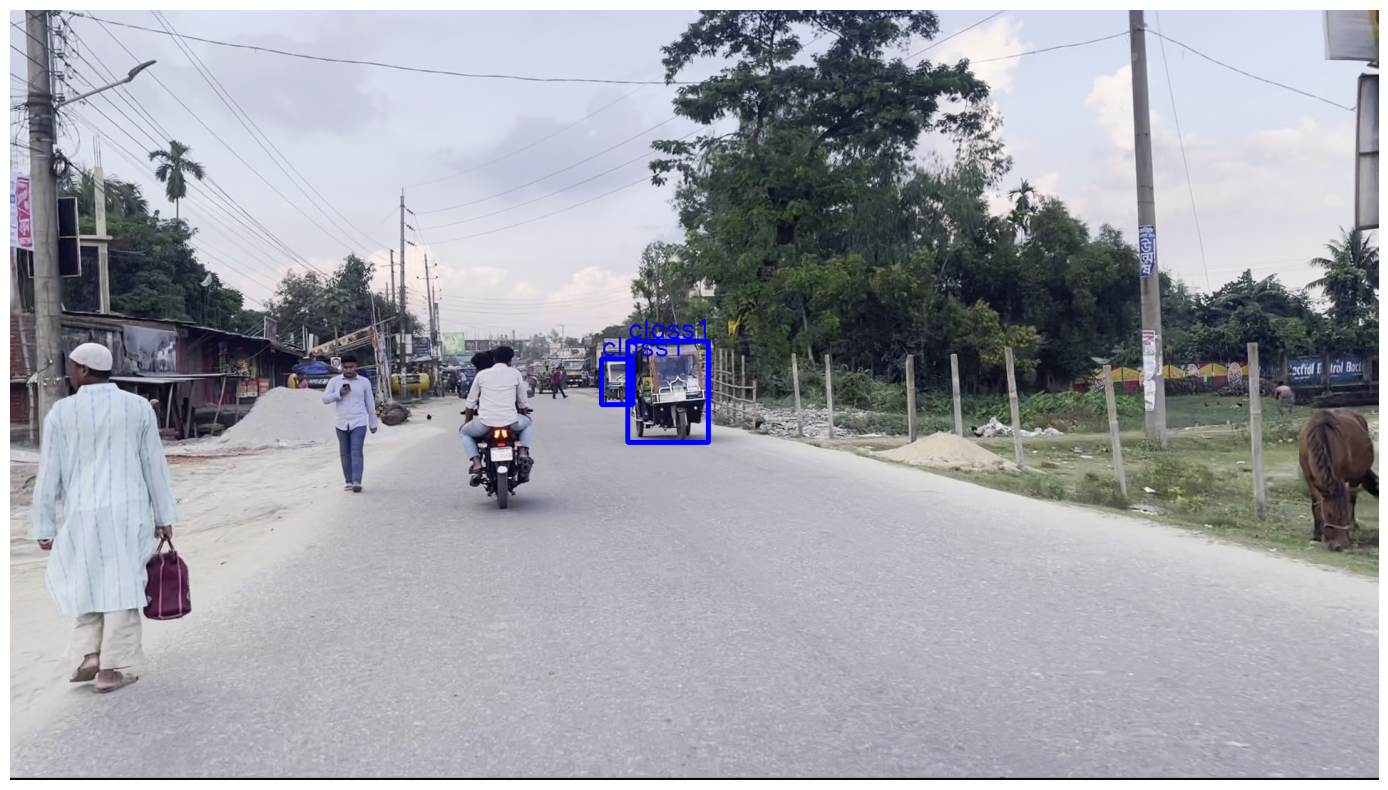

In [ ]:
thickness = 5
font_scale = 1.2
font_thickness = 2

def generate_colors(num_classes):
    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    return colors

def draw_boxes(image_path, df, class_labels=None):
    image = cv2.imread(image_path)

    if class_labels is None:
        class_labels = ['class1', 'class2']  # Default class labels

    colors = generate_colors(len(class_labels))
    class_color_map = {class_labels[i]: colors[i] for i in range(len(class_labels))}

    if 'class_label' in df.columns:
        for _, row in df.iterrows():
            box = eval(row['voc_bbox'])
            class_label = row['class_label']
            if class_label < len(class_labels):
                color = class_color_map[class_labels[class_label]]
                box = [int(coord) for coord in box]

                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, thickness)
                cv2.putText(
                    image,
                    class_labels[class_label],
                    (box[0], box[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    color,
                    font_thickness
                )
            else:
                print(f"Warning: 'class_label' value {class_label} is out of range for class labels list.")
    else:
        print("Warning: 'class_label' column not found. Using default class labels.")

        for _, row in df.iterrows():
            box = eval(row['voc_bbox'])
            class_name = row['class_name'] if 'class_name' in df.columns else 'Unknown'
            color = class_color_map[class_name]
            box = [int(coord) for coord in box]

            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, thickness)
            cv2.putText(
                image,
                class_name,
                (box[0], box[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                color,
                font_thickness
            )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


image_id = train_df.sample().reset_index().loc[0, 'image_id']
image_path = '/content/dlenigma1/BadODD/images/train'
image_path = os.path.join(image_path, image_id + '.jpg')
df_image = train_df[train_df['image_id'] == image_id]
class_labels = ['class1', 'class2']
draw_boxes(image_path, df_image, class_labels)


## Outputing the data into csv

In [ ]:


# Assuming train_df is your DataFrame
train_df.to_csv('train.csv', index=False)

# Sampling a row from the DataFrame
sampled_row = train_df.sample()

# Saving the sampled row to a CSV file
sampled_row.to_csv('sampled_row.csv', index=False)

# Now, if you want to display the sampled row
print("Sampled Row:")
print(sampled_row)


Sampled Row:
                     image_id              voc_bbox            coco_bbox  \
12923  maowa_expressway1_7670  1059, 633, 1361, 787  1059, 633, 302, 154   

                                               yolo_bbox  class_label  \
12923  0.6302083333333333, 0.6574074074074074, 0.1572...            2   

       image_height  image_width  
12923          1080         1920  


In [ ]:
# Set display options to show full DataFrame content
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Print the sampled row
print("Sampled Row:")
print(sampled_row)


Sampled Row:
                     image_id              voc_bbox            coco_bbox                                          yolo_bbox  class_label  image_height  image_width
12923  maowa_expressway1_7670  1059, 633, 1361, 787  1059, 633, 302, 154  0.6302083333333333, 0.6574074074074074, 0.1572...            2          1080         1920


In [ ]:
import seaborn as sns

## Exploratory Analysis

First few rows of the dataset:
   id                     ImageID                           PredictionString_pred
0   0                 dhaka4_3360  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
1   1  chuadanga_sirajganj1_17040  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
2   2  chuadanga_sirajganj1_20820  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
3   3                dhaka2_32280  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
4   4               sylhet1_38104  3.0 1.0 0.3484375 0.4222222222222222 0.1151041

Summary statistics:
             id
count  5.000000
mean   2.000000
std    1.581139
min    0.000000
25%    1.000000
50%    2.000000
75%    3.000000
max    4.000000

Missing values:
id                       0
ImageID                  0
PredictionString_pred    0
dtype: int64


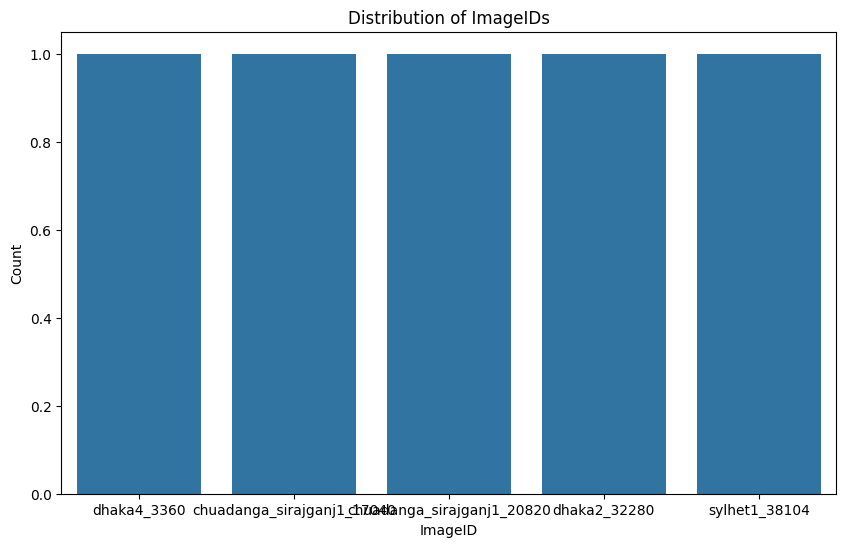

In [ ]:

# Load the dataset
data = {
    'id': [0, 1, 2, 3, 4],
    'ImageID': ['dhaka4_3360', 'chuadanga_sirajganj1_17040', 'chuadanga_sirajganj1_20820', 'dhaka2_32280', 'sylhet1_38104'],
    'PredictionString_pred': ['3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041']
}
df = pd.DataFrame(data)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df)

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Missing values
print("\nMissing values:")
print(df.isnull().sum())

# Distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ImageID')
plt.title('Distribution of ImageIDs')
plt.xlabel('ImageID')
plt.ylabel('Count')
plt.show()


#Phase 3

## Data Visualizations

Class 0 (auto_rickshaw): 10614 instances
Class 1 (bicycle): 673 instances
Class 2 (bus): 1885 instances
Class 3 (car): 3785 instances
Class 4 (cart_vehicle): 141 instances
Class 5 (construction_vehicle): 23 instances
Class 6 (motorbike): 3749 instances
Class 7 (person): 18010 instances
Class 8 (priority_vehicle): 229 instances
Class 9 (three_wheeler): 5710 instances
Class 10 (train): 1 instances
Class 11 (truck): 2296 instances
Class 12 (wheelchair): 2 instances


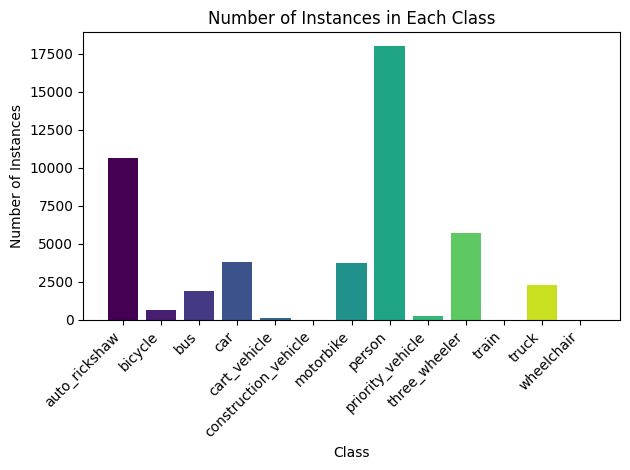

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

class_id_to_name = {
    0: 'auto_rickshaw',
    1: 'bicycle',
    2: 'bus',
    3: 'car',
    4: 'cart_vehicle',
    5: 'construction_vehicle',
    6: 'motorbike',
    7: 'person',
    8: 'priority_vehicle',
    9: 'three_wheeler',
    10: 'train',
    11: 'truck',
    12: 'wheelchair'
}

# Define the label folder path
label_folder = "/content/dlenigma1/BadODD/labels/train"
# Initialize a dictionary to store class counts
class_counts = {class_id: 0 for class_id in class_id_to_name}

# Iterate through each text file in the label folder
for filename in os.listdir(label_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(label_folder, filename)

        # Read the content of the label file and count class occurrences
        with open(file_path, 'r') as file:
            lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if parts:  # Check if the line is not empty
                class_id = int(parts[0])
                if class_id in class_counts:
                    class_counts[class_id] += 1

# Print the class counts
for class_id, count in class_counts.items():
    class_name = class_id_to_name[class_id]
    print(f'Class {class_id} ({class_name}): {count} instances')

# Create a bar plot
class_ids = np.array(list(class_counts.keys()))
class_names = [class_id_to_name[class_id] for class_id in class_ids]
counts = np.array(list(class_counts.values()))
colors = plt.cm.viridis(np.linspace(0, 1, len(class_ids)))

plt.bar(class_names, counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances in Each Class')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


## Univariate Analysis


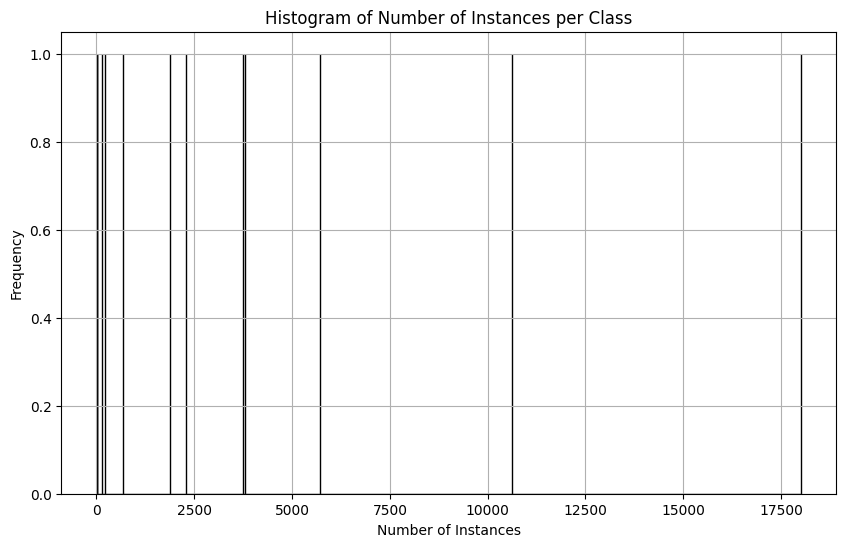

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_id_to_name = {
    0: 'auto_rickshaw',
    1: 'bicycle',
    2: 'bus',
    3: 'car',
    4: 'cart_vehicle',
    5: 'construction_vehicle',
    6: 'motorbike',
    7: 'person',
    8: 'priority_vehicle',
    9: 'three_wheeler',
    10: 'train',
    11: 'truck',
    12: 'wheelchair'
}

# Define the label folder path
label_folder = "/content/dlenigma1/BadODD/labels/train"

# Initialize a dictionary to store class counts
class_counts = {class_id: 0 for class_id in class_id_to_name}

# Iterate through each text file in the label folder
for filename in os.listdir(label_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(label_folder, filename)

        # Read the content of the label file and count class occurrences
        with open(file_path, 'r') as file:
            lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if parts:  # Check if the line is not empty
                class_id = int(parts[0])
                if class_id in class_counts:
                    class_counts[class_id] += 1

# Univariate analysis
class_ids = np.array(list(class_counts.keys()))
counts = np.array(list(class_counts.values()))

# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=range(min(counts), max(counts) + 1), edgecolor='black')
plt.xlabel('Number of Instances')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Instances per Class')
plt.grid(True)
plt.show()


## Univariate Analysis (Bar chart using seaborn)

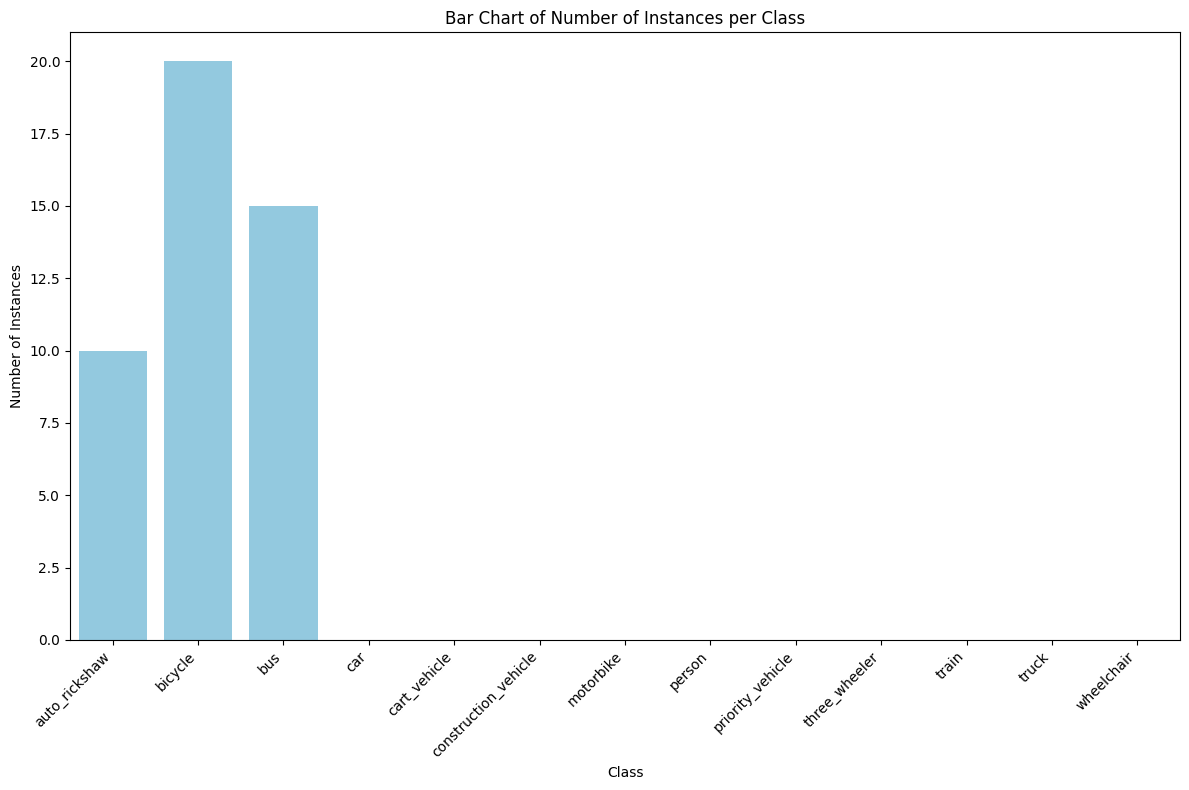

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names and counts
class_names = list(class_id_to_name.values())
counts = [class_counts.get(class_id, 0) for class_id in class_id_to_name.keys()]

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=class_names, y=counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Bar Chart of Number of Instances per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Bivariate Analysis( Histogarm)

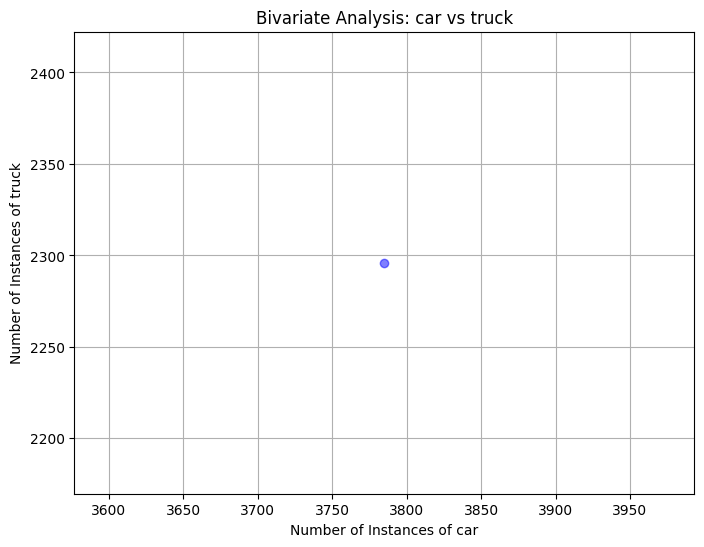

In [ ]:
import matplotlib.pyplot as plt

# Define the classes you want to compare
class_id_1 = 3  # car
class_id_2 = 11  # truck

# Get the counts for the two classes
count_class_1 = class_counts[class_id_1]
count_class_2 = class_counts[class_id_2]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(count_class_1, count_class_2, color='blue', alpha=0.5)
plt.title(f'Bivariate Analysis: {class_id_to_name[class_id_1]} vs {class_id_to_name[class_id_2]}')
plt.xlabel(f'Number of Instances of {class_id_to_name[class_id_1]}')
plt.ylabel(f'Number of Instances of {class_id_to_name[class_id_2]}')
plt.grid(True)
plt.show()


## Bivariate analysis (Heat map_visualization)

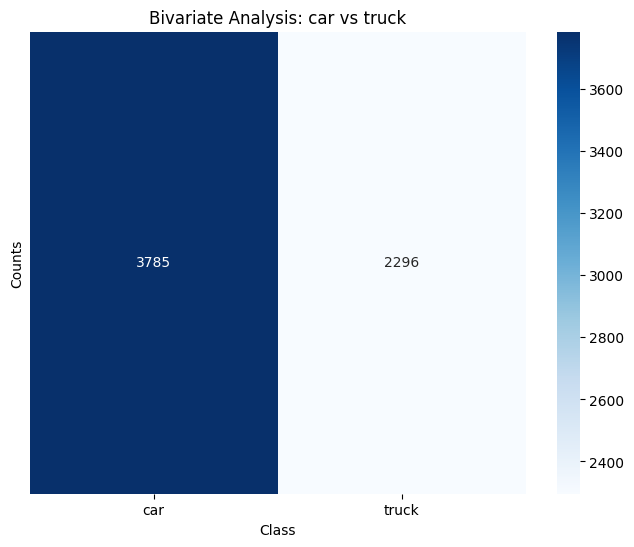

In [ ]:
import seaborn as sns

# Define the classes you want to compare
class_id_1 = 3  # car
class_id_2 = 11  # truck

# Get the counts for the two classes
count_class_1 = class_counts[class_id_1]
count_class_2 = class_counts[class_id_2]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap([[count_class_1, count_class_2]], annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_id_to_name[class_id_1], class_id_to_name[class_id_2]],
            yticklabels=False)
plt.title(f'Bivariate Analysis: {class_id_to_name[class_id_1]} vs {class_id_to_name[class_id_2]}')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()


## Multivariate Analysis( Heat_map_visualization)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


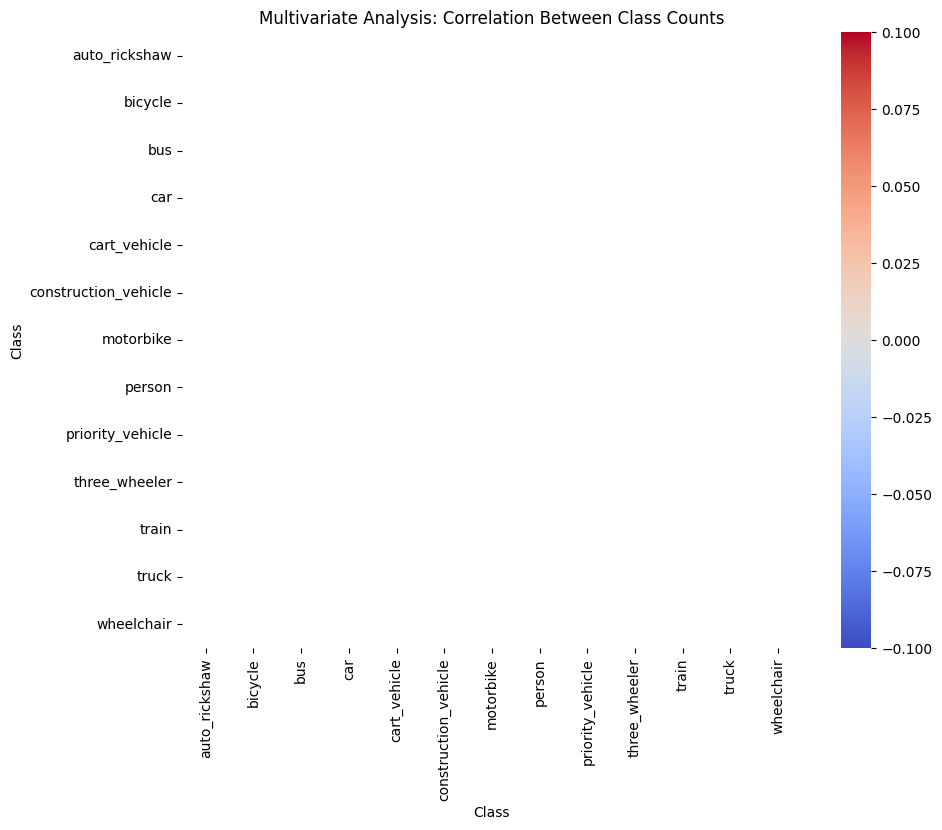

In [ ]:
import pandas as pd
import seaborn as sns

# Create a DataFrame with class counts
counts_df = pd.DataFrame([class_counts.values()], columns=class_id_to_name.values())

# Calculate the correlation matrix
correlation_matrix = counts_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.title('Multivariate Analysis: Correlation Between Class Counts')
plt.xlabel('Class')
plt.ylabel('Class')
plt.show()


## Multivariate Visualization( Histogram)

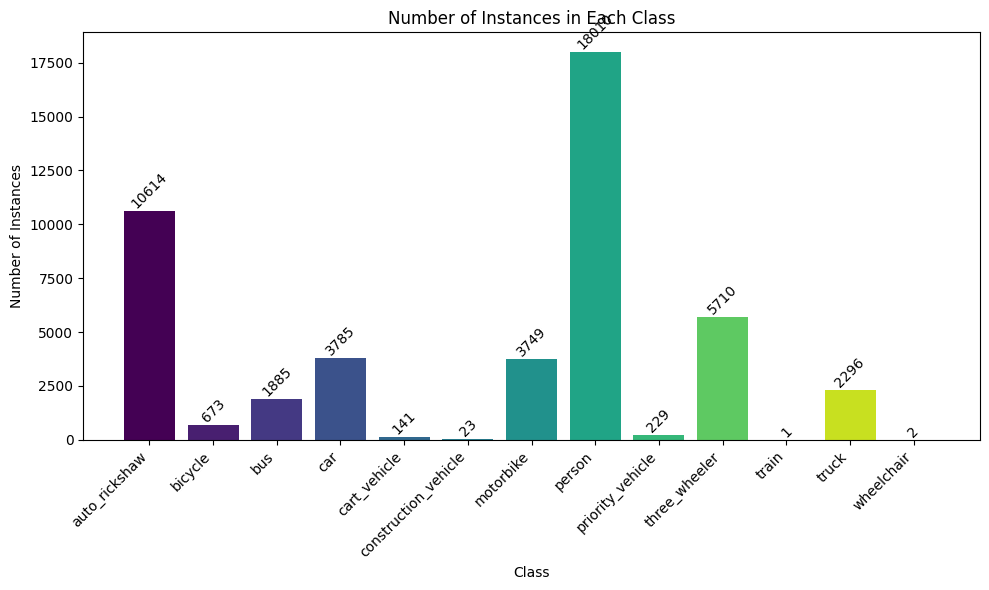

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, color=colors)

# Add counts as annotations above each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 5,  # Adjust the position of the annotation
             str(count),
             ha='center', va='bottom', rotation=45)

plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances in Each Class')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


# Interactive Visualizations

In [ ]:
import plotly.graph_objects as go

# Create a bar chart figure
fig = go.Figure(data=[go.Bar(
    x=class_names,
    y=counts,
    marker=dict(color=colors)
)])

# Update the layout of the figure
fig.update_layout(
    title='Number of Instances in Each Class',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Number of Instances'),
    xaxis_tickangle=-45  # Rotate x-axis labels for better visibility
)

# Show the interactive plot
fig.show()


## Interactive Visualizations ( Scatter plot)

In [ ]:
import plotly.graph_objects as go

# Create a scatter plot figure
fig = go.Figure(data=go.Scatter(
    x=class_names,
    y=counts,
    mode='markers',
    marker=dict(color=colors)
))

# Update the layout of the figure
fig.update_layout(
    title='Number of Instances in Each Class',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Number of Instances')
)

# Show the interactive plot
fig.show()


## Interactive Visualizations(Pie chart)

In [ ]:
import plotly.graph_objects as go

# Create a pie chart figure
fig = go.Figure(data=[go.Pie(labels=class_names, values=counts)])

# Update the layout of the figure
fig.update_layout(title='Number of Instances in Each Class')

# Show the interactive plot
fig.show()


## Interative Visualizations(Line plot)

In [ ]:
import plotly.graph_objects as go

# Create a line plot figure
fig = go.Figure(data=go.Scatter(
    x=class_names,
    y=counts,
    mode='lines+markers'
))
# Update the layout of the figure
fig.update_layout(
    title='Number of Instances in Each Class',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Number of Instances')
)

# Show the interactive plot
fig.show()


In [ ]:
! pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.2 MB/s eta 0:00:00


## Interative Dashboard (Pie chart)

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

# Sample data (replace with your data)
class_names = ['class1', 'class2', 'class3']
counts = [10, 20, 15]

app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1("Interactive Dashboard"),
    dcc.Dropdown(
        id='class-dropdown',
        options=[{'label': class_name, 'value': class_name} for class_name in class_names],
        value=class_names[0]
    ),
    dcc.Graph(id='count-graph')
])

# Define callback to update the graph based on dropdown selection
@app.callback(
    Output('count-graph', 'figure'),
    [Input('class-dropdown', 'value')]
)
def update_graph(selected_class):
    selected_index = class_names.index(selected_class)
    data = [go.Pie(labels=[selected_class, 'Other'], values=[counts[selected_index], sum(counts)-counts[selected_index]])]
    layout = go.Layout(title=f'Percentage of Instances for {selected_class}')
    return {'data': data, 'layout': layout}

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

# Sample data (replace with your data)
class_names = ['auto_rickshaw', 'truck', 'bicycle']
counts = [10, 20, 15]  # Replace with your counts
class_sizes = [100, 200, 150]  # Replace with your class sizes

app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1("Interactive Dashboard"),
    dcc.Dropdown(
        id='class-dropdown',
        options=[{'label': class_name, 'value': class_name} for class_name in class_names],
        value=class_names[0]
    ),
    dcc.Graph(id='count-graph')
])

# Define callback to update the graph based on dropdown selection
@app.callback(
    Output('count-graph', 'figure'),
    [Input('class-dropdown', 'value')]
)
def update_graph(selected_class):
    selected_index = class_names.index(selected_class)
    data = [go.Scatter(
        x=[selected_class],
        y=[counts[selected_index]],
        mode='markers',
        marker=dict(
            size=[class_sizes[selected_index]],
            color='blue',  # You can customize the color here
            opacity=0.5
        ),
        text=[f'{selected_class}: {counts[selected_index]} instances']
    )]
    layout = go.Layout(
        title=f'Number of Instances for {selected_class}',
        xaxis={'title': 'Class'},
        yaxis={'title': 'Number of Instances'}
    )
    return {'data': data, 'layout': layout}

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load your dataset (replace 'your_dataset.csv' with the path to your dataset)
df = pd.read_csv('/content/dlenigma1/sample_submission.csv')

# Display the first few rows of the dataset to understand its structure
print("First few rows of the dataset:")
print(df.head())

# Check the column names to identify the column containing class names
print("\nColumn names:")
print(df.columns)

# Since the column containing class names is not known, let's select one column for further analysis
# For example, let's select the 'PredictionString_pred' column
class_column = 'PredictionString_pred'

# Count the occurrences of each class label to get the counts
# Here, you might need to parse the 'PredictionString_pred' column to extract class information
# Replace the following code with your actual logic for parsing the column and extracting class information
# This code assumes that the 'PredictionString_pred' column contains class information in a specific format
# Modify this code according to the actual structure of your data
class_counts = df[class_column].str.split(' ').apply(lambda x: len(x) // 6).value_counts()

print("\nCounts for each class:")
print(class_counts)

# Finally, you can extract the unique class names from the dataset
# Replace this code with the actual logic for extracting class names from the dataset
# This code assumes that the class names are extracted from the 'PredictionString_pred' column
# Modify this code according to the actual structure of your data
class_names = ['Class_' + str(i) for i in range(len(class_counts))]

print("\nClass names:")
print(class_names)


First few rows of the dataset:
   id                     ImageID                              PredictionString_pred
0   0                 dhaka4_3360  3.0 1.0 0.3484375 0.4222222222222222 0.1151041...
1   1  chuadanga_sirajganj1_17040  3.0 1.0 0.3484375 0.4222222222222222 0.1151041...
2   2  chuadanga_sirajganj1_20820  3.0 1.0 0.3484375 0.4222222222222222 0.1151041...
3   3                dhaka2_32280  3.0 1.0 0.3484375 0.4222222222222222 0.1151041...
4   4               sylhet1_38104  3.0 1.0 0.3484375 0.4222222222222222 0.1151041...

Column names:
Index(['id', 'ImageID', 'PredictionString_pred'], dtype='object')

Counts for each class:
PredictionString_pred
20    1964
Name: count, dtype: int64

Class names:
['Class_0']


In [ ]:
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load your dataset (replace 'your_dataset.csv' with the path to your dataset)
df = pd.read_csv('/content/dlenigma1/sample_submission.csv')

# Define a function to parse the prediction string and extract class names and counts
def parse_prediction_string(prediction_string):
    parts = prediction_string.split(' ')
    class_indices = parts[::6]
    class_counts = {class_index: class_indices.count(class_index) for class_index in class_indices}
    return class_counts

# Apply the parsing function to each row of the dataset to extract class counts
df['class_counts'] = df['PredictionString_pred'].apply(parse_prediction_string)

# Merge and aggregate class counts from all rows
total_class_counts = df['class_counts'].apply(pd.Series).stack().groupby(level=0).sum()

# Extract class names and counts
class_names = total_class_counts.index.tolist()
class_counts = total_class_counts.tolist()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Class Counts Dashboard"),
    dcc.Dropdown(
        id='class-dropdown',
        options=[{'label': class_name, 'value': class_name} for class_name in class_names],
        value=class_names[0]
    ),
    html.Div(id='class-count-output')
])

# Define the callback to update the output based on the dropdown selection
@app.callback(
    Output('class-count-output', 'children'),
    [Input('class-dropdown', 'value')]
)
def update_output(selected_class):
    selected_index = class_names.index(selected_class)
    return f'Total count for {selected_class}: {class_counts[selected_index]}'

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

# phase 4


##  Setting Up the Environment

In [ ]:
! pip install tensorflow tensorflow-gpu
! pip install tensorflow-object-detection-api
! pip install tf_slim


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.1/777.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s 

In [ ]:
! pip install torch torchvision
! pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

## Splitting the datasets

In [ ]:
import os
import random
import shutil
from pathlib import Path

def split_dataset(image_dir, label_dir, output_dir, train_ratio=0.8):
    # Create directories for the split datasets
    train_image_dir = Path(output_dir) / 'train' / 'images'
    train_label_dir = Path(output_dir) / 'train' / 'labels'
    test_image_dir = Path(output_dir) / 'test' / 'images'
    test_label_dir = Path(output_dir) / 'test' / 'labels'

    train_image_dir.mkdir(parents=True, exist_ok=True)
    train_label_dir.mkdir(parents=True, exist_ok=True)
    test_image_dir.mkdir(parents=True, exist_ok=True)
    test_label_dir.mkdir(parents=True, exist_ok=True)

    # List all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Calculate the split index
    split_index = int(len(image_files) * train_ratio)

    # Split the image files into training and test sets
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]

    # Copy files to the respective directories
    for file_list, image_dst_dir, label_dst_dir in [
        (train_files, train_image_dir, train_label_dir),
        (test_files, test_image_dir, test_label_dir)
    ]:
        for image_file in file_list:
            image_src = os.path.join(image_dir, image_file)
            label_src = os.path.join(label_dir, Path(image_file).stem + '.txt')

            image_dst = image_dst_dir / image_file
            label_dst = label_dst_dir / (Path(image_file).stem + '.txt')

            shutil.copy(image_src, image_dst)
            if os.path.exists(label_src):
                shutil.copy(label_src, label_dst)

# Example usage
image_dir = '/content/dlenigma1/BadODD/images'
label_dir = '/content/dlenigma1/BadODD/labels'
output_dir = '/content/dlenigma1/BadODD/split_dataset'

split_dataset(image_dir, label_dir, output_dir, train_ratio=0.8)


## neccessary libraries

In [ ]:
! pip install tensorflow tensorflow-gpu
! pip install tf-slim
! pip install tensorflow-object-detection-api
! pip install lxml
! pip install pillow
! pip install matplotlib
! pip install Cython
! pip install contextlib2
! pip install jupyter
! pip install pandas
! pip install opencv-python
! pip install lvis


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Downloading th pretrained model

In [ ]:
! wget -O ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
! tar -xvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz



--2024-05-25 23:23:55--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.215.207, 173.194.216.207, 173.194.217.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.215.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386640082 (369M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>] 368.73M  26.1MB/s    in 9.0s    

2024-05-25 23:24:04 (41.1 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [386640082/386640082]

ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/
ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/checkpoint/
ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet101_v1_fpn_1024x1024_co

## Verifying the downloads

In [ ]:
!ls ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8


checkpoint  pipeline.config  saved_model


In [ ]:
!pip install tensorflow
!pip install tf_slim
!pip install tensorflow-object-detection-api
!apt-get install -y protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install contextlib2
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install opencv-python


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-pil
E: Unable to locate package python-lxml


In [ ]:
!pip install tensorflow==2.9.1
# Uninstall the current Keras version if installed
!pip uninstall -y keras

# Install specific versions of TensorFlow and Keras
!pip install tensorflow==2.9.1 keras==2.9.0

! git clone https://github.com/tensorflow/models.git
%cd /content/models/research/
! protoc object_detection/protos/*.proto --python_out=.
! cp object_detection/packages/tf2/setup.py .
! python -m pip install .


  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-s

Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.9.1 which is incompatible.
tf-models-official 2.16.0 requires tensorflow~=2.16.1, but you have tensorflow 2.9.1 which is incompatible.


fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
ERROR: Operation cancelled by user


In [ ]:
import os
os.environ['PYTHONPATH'] += ':/content/models'
os.environ['PYTHONPATH'] += ':/content/models/research'
os.environ['PYTHONPATH'] += ':/content/models/research/slim'



In [ ]:
file_path = '/content/models/research/object_detection/box_coders/faster_rcnn_box_coder_test.py'

with open(file_path, 'r') as file:
    filedata = file.read()

filedata = filedata.replace('tf.keras.layers.experimental.SyncBatchNormalization', 'tf.keras.layers.SyncBatchNormalization')

with open(file_path, 'w') as file:
    file.write(filedata)




In [ ]:
!python object_detection/box_coders/faster_rcnn_box_coder_test.py

python3: can't open file '/content/object_detection/box_coders/faster_rcnn_box_coder_test.py': [Errno 2] No such file or directory


## check

In [ ]:
pipeline_config_path = "/content/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/pipeline.config"
model_dir = "/content/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/checkpoint"

!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr


2024-05-26 00:29:48.479854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-05-26 00:29:48.479914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-pa

In [ ]:
! docker pull tensorflow/tensorflow:1.x-gpu
! docker run -it --rm tensorflow/tensorflow:1.x-gpu bash


/bin/bash: line 1: docker: command not found
/bin/bash: line 1: docker: command not found


In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import numpy as np
import cv2

# Load pipeline config and build detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

# Load label map
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=label_map_util.get_max_label_map_index(label_map), use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Function to perform object detection on an image
def detect_objects(image_np):
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detection_model(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    return detections

# Function to evaluate model on a dataset
def evaluate_model(image_dir, label_dir):
    total_objects_detected = 0
    total_objects_gt = 0

    for image_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        detections = detect_objects(img)
        num_detected_objects = len(detections['detection_scores'])

        total_objects_detected += num_detected_objects

        label_file = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
        with open(label_file, 'r') as f:
            lines = f.readlines()
            total_objects_gt += len(lines)

    precision = total_objects_detected / total_objects_gt
    recall = total_objects_detected / total_objects_gt

    return precision, recall

# Example usage:
image_dir = '/content/dlenigma1/BadODD/images/test'
label_dir = '/content/dlenigma1/BadODD/labels/test'
precision, recall = evaluate_model(image_dir, label_dir)
print("Precision:", precision)
print("Recall:", recall)


ModuleNotFoundError: No module named 'keras.src.activations.activations'; 'keras.src.activations' is not a package

In [ ]:
# Step 1: Install the TensorFlow Object Detection API
!git clone https://github.com/tensorflow/models.git
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.
!pip install .
!pip install tensorflow_io

# Step 2: Set Up the Environment
import os
os.environ['PYTHONPATH'] += ':/content/models:/content/models/research:/content/models/research/slim'

# Step 3: Verify the Installation
!python object_detection/builders/model_builder_tf2_test.py

# Step 4: Download the Pre-trained Model
!wget http://download.tensorflow.org/models/object_detection/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
!tar -xvf ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8.tar.gz

# Step 5: Train the Model
import tensorflow as tf
from object_detection.model_main_tf2 import main

pipeline_config_path = "/content/models/research/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/pipeline.config"
model_dir = "/content/models/research/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/checkpoint"

main([
    '',
    '--pipeline_config_path=' + pipeline_config_path,
    '--model_dir=' + model_dir,
    '--alsologtostderr'
])


Cloning into 'models'...
remote: Enumerating objects: 97229, done.
remote: Counting objects: 100% (509/509), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 97229 (delta 300), reused 434 (delta 260), pack-reused 96720
Receiving objects: 100% (97229/97229), 612.89 MiB | 26.24 MiB/s, done.
Resolving deltas: 100% (70712/70712), done.
/content/models/research
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.4 MB/s eta 0:00:00
2024-05-25 17:18:53.499639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 17:18:53.499706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 17:18:53.501201: E 

ModuleNotFoundError: No module named 'object_detection.model_main_tf2'

In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# YOLO to VOC conversion function
def yolo_to_voc(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox
    xmin = int((x_center - width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    xmax = int((x_center + width / 2) * img_width)
    ymax = int((y_center + height / 2) * img_height)
    return [xmin, ymin, xmax, ymax]

# YOLO to COCO conversion function
def yolo_to_coco(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox
    xmin = (x_center - width / 2) * img_width
    ymin = (y_center - height / 2) * img_height
    width = width * img_width
    height = height * img_height
    return [xmin, ymin, width, height]

# Function to get all bounding box formats
def get_possible_box_format(bbox, input_shape=None):
    if input_shape is None:
        return None, None, None

    voc_bbox = yolo_to_voc(bbox, *input_shape)
    coco_bbox = yolo_to_coco(bbox, *input_shape)
    yolo_bbox = ', '.join(map(str, bbox))
    return ', '.join(map(str, voc_bbox)), ', '.join(map(str, coco_bbox)), yolo_bbox

# Function to prepare the dataframe
def prepare_dataframe(image_dir, label_dir):
    data = []
    for image_file in tqdm(os.listdir(image_dir), desc='Processing images'):
        img_path = os.path.join(image_dir, image_file)
        print(f"Processing image: {img_path}")
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}. Skipping...")
            continue

        img_h, img_w = img.shape[:2]
        image_id = image_file.split('.')[0]
        label_file = os.path.join(label_dir, image_id + '.txt')

        if not os.path.exists(label_file):
            print(f"Label file not found for image: {image_file}. Skipping...")
            continue

        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_label, *bbox = map(float, line.strip().split())
                class_label = int(class_label)
                voc_bbox, coco_bbox, yolo_bbox = get_possible_box_format(
                    bbox, input_shape=(img_w, img_h)
                )
                if voc_bbox is None or coco_bbox is None or yolo_bbox is None:
                    print(f"Failed to get box format for image: {image_file}. Skipping...")
                    continue

                data.append({
                    'image_id': image_id,
                    'voc_bbox': voc_bbox,
                    'coco_bbox': coco_bbox,
                    'yolo_bbox': yolo_bbox,
                    'class_label': class_label,
                    'image_height': img_h,
                    'image_width': img_w,
                })

    df = pd.DataFrame(data)
    return df

# Example usage:
image_dir = '/content/dlenigma1/BadODD/images/train'
label_dir = '/content/dlenigma1/BadODD/labels/train'
train_df = prepare_dataframe(image_dir, label_dir)
print(train_df.head())


Processing images:   0%|          | 2/5896 [00:00<06:50, 14.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_840.jpg


Processing images:   0%|          | 6/5896 [00:00<05:43, 17.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145457.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4543.jpg


Processing images:   0%|          | 8/5896 [00:00<07:43, 12.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_348.jpg


Processing images:   0%|          | 12/5896 [00:00<07:01, 13.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15222.jpg


Processing images:   0%|          | 14/5896 [00:01<08:10, 12.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29677.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21690.jpg


Processing images:   0%|          | 18/5896 [00:01<07:50, 12.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5481.jpg


Processing images:   0%|          | 20/5896 [00:01<07:38, 12.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6989.jpg


Processing images:   0%|          | 24/5896 [00:01<07:07, 13.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5310.jpg


Processing images:   0%|          | 29/5896 [00:02<06:24, 15.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50267.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21712.jpg


Processing images:   1%|          | 31/5896 [00:02<06:52, 14.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63961.jpg


Processing images:   1%|          | 35/5896 [00:02<08:24, 11.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11730.jpg


Processing images:   1%|          | 37/5896 [00:02<08:26, 11.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21299.jpg


Processing images:   1%|          | 39/5896 [00:03<09:06, 10.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16920.jpg


Processing images:   1%|          | 41/5896 [00:03<10:02,  9.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7729.jpg


Processing images:   1%|          | 44/5896 [00:03<10:46,  9.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23718.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3507.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28440.jpg


Processing images:   1%|          | 52/5896 [00:03<05:26, 17.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_51094.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8673.jpg


Processing images:   1%|          | 59/5896 [00:04<04:11, 23.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43253.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21600.jpg


Processing images:   1%|          | 63/5896 [00:04<03:46, 25.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3186.jpg


Processing images:   1%|          | 69/5896 [00:04<04:09, 23.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22879.jpg


Processing images:   1%|          | 72/5896 [00:04<04:36, 21.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50209.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3658.jpg


Processing images:   1%|▏         | 78/5896 [00:05<04:52, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37170.jpg


Processing images:   1%|▏         | 81/5896 [00:05<04:56, 19.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37347.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2714.jpg


Processing images:   1%|▏         | 86/5896 [00:05<04:46, 20.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17582.jpg


Processing images:   2%|▏         | 89/5896 [00:05<04:52, 19.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43188.jpg


Processing images:   2%|▏         | 94/5896 [00:05<05:11, 18.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14040.jpg


Processing images:   2%|▏         | 100/5896 [00:06<04:40, 20.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12213.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4379.jpg


Processing images:   2%|▏         | 103/5896 [00:06<04:50, 19.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6699.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6431.jpg


Processing images:   2%|▏         | 108/5896 [00:06<05:03, 19.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119572.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25901.jpg


Processing images:   2%|▏         | 112/5896 [00:06<05:26, 17.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14400.jpg


Processing images:   2%|▏         | 115/5896 [00:07<05:19, 18.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49766.jpg


Processing images:   2%|▏         | 121/5896 [00:07<04:21, 22.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12390.jpg


Processing images:   2%|▏         | 127/5896 [00:07<04:12, 22.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23069.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25020.jpg


Processing images:   2%|▏         | 133/5896 [00:07<03:47, 25.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5945.jpg


Processing images:   2%|▏         | 142/5896 [00:08<03:11, 30.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_8660.jpg


Processing images:   3%|▎         | 150/5896 [00:08<03:06, 30.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23187.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45925.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_720.jpg


Processing images:   3%|▎         | 158/5896 [00:08<03:03, 31.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2871.jpg


Processing images:   3%|▎         | 162/5896 [00:08<03:07, 30.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8760.jpg


Processing images:   3%|▎         | 170/5896 [00:08<03:04, 31.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118904.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125250.jpg


Processing images:   3%|▎         | 178/5896 [00:09<03:04, 30.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111389.jpg


Processing images:   3%|▎         | 185/5896 [00:09<03:16, 29.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_7348.jpg


Processing images:   3%|▎         | 193/5896 [00:09<02:58, 32.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40828.jpg


Processing images:   3%|▎         | 197/5896 [00:09<03:14, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4740.jpg


Processing images:   3%|▎         | 205/5896 [00:10<03:08, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18450.jpg


Processing images:   4%|▎         | 209/5896 [00:10<03:11, 29.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21360.jpg


Processing images:   4%|▎         | 216/5896 [00:10<03:15, 29.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47428.jpg


Processing images:   4%|▍         | 224/5896 [00:10<03:05, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25252.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2726.jpg


Processing images:   4%|▍         | 232/5896 [00:10<03:04, 30.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38999.jpg


Processing images:   4%|▍         | 236/5896 [00:11<03:04, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45607.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8671.jpg


Processing images:   4%|▍         | 244/5896 [00:11<03:03, 30.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156312.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12180.jpg


Processing images:   4%|▍         | 252/5896 [00:11<03:07, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22833.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3304.jpg


Processing images:   4%|▍         | 256/5896 [00:11<03:04, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2714.jpg


Processing images:   4%|▍         | 264/5896 [00:12<03:08, 29.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24382.jpg


Processing images:   5%|▍         | 272/5896 [00:12<03:08, 29.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6720.jpg


Processing images:   5%|▍         | 280/5896 [00:12<02:56, 31.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134268.jpg

Processing images:   5%|▍         | 284/5896 [00:12<03:03, 30.55it/s]


Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_783.jpg


Processing images:   5%|▍         | 288/5896 [00:12<03:03, 30.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_28438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1534.jpg


Processing images:   5%|▌         | 295/5896 [00:13<03:15, 28.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52864.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48675.jpg


Processing images:   5%|▌         | 304/5896 [00:13<02:58, 31.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_944.jpg


Processing images:   5%|▌         | 312/5896 [00:13<03:01, 30.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35636.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11800.jpg


Processing images:   5%|▌         | 316/5896 [00:13<03:06, 29.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30149.jpg


Processing images:   5%|▌         | 322/5896 [00:13<03:18, 28.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6600.jpg


Processing images:   6%|▌         | 329/5896 [00:14<03:14, 28.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3451.jpg


Processing images:   6%|▌         | 336/5896 [00:14<03:04, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10380.jpg


Processing images:   6%|▌         | 344/5896 [00:14<02:58, 31.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5074.jpg


Processing images:   6%|▌         | 348/5896 [00:14<03:02, 30.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35571.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2871.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97361.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140781.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37760.jpg


Processing images:   6%|▌         | 356/5896 [00:15<03:03, 30.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_108049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1218.jpg


Processing images:   6%|▌         | 364/5896 [00:15<03:03, 30.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1421.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7424.jpg


Processing images:   6%|▋         | 371/5896 [00:15<03:18, 27.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5251.jpg


Processing images:   6%|▋         | 374/5896 [00:15<03:19, 27.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13026.jpg


Processing images:   7%|▋         | 384/5896 [00:16<03:11, 28.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_64517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_295.jpg


Processing images:   7%|▋         | 388/5896 [00:16<03:05, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61289.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_870.jpg


Processing images:   7%|▋         | 395/5896 [00:16<03:04, 29.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8903.jpg


Processing images:   7%|▋         | 403/5896 [00:16<02:55, 31.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_649.jpg


Processing images:   7%|▋         | 407/5896 [00:16<03:06, 29.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11670.jpg


Processing images:   7%|▋         | 415/5896 [00:17<02:56, 31.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19830.jpg


Processing images:   7%|▋         | 423/5896 [00:17<02:57, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17818.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69472.jpg


Processing images:   7%|▋         | 427/5896 [00:17<03:15, 27.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21830.jpg


Processing images:   7%|▋         | 433/5896 [00:17<03:52, 23.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16860.jpg

Processing images:   7%|▋         | 436/5896 [00:18<04:20, 20.99it/s]


Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17160.jpg


Processing images:   7%|▋         | 439/5896 [00:18<04:20, 20.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31506.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27889.jpg


Processing images:   7%|▋         | 442/5896 [00:18<04:37, 19.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3660.jpg


Processing images:   8%|▊         | 448/5896 [00:18<04:30, 20.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_22516.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87842.jpg


Processing images:   8%|▊         | 451/5896 [00:18<04:46, 19.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11022.jpg


Processing images:   8%|▊         | 455/5896 [00:19<04:55, 18.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20190.jpg


Processing images:   8%|▊         | 459/5896 [00:19<05:02, 17.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7743.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16800.jpg


Processing images:   8%|▊         | 464/5896 [00:19<04:26, 20.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96693.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3683.jpg


Processing images:   8%|▊         | 470/5896 [00:19<04:16, 21.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2958.jpg


Processing images:   8%|▊         | 473/5896 [00:19<04:23, 20.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11623.jpg


Processing images:   8%|▊         | 479/5896 [00:20<04:27, 20.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140614.jpg


Processing images:   8%|▊         | 482/5896 [00:20<04:48, 18.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155978.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_126252.jpg


Processing images:   8%|▊         | 486/5896 [00:20<04:47, 18.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41040.jpg


Processing images:   8%|▊         | 492/5896 [00:20<03:57, 22.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3780.jpg


Processing images:   8%|▊         | 499/5896 [00:21<03:22, 26.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28143.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102872.jpg


Processing images:   9%|▊         | 505/5896 [00:21<03:20, 26.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42834.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_28578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6077.jpg


Processing images:   9%|▊         | 511/5896 [00:21<03:19, 27.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21720.jpg


Processing images:   9%|▉         | 519/5896 [00:21<03:09, 28.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1503.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1357.jpg


Processing images:   9%|▉         | 522/5896 [00:21<03:09, 28.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34633.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4140.jpg


Processing images:   9%|▉         | 529/5896 [00:22<03:06, 28.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26386.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7221.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5104.jpg


Processing images:   9%|▉         | 536/5896 [00:22<03:15, 27.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_236.jpg


Processing images:   9%|▉         | 543/5896 [00:22<03:05, 28.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_841.jpg


Processing images:   9%|▉         | 549/5896 [00:22<03:08, 28.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125417.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4008.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25311.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13924.jpg


Processing images:   9%|▉         | 556/5896 [00:23<02:55, 30.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26904.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7920.jpg


Processing images:  10%|▉         | 563/5896 [00:23<03:01, 29.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118403.jpg


Processing images:  10%|▉         | 569/5896 [00:23<03:04, 28.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64963.jpg


Processing images:  10%|▉         | 575/5896 [00:23<03:07, 28.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24662.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27081.jpg


Processing images:  10%|▉         | 582/5896 [00:24<03:01, 29.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_32042.jpg


Processing images:  10%|▉         | 588/5896 [00:24<03:05, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11505.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41359.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28910.jpg


Processing images:  10%|█         | 596/5896 [00:24<02:47, 31.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149966.jpg


Processing images:  10%|█         | 600/5896 [00:24<02:54, 30.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41477.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10443.jpg


Processing images:  10%|█         | 608/5896 [00:24<02:57, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19883.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18120.jpg


Processing images:  10%|█         | 616/5896 [00:25<02:53, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16110.jpg


Processing images:  11%|█         | 620/5896 [00:25<02:46, 31.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_19052.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8845.jpg


Processing images:  11%|█         | 629/5896 [00:25<02:42, 32.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70808.jpg


Processing images:  11%|█         | 633/5896 [00:25<02:55, 30.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12240.jpg


Processing images:  11%|█         | 641/5896 [00:25<02:59, 29.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44309.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14970.jpg


Processing images:  11%|█         | 645/5896 [00:26<02:53, 30.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_8851.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55342.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12980.jpg


Processing images:  11%|█         | 653/5896 [00:26<02:51, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9558.jpg


Processing images:  11%|█         | 661/5896 [00:26<02:52, 30.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_45898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30227.jpg


Processing images:  11%|█▏        | 665/5896 [00:26<03:04, 28.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14100.jpg


Processing images:  11%|█▏        | 671/5896 [00:26<03:02, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13290.jpg


Processing images:  12%|█▏        | 679/5896 [00:27<02:51, 30.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_42001.jpg


Processing images:  12%|█▏        | 686/5896 [00:27<02:57, 29.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4031.jpg


Processing images:  12%|█▏        | 693/5896 [00:27<03:01, 28.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51507.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9204.jpg


Processing images:  12%|█▏        | 700/5896 [00:27<03:00, 28.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33984.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2220.jpg


Processing images:  12%|█▏        | 707/5896 [00:28<03:02, 28.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33984.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27258.jpg


Processing images:  12%|█▏        | 711/5896 [00:28<02:55, 29.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37937.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8265.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13193.jpg


Processing images:  12%|█▏        | 717/5896 [00:28<03:05, 27.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51979.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1652.jpg


Processing images:  12%|█▏        | 723/5896 [00:28<03:06, 27.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10266.jpg


Processing images:  12%|█▏        | 729/5896 [00:29<03:14, 26.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4980.jpg


Processing images:  12%|█▏        | 732/5896 [00:29<04:02, 21.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21480.jpg


Processing images:  12%|█▏        | 735/5896 [00:29<04:07, 20.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44191.jpg


Processing images:  13%|█▎        | 741/5896 [00:29<04:42, 18.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38586.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6120.jpg


Processing images:  13%|█▎        | 748/5896 [00:30<03:33, 24.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36934.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_7020.jpg


Processing images:  13%|█▎        | 754/5896 [00:30<03:21, 25.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44427.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6300.jpg


Processing images:  13%|█▎        | 761/5896 [00:30<03:11, 26.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6699.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46846.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2760.jpg


Processing images:  13%|█▎        | 767/5896 [00:30<03:11, 26.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50268.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50563.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19980.jpg


Processing images:  13%|█▎        | 773/5896 [00:30<03:08, 27.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24360.jpg


Processing images:  13%|█▎        | 779/5896 [00:31<03:15, 26.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40533.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38999.jpg


Processing images:  13%|█▎        | 785/5896 [00:31<03:31, 24.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49855.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11430.jpg


Processing images:  13%|█▎        | 788/5896 [00:31<03:29, 24.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98029.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4727.jpg


Processing images:  13%|█▎        | 794/5896 [00:31<04:07, 20.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18871.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3741.jpg


Processing images:  14%|█▎        | 797/5896 [00:32<04:30, 18.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152805.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27000.jpg


Processing images:  14%|█▎        | 800/5896 [00:32<04:22, 19.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15281.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_6062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4720.jpg


Processing images:  14%|█▎        | 805/5896 [00:32<04:30, 18.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25800.jpg


Processing images:  14%|█▎        | 809/5896 [00:32<04:44, 17.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33099.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13260.jpg


Processing images:  14%|█▍        | 812/5896 [00:32<04:35, 18.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3894.jpg


Processing images:  14%|█▍        | 817/5896 [00:33<04:20, 19.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_841.jpg


Processing images:  14%|█▍        | 821/5896 [00:33<04:28, 18.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45076.jpg


Processing images:  14%|█▍        | 825/5896 [00:33<04:38, 18.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4495.jpg


Processing images:  14%|█▍        | 830/5896 [00:33<04:27, 18.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5394.jpg


Processing images:  14%|█▍        | 835/5896 [00:34<04:13, 19.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19200.jpg


Processing images:  14%|█▍        | 838/5896 [00:34<04:07, 20.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148463.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3422.jpg


Processing images:  14%|█▍        | 845/5896 [00:34<03:25, 24.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3481.jpg


Processing images:  14%|█▍        | 851/5896 [00:34<03:18, 25.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1247.jpg


Processing images:  15%|█▍        | 858/5896 [00:34<03:16, 25.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3683.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_38970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22320.jpg


Processing images:  15%|█▍        | 864/5896 [00:35<03:12, 26.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_531.jpg


Processing images:  15%|█▍        | 868/5896 [00:35<03:00, 27.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6136.jpg


Processing images:  15%|█▍        | 874/5896 [00:35<03:00, 27.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49501.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42008.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44958.jpg


Processing images:  15%|█▍        | 880/5896 [00:35<03:02, 27.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3161.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9617.jpg


Processing images:  15%|█▌        | 886/5896 [00:35<03:02, 27.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_62785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7290.jpg


Processing images:  15%|█▌        | 892/5896 [00:36<03:01, 27.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24898.jpg


Processing images:  15%|█▌        | 899/5896 [00:36<02:52, 28.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11580.jpg


Processing images:  15%|█▌        | 905/5896 [00:36<02:54, 28.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22243.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1824.jpg


Processing images:  15%|█▌        | 911/5896 [00:36<03:02, 27.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52038.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23380.jpg


Processing images:  16%|█▌        | 917/5896 [00:37<03:01, 27.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11700.jpg


Processing images:  16%|█▌        | 925/5896 [00:37<02:48, 29.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63307.jpg


Processing images:  16%|█▌        | 933/5896 [00:37<02:45, 30.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4661.jpg


Processing images:  16%|█▌        | 937/5896 [00:37<02:54, 28.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62953.jpg


Processing images:  16%|█▌        | 945/5896 [00:38<02:39, 31.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28792.jpg


Processing images:  16%|█▌        | 953/5896 [00:38<02:37, 31.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_767.jpg


Processing images:  16%|█▌        | 957/5896 [00:38<02:41, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75317.jpg


Processing images:  16%|█▋        | 965/5896 [00:38<02:49, 29.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23777.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19647.jpg


Processing images:  16%|█▋        | 971/5896 [00:38<02:51, 28.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39746.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57281.jpg


Processing images:  17%|█▋        | 980/5896 [00:39<02:24, 34.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20532.jpg


Processing images:  17%|█▋        | 988/5896 [00:39<02:34, 31.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_493.jpg


Processing images:  17%|█▋        | 993/5896 [00:39<02:27, 33.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138109.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11700.jpg


Processing images:  17%|█▋        | 1001/5896 [00:39<02:34, 31.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4720.jpg


Processing images:  17%|█▋        | 1009/5896 [00:40<02:35, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2900.jpg


Processing images:  17%|█▋        | 1013/5896 [00:40<02:42, 30.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6322.jpg


Processing images:  17%|█▋        | 1021/5896 [00:40<02:39, 30.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37819.jpg


Processing images:  17%|█▋        | 1028/5896 [00:40<02:43, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101035.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3060.jpg


Processing images:  18%|█▊        | 1034/5896 [00:40<02:48, 28.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8437.jpg


Processing images:  18%|█▊        | 1040/5896 [00:41<03:01, 26.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_133099.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4205.jpg


Processing images:  18%|█▊        | 1046/5896 [00:41<02:56, 27.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22066.jpg


Processing images:  18%|█▊        | 1053/5896 [00:41<02:50, 28.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3973.jpg


Processing images:  18%|█▊        | 1060/5896 [00:41<02:43, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15281.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20070.jpg


Processing images:  18%|█▊        | 1066/5896 [00:42<02:43, 29.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6372.jpg


Processing images:  18%|█▊        | 1069/5896 [00:42<02:50, 28.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5546.jpg


Processing images:  18%|█▊        | 1077/5896 [00:42<02:46, 28.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28202.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6240.jpg


Processing images:  18%|█▊        | 1083/5896 [00:42<02:51, 28.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7434.jpg


Processing images:  18%|█▊        | 1089/5896 [00:42<02:53, 27.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17582.jpg


Processing images:  19%|█▊        | 1095/5896 [00:43<02:49, 28.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54988.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5046.jpg


Processing images:  19%|█▊        | 1102/5896 [00:43<02:47, 28.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2813.jpg


Processing images:  19%|█▉        | 1109/5896 [00:43<02:46, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_61486.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_667.jpg


Processing images:  19%|█▉        | 1115/5896 [00:43<02:52, 27.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19440.jpg


Processing images:  19%|█▉        | 1121/5896 [00:43<02:52, 27.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26904.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1980.jpg


Processing images:  19%|█▉        | 1127/5896 [00:44<02:51, 27.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3068.jpg


Processing images:  19%|█▉        | 1134/5896 [00:44<03:11, 24.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49737.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4756.jpg


Processing images:  19%|█▉        | 1137/5896 [00:44<03:26, 23.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1121.jpg


Processing images:  19%|█▉        | 1143/5896 [00:44<03:41, 21.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43896.jpg


Processing images:  19%|█▉        | 1146/5896 [00:45<04:02, 19.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_360.jpg


Processing images:  20%|█▉        | 1152/5896 [00:45<03:55, 20.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2465.jpg


Processing images:  20%|█▉        | 1158/5896 [00:45<03:43, 21.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12626.jpg


Processing images:  20%|█▉        | 1161/5896 [00:45<04:08, 19.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147795.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_472.jpg


Processing images:  20%|█▉        | 1165/5896 [00:46<04:18, 18.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25384.jpg


Processing images:  20%|█▉        | 1169/5896 [00:46<04:22, 18.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9106.jpg


Processing images:  20%|█▉        | 1174/5896 [00:46<04:11, 18.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39990.jpg


Processing images:  20%|█▉        | 1179/5896 [00:46<04:11, 18.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4031.jpg


Processing images:  20%|██        | 1184/5896 [00:47<04:03, 19.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4890.jpg


Processing images:  20%|██        | 1186/5896 [00:47<04:15, 18.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139946.jpg


Processing images:  20%|██        | 1192/5896 [00:47<03:51, 20.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30267.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45843.jpg


Processing images:  20%|██        | 1200/5896 [00:47<02:43, 28.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_630.jpg


Processing images:  20%|██        | 1208/5896 [00:48<02:37, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6960.jpg


Processing images:  21%|██        | 1212/5896 [00:48<02:42, 28.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37111.jpg


Processing images:  21%|██        | 1218/5896 [00:48<02:45, 28.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52333.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33453.jpg


Processing images:  21%|██        | 1224/5896 [00:48<02:47, 27.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10020.jpg


Processing images:  21%|██        | 1232/5896 [00:48<02:26, 31.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25429.jpg


Processing images:  21%|██        | 1240/5896 [00:49<02:33, 30.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31980.jpg


Processing images:  21%|██        | 1244/5896 [00:49<02:39, 29.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24721.jpg


Processing images:  21%|██        | 1250/5896 [00:49<02:46, 27.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22892.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44486.jpg


Processing images:  21%|██▏       | 1257/5896 [00:49<02:44, 28.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36072.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19352.jpg


Processing images:  21%|██▏       | 1265/5896 [00:49<02:29, 31.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32391.jpg


Processing images:  22%|██▏       | 1269/5896 [00:50<02:31, 30.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24048.jpg


Processing images:  22%|██▏       | 1276/5896 [00:50<02:38, 29.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2146.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112224.jpg


Processing images:  22%|██▏       | 1284/5896 [00:50<02:27, 31.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32155.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109051.jpg


Processing images:  22%|██▏       | 1291/5896 [00:50<02:39, 28.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143286.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_348.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1336.jpg


Processing images:  22%|██▏       | 1297/5896 [00:51<02:40, 28.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_840.jpg


Processing images:  22%|██▏       | 1305/5896 [00:51<02:28, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52156.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30503.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51920.jpg


Processing images:  22%|██▏       | 1309/5896 [00:51<02:29, 30.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8496.jpg


Processing images:  22%|██▏       | 1316/5896 [00:51<02:39, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53941.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13861.jpg


Processing images:  22%|██▏       | 1322/5896 [00:51<02:47, 27.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43542.jpg


Processing images:  23%|██▎       | 1329/5896 [00:52<02:33, 29.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_23815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9853.jpg


Processing images:  23%|██▎       | 1335/5896 [00:52<02:53, 26.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1180.jpg


Processing images:  23%|██▎       | 1341/5896 [00:52<02:49, 26.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42716.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12626.jpg


Processing images:  23%|██▎       | 1349/5896 [00:52<02:29, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2130.jpg


Processing images:  23%|██▎       | 1353/5896 [00:53<02:31, 30.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52628.jpg


Processing images:  23%|██▎       | 1361/5896 [00:53<02:28, 30.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148964.jpg


Processing images:  23%|██▎       | 1369/5896 [00:53<02:30, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_15588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46964.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7163.jpg


Processing images:  23%|██▎       | 1373/5896 [00:53<02:39, 28.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4260.jpg


Processing images:  23%|██▎       | 1381/5896 [00:53<02:26, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29400.jpg


Processing images:  24%|██▎       | 1389/5896 [00:54<02:27, 30.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148129.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3540.jpg


Processing images:  24%|██▎       | 1393/5896 [00:54<02:27, 30.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_290.jpg


Processing images:  24%|██▍       | 1401/5896 [00:54<02:23, 31.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75651.jpg


Processing images:  24%|██▍       | 1409/5896 [00:54<02:28, 30.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56279.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4560.jpg


Processing images:  24%|██▍       | 1413/5896 [00:55<02:27, 30.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14850.jpg


Processing images:  24%|██▍       | 1421/5896 [00:55<02:20, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16992.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_40269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120908.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2773.jpg


Processing images:  24%|██▍       | 1425/5896 [00:55<02:26, 30.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_826.jpg


Processing images:  24%|██▍       | 1433/5896 [00:55<02:32, 29.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51603.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13590.jpg


Processing images:  24%|██▍       | 1437/5896 [00:55<02:25, 30.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4234.jpg


Processing images:  25%|██▍       | 1445/5896 [00:56<02:27, 30.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2755.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3300.jpg


Processing images:  25%|██▍       | 1454/5896 [00:56<02:11, 33.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_240.jpg


Processing images:  25%|██▍       | 1462/5896 [00:56<02:17, 32.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31919.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2714.jpg


Processing images:  25%|██▍       | 1466/5896 [00:56<02:26, 30.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55401.jpg


Processing images:  25%|██▍       | 1473/5896 [00:56<02:29, 29.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4307.jpg


Processing images:  25%|██▌       | 1481/5896 [00:57<02:31, 29.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4189.jpg


Processing images:  25%|██▌       | 1485/5896 [00:57<02:30, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5820.jpg


Processing images:  25%|██▌       | 1488/5896 [00:57<02:33, 28.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3799.jpg


Processing images:  25%|██▌       | 1494/5896 [00:57<03:08, 23.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137441.jpg


Processing images:  25%|██▌       | 1500/5896 [00:58<03:21, 21.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48026.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_58.jpg


Processing images:  25%|██▌       | 1503/5896 [00:58<03:40, 19.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_783.jpg


Processing images:  26%|██▌       | 1521/5896 [00:59<03:53, 18.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16890.jpg


Processing images:  26%|██▌       | 1525/5896 [00:59<03:53, 18.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1593.jpg


Processing images:  26%|██▌       | 1529/5896 [00:59<03:55, 18.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9960.jpg


Processing images:  26%|██▌       | 1533/5896 [00:59<04:11, 17.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4170.jpg


Processing images:  26%|██▌       | 1539/5896 [01:00<03:26, 21.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4543.jpg


Processing images:  26%|██▌       | 1544/5896 [01:00<03:39, 19.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6077.jpg


Processing images:  26%|██▌       | 1547/5896 [01:00<03:17, 22.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_32732.jpg


Processing images:  26%|██▋       | 1553/5896 [01:00<03:19, 21.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_26413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24600.jpg


Processing images:  26%|██▋       | 1561/5896 [01:01<02:40, 26.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1131.jpg


Processing images:  27%|██▋       | 1567/5896 [01:01<02:36, 27.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31800.jpg


Processing images:  27%|██▋       | 1574/5896 [01:01<02:24, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7670.jpg


Processing images:  27%|██▋       | 1581/5896 [01:01<02:29, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29040.jpg


Processing images:  27%|██▋       | 1588/5896 [01:02<02:26, 29.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13983.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22378.jpg


Processing images:  27%|██▋       | 1595/5896 [01:02<02:20, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7375.jpg


Processing images:  27%|██▋       | 1599/5896 [01:02<02:25, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28020.jpg


Processing images:  27%|██▋       | 1607/5896 [01:02<02:14, 31.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32820.jpg


Processing images:  27%|██▋       | 1615/5896 [01:02<02:13, 32.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8130.jpg


Processing images:  27%|██▋       | 1619/5896 [01:03<02:16, 31.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2100.jpg


Processing images:  28%|██▊       | 1627/5896 [01:03<02:21, 30.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32332.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1170.jpg


Processing images:  28%|██▊       | 1635/5896 [01:03<02:11, 32.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_87.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_39836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46846.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2832.jpg


Processing images:  28%|██▊       | 1643/5896 [01:03<02:21, 30.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6600.jpg


Processing images:  28%|██▊       | 1647/5896 [01:03<02:21, 29.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44663.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1680.jpg


Processing images:  28%|██▊       | 1654/5896 [01:04<02:28, 28.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16470.jpg


Processing images:  28%|██▊       | 1661/5896 [01:04<02:22, 29.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57112.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12480.jpg


Processing images:  28%|██▊       | 1669/5896 [01:04<02:19, 30.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93353.jpg


Processing images:  28%|██▊       | 1673/5896 [01:04<02:24, 29.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12862.jpg


Processing images:  28%|██▊       | 1680/5896 [01:05<02:19, 30.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20473.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1003.jpg


Processing images:  29%|██▊       | 1688/5896 [01:05<02:20, 29.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40710.jpg


Processing images:  29%|██▊       | 1692/5896 [01:05<02:19, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24662.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8961.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17228.jpg


Processing images:  29%|██▉       | 1700/5896 [01:05<02:13, 31.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3567.jpg


Processing images:  29%|██▉       | 1707/5896 [01:06<02:26, 28.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22892.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38822.jpg


Processing images:  29%|██▉       | 1713/5896 [01:06<02:29, 28.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4350.jpg


Processing images:  29%|██▉       | 1720/5896 [01:06<02:24, 28.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_11258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2088.jpg


Processing images:  29%|██▉       | 1724/5896 [01:06<02:18, 30.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92518.jpg


Processing images:  29%|██▉       | 1732/5896 [01:06<02:25, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43837.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_30.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6844.jpg


Processing images:  29%|██▉       | 1738/5896 [01:07<02:25, 28.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7316.jpg


Processing images:  30%|██▉       | 1746/5896 [01:07<02:10, 31.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_34640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8378.jpg


Processing images:  30%|██▉       | 1754/5896 [01:07<02:14, 30.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8673.jpg


Processing images:  30%|██▉       | 1762/5896 [01:07<02:14, 30.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_13423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49265.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13688.jpg


Processing images:  30%|███       | 1770/5896 [01:08<02:18, 29.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_493.jpg


Processing images:  30%|███       | 1777/5896 [01:08<02:20, 29.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22211.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_48496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4484.jpg


Processing images:  30%|███       | 1783/5896 [01:08<02:22, 28.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28556.jpg


Processing images:  30%|███       | 1791/5896 [01:08<02:05, 32.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2537.jpg


Processing images:  30%|███       | 1795/5896 [01:08<02:09, 31.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23777.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18821.jpg


Processing images:  31%|███       | 1803/5896 [01:09<02:16, 29.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42244.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20178.jpg


Processing images:  31%|███       | 1811/5896 [01:09<02:14, 30.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26373.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80327.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39294.jpg


Processing images:  31%|███       | 1818/5896 [01:09<02:20, 29.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3420.jpg


Processing images:  31%|███       | 1822/5896 [01:09<02:21, 28.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_3031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5820.jpg


Processing images:  31%|███       | 1829/5896 [01:10<02:20, 29.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43587.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36780.jpg


Processing images:  31%|███       | 1836/5896 [01:10<02:18, 29.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7729.jpg


Processing images:  31%|███▏      | 1843/5896 [01:10<02:20, 28.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47318.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36740.jpg


Processing images:  31%|███▏      | 1850/5896 [01:10<02:17, 29.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48931.jpg


Processing images:  31%|███▏      | 1853/5896 [01:11<02:32, 26.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38763.jpg


Processing images:  32%|███▏      | 1859/5896 [01:11<02:58, 22.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_0.jpg


Processing images:  32%|███▏      | 1862/5896 [01:11<03:08, 21.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4189.jpg


Processing images:  32%|███▏      | 1868/5896 [01:11<03:08, 21.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10890.jpg


Processing images:  32%|███▏      | 1874/5896 [01:12<03:12, 20.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21360.jpg


Processing images:  32%|███▏      | 1877/5896 [01:12<03:25, 19.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45758.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24839.jpg


Processing images:  32%|███▏      | 1881/5896 [01:12<03:37, 18.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_261.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52438.jpg


Processing images:  32%|███▏      | 1884/5896 [01:12<03:28, 19.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4669.jpg


Processing images:  32%|███▏      | 1889/5896 [01:12<03:31, 18.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8460.jpg


Processing images:  32%|███▏      | 1893/5896 [01:13<03:32, 18.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10855.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148630.jpg


Processing images:  32%|███▏      | 1897/5896 [01:13<03:39, 18.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9093.jpg


Processing images:  32%|███▏      | 1901/5896 [01:13<03:45, 17.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35518.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48321.jpg


Processing images:  32%|███▏      | 1905/5896 [01:13<03:49, 17.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41418.jpg


Processing images:  32%|███▏      | 1909/5896 [01:14<03:58, 16.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47259.jpg


Processing images:  32%|███▏      | 1916/5896 [01:14<03:04, 21.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17405.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_5678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1740.jpg


Processing images:  33%|███▎      | 1923/5896 [01:14<02:33, 25.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1914.jpg


Processing images:  33%|███▎      | 1929/5896 [01:14<02:29, 26.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_24681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9450.jpg


Processing images:  33%|███▎      | 1936/5896 [01:14<02:18, 28.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21063.jpg


Processing images:  33%|███▎      | 1943/5896 [01:15<02:14, 29.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5546.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48439.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134602.jpg


Processing images:  33%|███▎      | 1946/5896 [01:15<02:16, 28.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3270.jpg


Processing images:  33%|███▎      | 1954/5896 [01:15<02:07, 30.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13098.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21210.jpg


Processing images:  33%|███▎      | 1962/5896 [01:15<02:03, 31.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21358.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19710.jpg


Processing images:  33%|███▎      | 1970/5896 [01:16<02:03, 31.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1239.jpg


Processing images:  33%|███▎      | 1974/5896 [01:16<02:06, 30.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6844.jpg


Processing images:  34%|███▎      | 1982/5896 [01:16<02:09, 30.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1247.jpg


Processing images:  34%|███▍      | 1990/5896 [01:16<02:04, 31.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95023.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42716.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7611.jpg


Processing images:  34%|███▍      | 1998/5896 [01:16<02:03, 31.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45902.jpg


Processing images:  34%|███▍      | 2002/5896 [01:17<02:04, 31.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52274.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26491.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12780.jpg


Processing images:  34%|███▍      | 2010/5896 [01:17<02:01, 31.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117401.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_177.jpg


Processing images:  34%|███▍      | 2018/5896 [01:17<02:03, 31.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49560.jpg


Processing images:  34%|███▍      | 2022/5896 [01:17<01:58, 32.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71309.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56876.jpg


Processing images:  34%|███▍      | 2030/5896 [01:17<01:57, 32.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12272.jpg


Processing images:  35%|███▍      | 2038/5896 [01:18<02:01, 31.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53336.jpg


Processing images:  35%|███▍      | 2046/5896 [01:18<01:57, 32.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75985.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119405.jpg


Processing images:  35%|███▍      | 2050/5896 [01:18<02:06, 30.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4130.jpg


Processing images:  35%|███▍      | 2058/5896 [01:18<02:12, 28.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104542.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1500.jpg


Processing images:  35%|███▌      | 2066/5896 [01:19<01:57, 32.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30562.jpg


Processing images:  35%|███▌      | 2074/5896 [01:19<01:57, 32.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22920.jpg


Processing images:  35%|███▌      | 2082/5896 [01:19<02:01, 31.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41064.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58951.jpg


Processing images:  35%|███▌      | 2086/5896 [01:19<02:01, 31.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4484.jpg


Processing images:  36%|███▌      | 2094/5896 [01:20<02:08, 29.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43837.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5580.jpg


Processing images:  36%|███▌      | 2101/5896 [01:20<02:05, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20768.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28851.jpg


Processing images:  36%|███▌      | 2108/5896 [01:20<02:11, 28.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_53259.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22656.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18408.jpg


Processing images:  36%|███▌      | 2114/5896 [01:20<02:14, 28.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1534.jpg


Processing images:  36%|███▌      | 2122/5896 [01:20<02:03, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49796.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28950.jpg


Processing images:  36%|███▌      | 2126/5896 [01:21<02:05, 29.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3690.jpg


Processing images:  36%|███▌      | 2134/5896 [01:21<02:01, 31.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67802.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19860.jpg


Processing images:  36%|███▋      | 2142/5896 [01:21<02:01, 30.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9558.jpg


Processing images:  36%|███▋      | 2146/5896 [01:21<01:58, 31.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1062.jpg


Processing images:  37%|███▋      | 2158/5896 [01:22<01:51, 33.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2891.jpg

Processing images:  37%|███▋      | 2162/5896 [01:22<02:01, 30.84it/s]


Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_2171.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23520.jpg


Processing images:  37%|███▋      | 2166/5896 [01:22<01:56, 31.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18644.jpg


Processing images:  37%|███▋      | 2173/5896 [01:22<02:13, 27.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104876.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22715.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1062.jpg


Processing images:  37%|███▋      | 2181/5896 [01:22<02:05, 29.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12095.jpg


Processing images:  37%|███▋      | 2189/5896 [01:23<01:59, 30.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna8_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29520.jpg


Processing images:  37%|███▋      | 2197/5896 [01:23<01:52, 32.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1653.jpg


Processing images:  37%|███▋      | 2201/5896 [01:23<01:56, 31.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_7515.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2832.jpg


Processing images:  37%|███▋      | 2209/5896 [01:23<02:02, 30.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51743.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1888.jpg


Processing images:  38%|███▊      | 2217/5896 [01:24<02:01, 30.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_6495.jpg


Processing images:  38%|███▊      | 2221/5896 [01:24<02:02, 29.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6549.jpg


Processing images:  38%|███▊      | 2225/5896 [01:24<02:27, 24.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22361.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6612.jpg


Processing images:  38%|███▊      | 2228/5896 [01:24<02:38, 23.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48085.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36757.jpg


Processing images:  38%|███▊      | 2234/5896 [01:24<02:57, 20.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93687.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23128.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15399.jpg


Processing images:  38%|███▊      | 2240/5896 [01:25<02:55, 20.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57289.jpg


Processing images:  38%|███▊      | 2243/5896 [01:25<02:59, 20.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_7794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47318.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7511.jpg


Processing images:  38%|███▊      | 2248/5896 [01:25<03:05, 19.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45666.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28500.jpg


Processing images:  38%|███▊      | 2254/5896 [01:25<03:01, 20.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3960.jpg


Processing images:  38%|███▊      | 2260/5896 [01:26<02:55, 20.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18644.jpg


Processing images:  38%|███▊      | 2263/5896 [01:26<02:48, 21.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129759.jpg


Processing images:  38%|███▊      | 2269/5896 [01:26<03:02, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_16454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15104.jpg


Processing images:  39%|███▊      | 2272/5896 [01:26<03:10, 19.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9210.jpg


Processing images:  39%|███▊      | 2276/5896 [01:27<03:14, 18.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106212.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11505.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58764.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15120.jpg


Processing images:  39%|███▊      | 2281/5896 [01:27<03:05, 19.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32686.jpg


Processing images:  39%|███▉      | 2285/5896 [01:27<03:16, 18.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27317.jpg


Processing images:  39%|███▉      | 2289/5896 [01:27<03:19, 18.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4020.jpg


Processing images:  39%|███▉      | 2294/5896 [01:27<02:48, 21.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45489.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2700.jpg


Processing images:  39%|███▉      | 2301/5896 [01:28<02:22, 25.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9600.jpg


Processing images:  39%|███▉      | 2309/5896 [01:28<02:06, 28.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_899.jpg


Processing images:  39%|███▉      | 2316/5896 [01:28<02:04, 28.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2349.jpg


Processing images:  39%|███▉      | 2325/5896 [01:28<01:45, 33.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1260.jpg


Processing images:  40%|███▉      | 2329/5896 [01:29<01:52, 31.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5640.jpg


Processing images:  40%|███▉      | 2337/5896 [01:29<01:52, 31.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5782.jpg


Processing images:  40%|███▉      | 2345/5896 [01:29<01:51, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8673.jpg


Processing images:  40%|███▉      | 2349/5896 [01:29<01:55, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20532.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_62458.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15576.jpg


Processing images:  40%|███▉      | 2357/5896 [01:30<01:58, 29.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10325.jpg


Processing images:  40%|████      | 2365/5896 [01:30<01:51, 31.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150634.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11310.jpg


Processing images:  40%|████      | 2374/5896 [01:30<01:40, 35.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3900.jpg


Processing images:  40%|████      | 2378/5896 [01:30<01:44, 33.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2146.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43483.jpg


Processing images:  40%|████      | 2386/5896 [01:30<01:57, 29.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10915.jpg


Processing images:  41%|████      | 2393/5896 [01:31<01:59, 29.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_472.jpg


Processing images:  41%|████      | 2401/5896 [01:31<01:53, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40748.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9360.jpg


Processing images:  41%|████      | 2405/5896 [01:31<01:56, 30.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_4330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2065.jpg


Processing images:  41%|████      | 2413/5896 [01:31<01:51, 31.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47141.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129091.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40061.jpg


Processing images:  41%|████      | 2417/5896 [01:31<02:01, 28.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45312.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50740.jpg


Processing images:  41%|████      | 2425/5896 [01:32<01:52, 30.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16500.jpg


Processing images:  41%|████▏     | 2433/5896 [01:32<01:52, 30.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10590.jpg


Processing images:  41%|████▏     | 2437/5896 [01:32<01:55, 30.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26963.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9930.jpg


Processing images:  41%|████▏     | 2445/5896 [01:32<01:50, 31.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42952.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_22949.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1890.jpg


Processing images:  42%|████▏     | 2453/5896 [01:33<01:51, 30.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2059.jpg


Processing images:  42%|████▏     | 2461/5896 [01:33<01:46, 32.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27081.jpg


Processing images:  42%|████▏     | 2465/5896 [01:33<01:45, 32.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14190.jpg


Processing images:  42%|████▏     | 2473/5896 [01:33<01:42, 33.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20945.jpg


Processing images:  42%|████▏     | 2481/5896 [01:33<01:43, 33.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37950.jpg


Processing images:  42%|████▏     | 2485/5896 [01:34<01:49, 31.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21181.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52605.jpg


Processing images:  42%|████▏     | 2493/5896 [01:34<01:49, 31.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31388.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28084.jpg


Processing images:  42%|████▏     | 2501/5896 [01:34<01:46, 31.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90347.jpg


Processing images:  43%|████▎     | 2509/5896 [01:34<01:48, 31.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_826.jpg


Processing images:  43%|████▎     | 2513/5896 [01:35<01:54, 29.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2640.jpg


Processing images:  43%|████▎     | 2521/5896 [01:35<01:54, 29.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37229.jpg


Processing images:  43%|████▎     | 2527/5896 [01:35<01:58, 28.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28980.jpg


Processing images:  43%|████▎     | 2533/5896 [01:35<02:00, 27.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1888.jpg


Processing images:  43%|████▎     | 2539/5896 [01:35<02:05, 26.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29087.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4988.jpg


Processing images:  43%|████▎     | 2545/5896 [01:36<02:05, 26.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34456.jpg


Processing images:  43%|████▎     | 2551/5896 [01:36<02:05, 26.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_480.jpg


Processing images:  43%|████▎     | 2558/5896 [01:36<01:55, 28.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4342.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6513.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39235.jpg


Processing images:  43%|████▎     | 2564/5896 [01:36<01:58, 28.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20473.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_91015.jpg


Processing images:  44%|████▎     | 2571/5896 [01:37<01:56, 28.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32863.jpg


Processing images:  44%|████▎     | 2578/5896 [01:37<01:53, 29.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28674.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49324.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16933.jpg


Processing images:  44%|████▍     | 2584/5896 [01:37<01:57, 28.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34751.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29160.jpg


Processing images:  44%|████▍     | 2592/5896 [01:37<01:44, 31.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41064.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5010.jpg


Processing images:  44%|████▍     | 2596/5896 [01:37<02:00, 27.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5610.jpg


Processing images:  44%|████▍     | 2602/5896 [01:38<02:14, 24.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3953.jpg


Processing images:  44%|████▍     | 2605/5896 [01:38<02:25, 22.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1624.jpg


Processing images:  44%|████▍     | 2611/5896 [01:38<02:29, 21.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_826.jpg


Processing images:  44%|████▍     | 2614/5896 [01:38<02:20, 23.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1620.jpg


Processing images:  44%|████▍     | 2620/5896 [01:39<02:28, 22.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6785.jpg


Processing images:  45%|████▍     | 2626/5896 [01:39<02:38, 20.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_144288.jpg


Processing images:  45%|████▍     | 2629/5896 [01:39<02:48, 19.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6757.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2360.jpg


Processing images:  45%|████▍     | 2634/5896 [01:39<02:42, 20.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5782.jpg


Processing images:  45%|████▍     | 2637/5896 [01:39<02:38, 20.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56112.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_120.jpg


Processing images:  45%|████▍     | 2643/5896 [01:40<02:39, 20.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32340.jpg


Processing images:  45%|████▍     | 2648/5896 [01:40<02:47, 19.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44073.jpg


Processing images:  45%|████▍     | 2651/5896 [01:40<02:46, 19.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3190.jpg


Processing images:  45%|████▌     | 2655/5896 [01:40<02:53, 18.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27199.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5887.jpg


Processing images:  45%|████▌     | 2659/5896 [01:41<02:59, 18.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6180.jpg


Processing images:  45%|████▌     | 2664/5896 [01:41<02:40, 20.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40592.jpg


Processing images:  45%|████▌     | 2671/5896 [01:41<02:09, 24.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39589.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27848.jpg


Processing images:  45%|████▌     | 2674/5896 [01:41<02:05, 25.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37408.jpg


Processing images:  45%|████▌     | 2682/5896 [01:41<01:47, 29.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45371.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1298.jpg


Processing images:  46%|████▌     | 2689/5896 [01:42<01:50, 28.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94355.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5510.jpg


Processing images:  46%|████▌     | 2696/5896 [01:42<01:50, 28.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7552.jpg


Processing images:  46%|████▌     | 2703/5896 [01:42<01:51, 28.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5605.jpg


Processing images:  46%|████▌     | 2710/5896 [01:42<01:45, 30.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12930.jpg


Processing images:  46%|████▌     | 2718/5896 [01:43<01:39, 31.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6148.jpg


Processing images:  46%|████▌     | 2722/5896 [01:43<01:44, 30.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8584.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49029.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8142.jpg


Processing images:  46%|████▋     | 2729/5896 [01:43<01:49, 28.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46927.jpg


Processing images:  46%|████▋     | 2737/5896 [01:43<01:40, 31.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40474.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136606.jpg


Processing images:  47%|████▋     | 2745/5896 [01:44<01:36, 32.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151469.jpg


Processing images:  47%|████▋     | 2753/5896 [01:44<01:34, 33.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6608.jpg


Processing images:  47%|████▋     | 2757/5896 [01:44<01:40, 31.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10679.jpg


Processing images:  47%|████▋     | 2765/5896 [01:44<01:41, 30.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5336.jpg


Processing images:  47%|████▋     | 2773/5896 [01:44<01:40, 31.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28615.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15576.jpg


Processing images:  47%|████▋     | 2777/5896 [01:45<01:44, 29.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34633.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77655.jpg


Processing images:  47%|████▋     | 2785/5896 [01:45<01:44, 29.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3741.jpg


Processing images:  47%|████▋     | 2791/5896 [01:45<01:49, 28.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14160.jpg


Processing images:  47%|████▋     | 2798/5896 [01:45<01:46, 29.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9193.jpg


Processing images:  48%|████▊     | 2804/5896 [01:46<01:51, 27.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7710.jpg


Processing images:  48%|████▊     | 2812/5896 [01:46<01:36, 31.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46433.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_23010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21417.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3150.jpg


Processing images:  48%|████▊     | 2816/5896 [01:46<01:34, 32.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29559.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9853.jpg


Processing images:  48%|████▊     | 2824/5896 [01:46<01:37, 31.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3422.jpg


Processing images:  48%|████▊     | 2832/5896 [01:46<01:43, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10560.jpg


Processing images:  48%|████▊     | 2840/5896 [01:47<01:38, 31.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71977.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4205.jpg


Processing images:  48%|████▊     | 2844/5896 [01:47<01:41, 30.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32214.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_43733.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_203.jpg


Processing images:  48%|████▊     | 2852/5896 [01:47<01:42, 29.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_33066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19080.jpg


Processing images:  48%|████▊     | 2858/5896 [01:47<01:45, 28.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42244.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36226.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37996.jpg


Processing images:  49%|████▊     | 2865/5896 [01:48<01:40, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44545.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_667.jpg


Processing images:  49%|████▊     | 2869/5896 [01:48<01:42, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39884.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27789.jpg


Processing images:  49%|████▊     | 2873/5896 [01:48<01:40, 30.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35164.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4620.jpg


Processing images:  49%|████▉     | 2877/5896 [01:48<03:06, 16.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10679.jpg


Processing images:  49%|████▉     | 2880/5896 [01:49<03:42, 13.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_413.jpg


Processing images:  49%|████▉     | 2887/5896 [01:49<02:37, 19.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2730.jpg


Processing images:  49%|████▉     | 2894/5896 [01:49<02:07, 23.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3870.jpg


Processing images:  49%|████▉     | 2898/5896 [01:49<01:55, 25.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5829.jpg


Processing images:  49%|████▉     | 2905/5896 [01:50<01:51, 26.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3451.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40533.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41760.jpg


Processing images:  49%|████▉     | 2912/5896 [01:50<01:48, 27.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12358.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121910.jpg


Processing images:  50%|████▉     | 2920/5896 [01:50<01:38, 30.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27435.jpg


Processing images:  50%|████▉     | 2924/5896 [01:50<01:43, 28.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57448.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_177.jpg


Processing images:  50%|████▉     | 2930/5896 [01:50<01:44, 28.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8968.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14278.jpg


Processing images:  50%|████▉     | 2937/5896 [01:51<01:37, 30.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10620.jpg


Processing images:  50%|████▉     | 2944/5896 [01:51<01:41, 28.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52104.jpg


Processing images:  50%|█████     | 2950/5896 [01:51<01:51, 26.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19647.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117067.jpg


Processing images:  50%|█████     | 2953/5896 [01:51<02:07, 23.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3973.jpg


Processing images:  50%|█████     | 2959/5896 [01:52<02:13, 21.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29559.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1620.jpg


Processing images:  50%|█████     | 2962/5896 [01:52<02:11, 22.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42952.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26314.jpg


Processing images:  50%|█████     | 2968/5896 [01:52<02:27, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21299.jpg


Processing images:  50%|█████     | 2971/5896 [01:52<02:31, 19.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64128.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115898.jpg


Processing images:  50%|█████     | 2975/5896 [01:52<02:35, 18.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18000.jpg


Processing images:  51%|█████     | 2981/5896 [01:53<02:27, 19.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13527.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5880.jpg


Processing images:  51%|█████     | 2985/5896 [01:53<02:33, 18.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11857.jpg


Processing images:  51%|█████     | 2990/5896 [01:53<02:29, 19.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19020.jpg


Processing images:  51%|█████     | 2995/5896 [01:53<02:28, 19.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50563.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_900.jpg


Processing images:  51%|█████     | 2999/5896 [01:54<02:09, 22.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103540.jpg


Processing images:  51%|█████     | 3005/5896 [01:54<02:07, 22.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6873.jpg


Processing images:  51%|█████     | 3012/5896 [01:54<02:01, 23.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7366.jpg


Processing images:  51%|█████     | 3015/5896 [01:54<02:14, 21.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31565.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6844.jpg


Processing images:  51%|█████▏    | 3023/5896 [01:55<01:47, 26.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78657.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21376.jpg


Processing images:  51%|█████▏    | 3029/5896 [01:55<01:46, 26.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115397.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_236.jpg

Processing images:  51%|█████▏    | 3036/5896 [01:55<01:44, 27.44it/s]


Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12840.jpg


Processing images:  52%|█████▏    | 3042/5896 [01:55<01:42, 27.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39176.jpg


Processing images:  52%|█████▏    | 3048/5896 [01:55<01:45, 27.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33571.jpg


Processing images:  52%|█████▏    | 3055/5896 [01:56<01:39, 28.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42362.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5880.jpg


Processing images:  52%|█████▏    | 3062/5896 [01:56<01:37, 29.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97695.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84335.jpg


Processing images:  52%|█████▏    | 3069/5896 [01:56<01:37, 29.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3360.jpg


Processing images:  52%|█████▏    | 3073/5896 [01:56<01:36, 29.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68637.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25500.jpg


Processing images:  52%|█████▏    | 3079/5896 [01:57<01:40, 27.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_113059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1829.jpg


Processing images:  52%|█████▏    | 3086/5896 [01:57<01:39, 28.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1260.jpg


Processing images:  52%|█████▏    | 3093/5896 [01:57<01:34, 29.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34574.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3654.jpg


Processing images:  53%|█████▎    | 3100/5896 [01:57<01:36, 28.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129425.jpg


Processing images:  53%|█████▎    | 3106/5896 [01:58<01:39, 28.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8160.jpg


Processing images:  53%|█████▎    | 3113/5896 [01:58<01:32, 30.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9499.jpg


Processing images:  53%|█████▎    | 3119/5896 [01:58<01:38, 28.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48597.jpg


Processing images:  53%|█████▎    | 3128/5896 [01:58<01:23, 33.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_360.jpg


Processing images:  53%|█████▎    | 3132/5896 [01:58<01:26, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_27712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49206.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6360.jpg


Processing images:  53%|█████▎    | 3140/5896 [01:59<01:30, 30.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9990.jpg


Processing images:  53%|█████▎    | 3148/5896 [01:59<01:25, 32.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51153.jpg


Processing images:  53%|█████▎    | 3152/5896 [01:59<01:26, 31.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32745.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22243.jpg


Processing images:  54%|█████▎    | 3160/5896 [01:59<01:27, 31.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40414.jpg


Processing images:  54%|█████▎    | 3168/5896 [01:59<01:26, 31.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna8_58.jpg


Processing images:  54%|█████▍    | 3172/5896 [02:00<01:31, 29.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6380.jpg


Processing images:  54%|█████▍    | 3179/5896 [02:00<01:32, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29940.jpg


Processing images:  54%|█████▍    | 3186/5896 [02:00<01:31, 29.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14730.jpg


Processing images:  54%|█████▍    | 3194/5896 [02:00<01:30, 29.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1682.jpg


Processing images:  54%|█████▍    | 3200/5896 [02:01<01:36, 27.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104041.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5160.jpg


Processing images:  54%|█████▍    | 3207/5896 [02:01<01:27, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120574.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20827.jpg


Processing images:  55%|█████▍    | 3215/5896 [02:01<01:28, 30.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37052.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6431.jpg


Processing images:  55%|█████▍    | 3219/5896 [02:01<01:32, 28.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28223.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5940.jpg


Processing images:  55%|█████▍    | 3225/5896 [02:01<01:34, 28.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82665.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27388.jpg


Processing images:  55%|█████▍    | 3231/5896 [02:02<01:38, 27.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21594.jpg


Processing images:  55%|█████▍    | 3239/5896 [02:02<01:29, 29.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28969.jpg


Processing images:  55%|█████▌    | 3245/5896 [02:02<01:34, 28.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8083.jpg


Processing images:  55%|█████▌    | 3252/5896 [02:02<01:30, 29.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_35939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2596.jpg


Processing images:  55%|█████▌    | 3260/5896 [02:03<01:30, 29.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3900.jpg


Processing images:  55%|█████▌    | 3268/5896 [02:03<01:22, 32.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56109.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25075.jpg


Processing images:  56%|█████▌    | 3276/5896 [02:03<01:20, 32.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20060.jpg


Processing images:  56%|█████▌    | 3280/5896 [02:03<01:26, 30.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5015.jpg


Processing images:  56%|█████▌    | 3287/5896 [02:04<01:29, 29.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35695.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4260.jpg


Processing images:  56%|█████▌    | 3294/5896 [02:04<01:27, 29.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15990.jpg


Processing images:  56%|█████▌    | 3300/5896 [02:04<01:32, 27.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5428.jpg


Processing images:  56%|█████▌    | 3308/5896 [02:04<01:24, 30.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141115.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2596.jpg


Processing images:  56%|█████▌    | 3312/5896 [02:04<01:20, 32.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30444.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2714.jpg


Processing images:  56%|█████▋    | 3319/5896 [02:05<01:42, 25.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32160.jpg


Processing images:  56%|█████▋    | 3325/5896 [02:05<01:51, 23.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_435.jpg


Processing images:  56%|█████▋    | 3328/5896 [02:05<01:54, 22.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42657.jpg


Processing images:  57%|█████▋    | 3334/5896 [02:05<02:03, 20.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21771.jpg


Processing images:  57%|█████▋    | 3337/5896 [02:06<02:01, 20.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147461.jpg


Processing images:  57%|█████▋    | 3342/5896 [02:06<02:13, 19.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10324.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6785.jpg


Processing images:  57%|█████▋    | 3346/5896 [02:06<02:16, 18.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1200.jpg


Processing images:  57%|█████▋    | 3352/5896 [02:06<02:05, 20.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19620.jpg


Processing images:  57%|█████▋    | 3355/5896 [02:07<02:02, 20.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46492.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12508.jpg


Processing images:  57%|█████▋    | 3361/5896 [02:07<02:07, 19.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1653.jpg


Processing images:  57%|█████▋    | 3366/5896 [02:07<02:09, 19.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12272.jpg


Processing images:  57%|█████▋    | 3370/5896 [02:07<02:12, 19.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41949.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_7361.jpg


Processing images:  57%|█████▋    | 3375/5896 [02:08<02:05, 20.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29087.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30420.jpg


Processing images:  57%|█████▋    | 3379/5896 [02:08<02:12, 19.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54575.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158483.jpg


Processing images:  57%|█████▋    | 3384/5896 [02:08<02:14, 18.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12154.jpg


Processing images:  57%|█████▋    | 3389/5896 [02:08<02:11, 19.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8791.jpg


Processing images:  58%|█████▊    | 3396/5896 [02:09<01:45, 23.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46197.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4779.jpg


Processing images:  58%|█████▊    | 3404/5896 [02:09<01:24, 29.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_540.jpg


Processing images:  58%|█████▊    | 3408/5896 [02:09<01:26, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_16021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25665.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55165.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30090.jpg


Processing images:  58%|█████▊    | 3416/5896 [02:09<01:21, 30.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107214.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2581.jpg


Processing images:  58%|█████▊    | 3423/5896 [02:09<01:26, 28.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26727.jpg


Processing images:  58%|█████▊    | 3429/5896 [02:10<01:27, 28.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36993.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39058.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81663.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59767.jpg


Processing images:  58%|█████▊    | 3436/5896 [02:10<01:24, 29.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35341.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1829.jpg


Processing images:  58%|█████▊    | 3442/5896 [02:10<01:29, 27.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31506.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_42867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37500.jpg


Processing images:  58%|█████▊    | 3448/5896 [02:10<01:26, 28.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24426.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84502.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7680.jpg

Processing images:  59%|█████▊    | 3452/5896 [02:10<01:21, 29.81it/s]


Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54752.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38350.jpg


Processing images:  59%|█████▊    | 3460/5896 [02:11<01:17, 31.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5713.jpg


Processing images:  59%|█████▉    | 3468/5896 [02:11<01:21, 29.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_127922.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9381.jpg


Processing images:  59%|█████▉    | 3475/5896 [02:11<01:20, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7772.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5626.jpg


Processing images:  59%|█████▉    | 3482/5896 [02:11<01:23, 29.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142284.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54442.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147294.jpg


Processing images:  59%|█████▉    | 3488/5896 [02:12<01:25, 28.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6780.jpg


Processing images:  59%|█████▉    | 3496/5896 [02:12<01:15, 31.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_54558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17220.jpg


Processing images:  59%|█████▉    | 3500/5896 [02:12<01:21, 29.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56758.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2310.jpg


Processing images:  59%|█████▉    | 3508/5896 [02:12<01:17, 30.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4553.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34161.jpg


Processing images:  60%|█████▉    | 3516/5896 [02:13<01:17, 30.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27022.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12000.jpg


Processing images:  60%|█████▉    | 3520/5896 [02:13<01:19, 29.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30326.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4661.jpg


Processing images:  60%|█████▉    | 3529/5896 [02:13<01:16, 31.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_3464.jpg


Processing images:  60%|█████▉    | 3536/5896 [02:13<01:20, 29.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28140.jpg


Processing images:  60%|██████    | 3545/5896 [02:14<01:15, 31.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28056.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_30310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26609.jpg


Processing images:  60%|██████    | 3549/5896 [02:14<01:12, 32.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41241.jpg


Processing images:  60%|██████    | 3557/5896 [02:14<01:17, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2655.jpg


Processing images:  60%|██████    | 3565/5896 [02:14<01:17, 29.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1200.jpg


Processing images:  61%|██████    | 3569/5896 [02:14<01:17, 29.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97194.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23541.jpg


Processing images:  61%|██████    | 3576/5896 [02:15<01:18, 29.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52687.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75818.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_4012.jpg


Processing images:  61%|██████    | 3582/5896 [02:15<01:21, 28.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154809.jpg


Processing images:  61%|██████    | 3588/5896 [02:15<01:23, 27.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_126586.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44368.jpg


Processing images:  61%|██████    | 3594/5896 [02:15<01:24, 27.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34397.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6962.jpg


Processing images:  61%|██████    | 3601/5896 [02:15<01:17, 29.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9540.jpg


Processing images:  61%|██████    | 3607/5896 [02:16<01:23, 27.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26491.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112391.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25842.jpg


Processing images:  61%|██████▏   | 3614/5896 [02:16<01:18, 29.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_127254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_23382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4980.jpg


Processing images:  61%|██████▏   | 3621/5896 [02:16<01:19, 28.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51861.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93019.jpg


Processing images:  62%|██████▏   | 3628/5896 [02:16<01:14, 30.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1440.jpg


Processing images:  62%|██████▏   | 3636/5896 [02:17<01:10, 31.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_57589.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24249.jpg


Processing images:  62%|██████▏   | 3640/5896 [02:17<01:14, 30.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12213.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147127.jpg


Processing images:  62%|██████▏   | 3647/5896 [02:17<01:20, 27.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21063.jpg


Processing images:  62%|██████▏   | 3653/5896 [02:17<01:25, 26.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96359.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_31609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36521.jpg


Processing images:  62%|██████▏   | 3657/5896 [02:17<01:22, 27.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29618.jpg


Processing images:  62%|██████▏   | 3665/5896 [02:18<01:16, 29.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1980.jpg


Processing images:  62%|██████▏   | 3672/5896 [02:18<01:16, 28.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158817.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44309.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20886.jpg


Processing images:  62%|██████▏   | 3679/5896 [02:18<01:16, 29.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2040.jpg


Processing images:  62%|██████▏   | 3683/5896 [02:18<01:14, 29.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27848.jpg


Processing images:  63%|██████▎   | 3689/5896 [02:19<01:31, 24.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52392.jpg


Processing images:  63%|██████▎   | 3692/5896 [02:19<01:36, 22.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46079.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149465.jpg


Processing images:  63%|██████▎   | 3695/5896 [02:19<01:46, 20.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5340.jpg


Processing images:  63%|██████▎   | 3701/5896 [02:19<01:55, 18.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23718.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35518.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4661.jpg


Processing images:  63%|██████▎   | 3705/5896 [02:20<02:02, 17.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3060.jpg


Processing images:  63%|██████▎   | 3710/5896 [02:20<01:56, 18.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26255.jpg


Processing images:  63%|██████▎   | 3713/5896 [02:20<01:53, 19.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5100.jpg


Processing images:  63%|██████▎   | 3719/5896 [02:20<01:46, 20.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92852.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98697.jpg


Processing images:  63%|██████▎   | 3724/5896 [02:21<01:52, 19.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9720.jpg


Processing images:  63%|██████▎   | 3729/5896 [02:21<01:51, 19.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37996.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13275.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8010.jpg


Processing images:  63%|██████▎   | 3732/5896 [02:21<01:45, 20.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_5010.jpg


Processing images:  63%|██████▎   | 3738/5896 [02:21<01:47, 19.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43424.jpg


Processing images:  63%|██████▎   | 3741/5896 [02:21<01:47, 19.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4838.jpg


Processing images:  64%|██████▎   | 3746/5896 [02:22<01:48, 19.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39648.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18090.jpg


Processing images:  64%|██████▎   | 3752/5896 [02:22<01:40, 21.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13020.jpg


Processing images:  64%|██████▍   | 3759/5896 [02:22<01:26, 24.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147962.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16284.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37470.jpg


Processing images:  64%|██████▍   | 3765/5896 [02:22<01:24, 25.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13860.jpg


Processing images:  64%|██████▍   | 3770/5896 [02:23<01:14, 28.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111556.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27789.jpg


Processing images:  64%|██████▍   | 3776/5896 [02:23<01:15, 28.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_4763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27730.jpg


Processing images:  64%|██████▍   | 3783/5896 [02:23<01:13, 28.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_32398.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1856.jpg


Processing images:  64%|██████▍   | 3791/5896 [02:23<01:10, 29.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_48063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19293.jpg


Processing images:  64%|██████▍   | 3797/5896 [02:23<01:14, 28.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_25114.jpg


Processing images:  65%|██████▍   | 3804/5896 [02:24<01:12, 28.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13098.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7888.jpg


Processing images:  65%|██████▍   | 3811/5896 [02:24<01:11, 29.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124081.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40887.jpg


Processing images:  65%|██████▍   | 3817/5896 [02:24<01:11, 28.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53631.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1357.jpg


Processing images:  65%|██████▍   | 3824/5896 [02:24<01:08, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12692.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1169.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19290.jpg


Processing images:  65%|██████▍   | 3828/5896 [02:25<01:07, 30.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4110.jpg


Processing images:  65%|██████▌   | 3836/5896 [02:25<01:07, 30.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15753.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31152.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137608.jpg


Processing images:  65%|██████▌   | 3844/5896 [02:25<01:08, 30.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16579.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16107.jpg


Processing images:  65%|██████▌   | 3848/5896 [02:25<01:09, 29.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14850.jpg


Processing images:  65%|██████▌   | 3854/5896 [02:25<01:10, 28.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3600.jpg


Processing images:  66%|██████▌   | 3863/5896 [02:26<01:05, 31.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_91182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1334.jpg


Processing images:  66%|██████▌   | 3871/5896 [02:26<01:04, 31.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_31447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2537.jpg


Processing images:  66%|██████▌   | 3875/5896 [02:26<01:07, 30.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48616.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44722.jpg


Processing images:  66%|██████▌   | 3882/5896 [02:26<01:08, 29.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_14289.jpg


Processing images:  66%|██████▌   | 3888/5896 [02:27<01:09, 29.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38055.jpg


Processing images:  66%|██████▌   | 3896/5896 [02:27<01:03, 31.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_14722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7047.jpg


Processing images:  66%|██████▌   | 3900/5896 [02:27<01:07, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_51271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_899.jpg


Processing images:  66%|██████▋   | 3908/5896 [02:27<01:00, 32.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60947.jpg


Processing images:  66%|██████▋   | 3916/5896 [02:27<01:04, 30.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_0.jpg


Processing images:  66%|██████▋   | 3920/5896 [02:28<01:00, 32.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17759.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3480.jpg


Processing images:  67%|██████▋   | 3928/5896 [02:28<01:02, 31.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34692.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_59321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5664.jpg


Processing images:  67%|██████▋   | 3936/5896 [02:28<01:05, 29.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6120.jpg


Processing images:  67%|██████▋   | 3940/5896 [02:28<01:08, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1500.jpg


Processing images:  67%|██████▋   | 3947/5896 [02:28<01:07, 28.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4263.jpg


Processing images:  67%|██████▋   | 3954/5896 [02:29<01:06, 29.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13890.jpg


Processing images:  67%|██████▋   | 3962/5896 [02:29<00:58, 33.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132264.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6844.jpg


Processing images:  67%|██████▋   | 3966/5896 [02:29<01:00, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30385.jpg


Processing images:  67%|██████▋   | 3974/5896 [02:29<01:00, 31.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40238.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6549.jpg


Processing images:  68%|██████▊   | 3982/5896 [02:30<01:03, 30.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42752.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11092.jpg


Processing images:  68%|██████▊   | 3990/5896 [02:30<01:01, 30.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139445.jpg


Processing images:  68%|██████▊   | 3998/5896 [02:30<01:01, 30.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10502.jpg


Processing images:  68%|██████▊   | 4002/5896 [02:30<01:01, 30.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5945.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25724.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11940.jpg


Processing images:  68%|██████▊   | 4009/5896 [02:30<01:04, 29.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16756.jpg


Processing images:  68%|██████▊   | 4018/5896 [02:31<01:05, 28.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33158.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6989.jpg


Processing images:  68%|██████▊   | 4022/5896 [02:31<01:01, 30.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_930.jpg


Processing images:  68%|██████▊   | 4030/5896 [02:31<00:59, 31.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49383.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7424.jpg


Processing images:  68%|██████▊   | 4037/5896 [02:31<01:03, 29.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7021.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22479.jpg


Processing images:  69%|██████▊   | 4044/5896 [02:32<01:02, 29.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_41568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15900.jpg


Processing images:  69%|██████▊   | 4047/5896 [02:32<01:06, 27.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3300.jpg


Processing images:  69%|██████▊   | 4053/5896 [02:32<01:13, 25.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12626.jpg


Processing images:  69%|██████▉   | 4056/5896 [02:32<01:26, 21.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24215.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27900.jpg


Processing images:  69%|██████▉   | 4059/5896 [02:32<01:31, 20.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_145.jpg


Processing images:  69%|██████▉   | 4065/5896 [02:33<01:26, 21.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13140.jpg


Processing images:  69%|██████▉   | 4071/5896 [02:33<01:18, 23.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55991.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16530.jpg


Processing images:  69%|██████▉   | 4077/5896 [02:33<01:25, 21.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40002.jpg


Processing images:  69%|██████▉   | 4080/5896 [02:33<01:28, 20.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41477.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1380.jpg


Processing images:  69%|██████▉   | 4086/5896 [02:34<01:30, 20.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1475.jpg


Processing images:  69%|██████▉   | 4089/5896 [02:34<01:34, 19.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2478.jpg


Processing images:  69%|██████▉   | 4093/5896 [02:34<01:41, 17.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14455.jpg


Processing images:  70%|██████▉   | 4098/5896 [02:34<01:35, 18.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22184.jpg


Processing images:  70%|██████▉   | 4104/5896 [02:35<01:17, 23.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3481.jpg


Processing images:  70%|██████▉   | 4107/5896 [02:35<01:26, 20.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6254.jpg


Processing images:  70%|██████▉   | 4113/5896 [02:35<01:27, 20.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42598.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2520.jpg


Processing images:  70%|██████▉   | 4119/5896 [02:35<01:29, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42418.jpg


Processing images:  70%|██████▉   | 4125/5896 [02:36<01:18, 22.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78156.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22830.jpg


Processing images:  70%|███████   | 4132/5896 [02:36<01:08, 25.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_18619.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20178.jpg


Processing images:  70%|███████   | 4138/5896 [02:36<01:04, 27.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39589.jpg


Processing images:  70%|███████   | 4145/5896 [02:36<00:57, 30.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_28145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3538.jpg


Processing images:  70%|███████   | 4153/5896 [02:37<00:59, 29.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30621.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39750.jpg


Processing images:  71%|███████   | 4157/5896 [02:37<00:57, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95524.jpg


Processing images:  71%|███████   | 4164/5896 [02:37<00:59, 29.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_33901.jpg


Processing images:  71%|███████   | 4171/5896 [02:37<00:59, 28.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21209.jpg


Processing images:  71%|███████   | 4178/5896 [02:37<00:57, 29.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155143.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53277.jpg


Processing images:  71%|███████   | 4186/5896 [02:38<00:53, 31.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1363.jpg


Processing images:  71%|███████   | 4194/5896 [02:38<00:52, 32.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137274.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29618.jpg


Processing images:  71%|███████   | 4199/5896 [02:38<00:49, 34.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_21650.jpg


Processing images:  71%|███████▏  | 4207/5896 [02:38<00:54, 31.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10521.jpg


Processing images:  71%|███████▏  | 4215/5896 [02:39<00:54, 31.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1620.jpg


Processing images:  72%|███████▏  | 4223/5896 [02:39<00:53, 31.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_32908.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53159.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3000.jpg


Processing images:  72%|███████▏  | 4228/5896 [02:39<00:49, 33.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110053.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51937.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1131.jpg


Processing images:  72%|███████▏  | 4236/5896 [02:39<00:52, 31.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53607.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58784.jpg


Processing images:  72%|███████▏  | 4244/5896 [02:39<00:53, 30.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135938.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14940.jpg


Processing images:  72%|███████▏  | 4248/5896 [02:40<00:55, 29.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72311.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5568.jpg


Processing images:  72%|███████▏  | 4256/5896 [02:40<00:54, 29.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4901.jpg


Processing images:  72%|███████▏  | 4263/5896 [02:40<00:53, 30.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_20784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25016.jpg


Processing images:  72%|███████▏  | 4270/5896 [02:40<00:54, 29.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36344.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14868.jpg


Processing images:  73%|███████▎  | 4277/5896 [02:41<00:55, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24013.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12980.jpg


Processing images:  73%|███████▎  | 4284/5896 [02:41<00:53, 30.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89345.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15576.jpg


Processing images:  73%|███████▎  | 4292/5896 [02:41<00:48, 32.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_108383.jpg


Processing images:  73%|███████▎  | 4296/5896 [02:41<00:53, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45548.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37819.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15531.jpg


Processing images:  73%|███████▎  | 4303/5896 [02:41<00:55, 28.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56404.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14337.jpg


Processing images:  73%|███████▎  | 4310/5896 [02:42<00:53, 29.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8142.jpg


Processing images:  73%|███████▎  | 4317/5896 [02:42<00:53, 29.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142618.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42067.jpg


Processing images:  73%|███████▎  | 4323/5896 [02:42<00:55, 28.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21030.jpg


Processing images:  73%|███████▎  | 4330/5896 [02:42<00:52, 29.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28860.jpg


Processing images:  74%|███████▎  | 4334/5896 [02:43<00:50, 30.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137775.jpg


Processing images:  74%|███████▎  | 4341/5896 [02:43<00:54, 28.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11977.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14986.jpg


Processing images:  74%|███████▎  | 4348/5896 [02:43<00:53, 28.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2537.jpg


Processing images:  74%|███████▍  | 4355/5896 [02:43<00:54, 28.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146459.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_26846.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36907.jpg


Processing images:  74%|███████▍  | 4362/5896 [02:43<00:49, 30.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_10825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18349.jpg


Processing images:  74%|███████▍  | 4369/5896 [02:44<00:53, 28.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46315.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25680.jpg


Processing images:  74%|███████▍  | 4376/5896 [02:44<00:50, 29.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34515.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27120.jpg


Processing images:  74%|███████▍  | 4382/5896 [02:44<00:51, 29.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23187.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1160.jpg


Processing images:  74%|███████▍  | 4385/5896 [02:44<00:56, 26.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8850.jpg


Processing images:  74%|███████▍  | 4392/5896 [02:45<00:53, 27.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8370.jpg


Processing images:  75%|███████▍  | 4398/5896 [02:45<00:53, 27.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13334.jpg


Processing images:  75%|███████▍  | 4405/5896 [02:45<00:52, 28.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3886.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102037.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16048.jpg


Processing images:  75%|███████▍  | 4412/5896 [02:45<00:51, 28.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28497.jpg


Processing images:  75%|███████▍  | 4418/5896 [02:46<00:56, 26.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6030.jpg


Processing images:  75%|███████▍  | 4421/5896 [02:46<00:59, 24.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_8517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_50661.jpg


Processing images:  75%|███████▌  | 4424/5896 [02:46<01:09, 21.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37241.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_300.jpg


Processing images:  75%|███████▌  | 4430/5896 [02:46<01:09, 20.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34751.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39690.jpg


Processing images:  75%|███████▌  | 4433/5896 [02:46<01:08, 21.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8201.jpg


Processing images:  75%|███████▌  | 4439/5896 [02:47<01:09, 20.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_522.jpg


Processing images:  75%|███████▌  | 4445/5896 [02:47<01:06, 21.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34574.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14760.jpg


Processing images:  75%|███████▌  | 4448/5896 [02:47<01:09, 20.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2183.jpg


Processing images:  76%|███████▌  | 4453/5896 [02:47<01:13, 19.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55611.jpg


Processing images:  76%|███████▌  | 4456/5896 [02:47<01:08, 21.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51566.jpg


Processing images:  76%|███████▌  | 4462/5896 [02:48<01:08, 20.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22007.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3776.jpg


Processing images:  76%|███████▌  | 4465/5896 [02:48<01:11, 20.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30444.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19234.jpg


Processing images:  76%|███████▌  | 4470/5896 [02:48<01:14, 19.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8062.jpg


Processing images:  76%|███████▌  | 4474/5896 [02:48<01:16, 18.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92351.jpg


Processing images:  76%|███████▌  | 4478/5896 [02:49<01:21, 17.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44923.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_60620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1073.jpg


Processing images:  76%|███████▌  | 4482/5896 [02:49<01:21, 17.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3245.jpg


Processing images:  76%|███████▌  | 4487/5896 [02:49<01:15, 18.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106045.jpg


Processing images:  76%|███████▌  | 4493/5896 [02:49<01:02, 22.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_61919.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10502.jpg


Processing images:  76%|███████▋  | 4501/5896 [02:50<00:49, 28.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6660.jpg


Processing images:  76%|███████▋  | 4508/5896 [02:50<00:48, 28.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5310.jpg


Processing images:  77%|███████▋  | 4516/5896 [02:50<00:43, 31.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57615.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22066.jpg


Processing images:  77%|███████▋  | 4524/5896 [02:50<00:44, 31.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_79659.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh6_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45240.jpg


Processing images:  77%|███████▋  | 4528/5896 [02:50<00:44, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27966.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15753.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15720.jpg


Processing images:  77%|███████▋  | 4536/5896 [02:51<00:46, 29.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16620.jpg


Processing images:  77%|███████▋  | 4544/5896 [02:51<00:44, 30.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51212.jpg


Processing images:  77%|███████▋  | 4548/5896 [02:51<00:46, 29.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26845.jpg


Processing images:  77%|███████▋  | 4554/5896 [02:51<00:47, 28.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24660.jpg


Processing images:  77%|███████▋  | 4561/5896 [02:52<00:47, 28.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83333.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8468.jpg


Processing images:  77%|███████▋  | 4568/5896 [02:52<00:43, 30.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7569.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26280.jpg


Processing images:  78%|███████▊  | 4576/5896 [02:52<00:41, 31.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47731.jpg


Processing images:  78%|███████▊  | 4584/5896 [02:52<00:38, 33.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43011.jpg


Processing images:  78%|███████▊  | 4588/5896 [02:52<00:43, 30.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86339.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8439.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11040.jpg


Processing images:  78%|███████▊  | 4596/5896 [02:53<00:46, 28.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36993.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32096.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_464.jpg


Processing images:  78%|███████▊  | 4602/5896 [02:53<00:45, 28.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41182.jpg


Processing images:  78%|███████▊  | 4608/5896 [02:53<00:46, 27.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75484.jpg


Processing images:  78%|███████▊  | 4614/5896 [02:53<00:47, 26.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4307.jpg


Processing images:  78%|███████▊  | 4622/5896 [02:54<00:43, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_87.jpg


Processing images:  78%|███████▊  | 4625/5896 [02:54<00:46, 27.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3835.jpg


Processing images:  79%|███████▊  | 4632/5896 [02:54<00:45, 27.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124415.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16199.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4611.jpg


Processing images:  79%|███████▊  | 4638/5896 [02:54<00:46, 27.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23069.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8024.jpg


Processing images:  79%|███████▉  | 4645/5896 [02:54<00:42, 29.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36108.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4901.jpg


Processing images:  79%|███████▉  | 4652/5896 [02:55<00:42, 29.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4380.jpg


Processing images:  79%|███████▉  | 4659/5896 [02:55<00:40, 30.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50622.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24190.jpg


Processing images:  79%|███████▉  | 4667/5896 [02:55<00:39, 31.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154141.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42775.jpg


Processing images:  79%|███████▉  | 4675/5896 [02:55<00:38, 31.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7134.jpg


Processing images:  79%|███████▉  | 4683/5896 [02:56<00:39, 30.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_708.jpg


Processing images:  79%|███████▉  | 4687/5896 [02:56<00:39, 30.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17818.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17936.jpg


Processing images:  80%|███████▉  | 4694/5896 [02:56<00:42, 28.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48734.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6490.jpg


Processing images:  80%|███████▉  | 4700/5896 [02:56<00:43, 27.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_2004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4956.jpg


Processing images:  80%|███████▉  | 4706/5896 [02:57<00:43, 27.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6264.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34338.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38940.jpg


Processing images:  80%|███████▉  | 4712/5896 [02:57<00:43, 27.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2655.jpg


Processing images:  80%|████████  | 4718/5896 [02:57<00:43, 26.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43365.jpg


Processing images:  80%|████████  | 4726/5896 [02:57<00:36, 32.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_52393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22656.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18537.jpg


Processing images:  80%|████████  | 4734/5896 [02:58<00:38, 29.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh6_0.jpg


Processing images:  80%|████████  | 4738/5896 [02:58<00:39, 28.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_37671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33748.jpg


Processing images:  80%|████████  | 4744/5896 [02:58<00:40, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50386.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12508.jpg


Processing images:  81%|████████  | 4751/5896 [02:58<00:39, 29.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7950.jpg


Processing images:  81%|████████  | 4757/5896 [02:58<00:39, 28.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15120.jpg


Processing images:  81%|████████  | 4764/5896 [02:59<00:39, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_44599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8968.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2697.jpg


Processing images:  82%|████████▏ | 4816/5896 [03:01<00:51, 20.96it/s]


Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5278.jpg


Processing images:  82%|████████▏ | 4822/5896 [03:01<00:52, 20.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35160.jpg


Processing images:  82%|████████▏ | 4829/5896 [03:01<00:46, 22.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102371.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_295.jpg


Processing images:  82%|████████▏ | 4832/5896 [03:02<00:46, 22.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27907.jpg


Processing images:  82%|████████▏ | 4838/5896 [03:02<00:47, 22.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2301.jpg


Processing images:  82%|████████▏ | 4841/5896 [03:02<00:53, 19.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31020.jpg


Processing images:  82%|████████▏ | 4846/5896 [03:02<00:55, 18.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78323.jpg


Processing images:  82%|████████▏ | 4850/5896 [03:03<00:55, 18.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15635.jpg


Processing images:  82%|████████▏ | 4855/5896 [03:03<00:52, 19.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29444.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52215.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25724.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6786.jpg


Processing images:  82%|████████▏ | 4862/5896 [03:03<00:42, 24.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23364.jpg


Processing images:  83%|████████▎ | 4868/5896 [03:03<00:40, 25.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_59754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45666.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41536.jpg


Processing images:  83%|████████▎ | 4876/5896 [03:04<00:35, 28.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39766.jpg


Processing images:  83%|████████▎ | 4883/5896 [03:04<00:33, 29.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_90.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38881.jpg


Processing images:  83%|████████▎ | 4890/5896 [03:04<00:33, 30.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_37238.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42893.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_38537.jpg


Processing images:  83%|████████▎ | 4897/5896 [03:04<00:34, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44604.jpg


Processing images:  83%|████████▎ | 4904/5896 [03:05<00:33, 29.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33158.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9676.jpg

Processing images:  83%|████████▎ | 4907/5896 [03:05<00:35, 27.73it/s]


Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20768.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39058.jpg


Processing images:  83%|████████▎ | 4914/5896 [03:05<00:33, 29.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56286.jpg


Processing images:  83%|████████▎ | 4920/5896 [03:05<00:35, 27.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20591.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44545.jpg


Processing images:  84%|████████▎ | 4926/5896 [03:05<00:37, 26.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_113894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22545.jpg


Processing images:  84%|████████▎ | 4932/5896 [03:06<00:35, 26.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24603.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6903.jpg


Processing images:  84%|████████▍ | 4939/5896 [03:06<00:32, 29.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45961.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24420.jpg


Processing images:  84%|████████▍ | 4947/5896 [03:06<00:32, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1121.jpg


Processing images:  84%|████████▍ | 4953/5896 [03:06<00:33, 27.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149632.jpg


Processing images:  84%|████████▍ | 4960/5896 [03:07<00:30, 30.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104375.jpg


Processing images:  84%|████████▍ | 4964/5896 [03:07<00:31, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28261.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36521.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_435.jpg


Processing images:  84%|████████▍ | 4970/5896 [03:07<00:33, 28.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116733.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18113.jpg


Processing images:  84%|████████▍ | 4977/5896 [03:07<00:31, 29.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22420.jpg


Processing images:  85%|████████▍ | 4983/5896 [03:07<00:32, 27.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_12124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5428.jpg


Processing images:  85%|████████▍ | 4989/5896 [03:08<00:33, 27.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16579.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35636.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4756.jpg


Processing images:  85%|████████▍ | 4996/5896 [03:08<00:31, 28.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16874.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11700.jpg


Processing images:  85%|████████▍ | 5003/5896 [03:08<00:30, 29.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5723.jpg


Processing images:  85%|████████▍ | 5010/5896 [03:08<00:30, 28.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34736.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4956.jpg


Processing images:  85%|████████▌ | 5016/5896 [03:09<00:31, 28.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56817.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1682.jpg


Processing images:  85%|████████▌ | 5026/5896 [03:09<00:30, 28.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105544.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26432.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3180.jpg


Processing images:  85%|████████▌ | 5029/5896 [03:09<00:30, 28.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46905.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5742.jpg


Processing images:  85%|████████▌ | 5035/5896 [03:09<00:30, 28.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47967.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27494.jpg


Processing images:  86%|████████▌ | 5042/5896 [03:09<00:30, 28.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56345.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14455.jpg


Processing images:  86%|████████▌ | 5050/5896 [03:10<00:27, 31.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51448.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16867.jpg


Processing images:  86%|████████▌ | 5058/5896 [03:10<00:26, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88510.jpg


Processing images:  86%|████████▌ | 5066/5896 [03:10<00:27, 29.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40769.jpg


Processing images:  86%|████████▌ | 5073/5896 [03:10<00:25, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1121.jpg


Processing images:  86%|████████▌ | 5077/5896 [03:11<00:26, 30.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47094.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22800.jpg


Processing images:  86%|████████▌ | 5085/5896 [03:11<00:25, 31.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10260.jpg


Processing images:  86%|████████▋ | 5093/5896 [03:11<00:26, 30.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1062.jpg


Processing images:  86%|████████▋ | 5100/5896 [03:11<00:26, 29.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_144622.jpg


Processing images:  87%|████████▋ | 5107/5896 [03:12<00:27, 29.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23547.jpg


Processing images:  87%|████████▋ | 5114/5896 [03:12<00:25, 30.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36108.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48144.jpg


Processing images:  87%|████████▋ | 5118/5896 [03:12<00:26, 29.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20875.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3009.jpg


Processing images:  87%|████████▋ | 5126/5896 [03:12<00:25, 30.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11151.jpg


Processing images:  87%|████████▋ | 5134/5896 [03:12<00:24, 30.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17340.jpg


Processing images:  87%|████████▋ | 5142/5896 [03:13<00:25, 29.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27450.jpg


Processing images:  87%|████████▋ | 5145/5896 [03:13<00:27, 27.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2001.jpg


Processing images:  87%|████████▋ | 5148/5896 [03:13<00:30, 24.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1320.jpg


Processing images:  87%|████████▋ | 5154/5896 [03:13<00:34, 21.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1056.jpg


Processing images:  87%|████████▋ | 5157/5896 [03:14<00:37, 19.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5546.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2419.jpg


Processing images:  88%|████████▊ | 5163/5896 [03:14<00:33, 21.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1298.jpg


Processing images:  88%|████████▊ | 5169/5896 [03:14<00:34, 20.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2262.jpg


Processing images:  88%|████████▊ | 5172/5896 [03:14<00:37, 19.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5365.jpg


Processing images:  88%|████████▊ | 5176/5896 [03:15<00:38, 18.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101202.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27000.jpg


Processing images:  88%|████████▊ | 5182/5896 [03:15<00:33, 21.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1595.jpg


Processing images:  88%|████████▊ | 5185/5896 [03:15<00:33, 21.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7627.jpg


Processing images:  88%|████████▊ | 5191/5896 [03:15<00:35, 19.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_44166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19500.jpg


Processing images:  88%|████████▊ | 5197/5896 [03:15<00:33, 20.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29795.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21000.jpg


Processing images:  88%|████████▊ | 5200/5896 [03:16<00:33, 20.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10411.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5104.jpg


Processing images:  88%|████████▊ | 5203/5896 [03:16<00:34, 20.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5900.jpg


Processing images:  88%|████████▊ | 5209/5896 [03:16<00:33, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3509.jpg


Processing images:  88%|████████▊ | 5212/5896 [03:16<00:31, 21.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29028.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_377.jpg


Processing images:  89%|████████▊ | 5218/5896 [03:17<00:34, 19.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_79325.jpg


Processing images:  89%|████████▊ | 5222/5896 [03:17<00:34, 19.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9483.jpg


Processing images:  89%|████████▊ | 5227/5896 [03:17<00:32, 20.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_29160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25620.jpg


Processing images:  89%|████████▉ | 5235/5896 [03:17<00:25, 26.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45489.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_23430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_9185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28910.jpg


Processing images:  89%|████████▉ | 5238/5896 [03:17<00:25, 25.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_43300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61957.jpg


Processing images:  89%|████████▉ | 5244/5896 [03:18<00:24, 26.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70307.jpg


Processing images:  89%|████████▉ | 5250/5896 [03:18<00:24, 26.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36934.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23364.jpg


Processing images:  89%|████████▉ | 5256/5896 [03:18<00:23, 26.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_50228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60621.jpg


Processing images:  89%|████████▉ | 5262/5896 [03:18<00:23, 27.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7105.jpg


Processing images:  89%|████████▉ | 5271/5896 [03:19<00:20, 30.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_46764.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16284.jpg


Processing images:  90%|████████▉ | 5279/5896 [03:19<00:19, 30.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38468.jpg


Processing images:  90%|████████▉ | 5283/5896 [03:19<00:20, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33276.jpg


Processing images:  90%|████████▉ | 5291/5896 [03:19<00:19, 30.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33925.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76152.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8732.jpg


Processing images:  90%|████████▉ | 5298/5896 [03:19<00:21, 28.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17169.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23940.jpg


Processing images:  90%|████████▉ | 5302/5896 [03:20<00:20, 29.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53273.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46079.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30090.jpg


Processing images:  90%|█████████ | 5310/5896 [03:20<00:19, 30.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20414.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_47197.jpg


Processing images:  90%|█████████ | 5318/5896 [03:20<00:18, 32.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52772.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31140.jpg


Processing images:  90%|█████████ | 5326/5896 [03:20<00:18, 31.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1305.jpg


Processing images:  90%|█████████ | 5334/5896 [03:21<00:17, 31.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15458.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4860.jpg


Processing images:  91%|█████████ | 5338/5896 [03:21<00:18, 30.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8732.jpg


Processing images:  91%|█████████ | 5346/5896 [03:21<00:18, 30.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1239.jpg


Processing images:  91%|█████████ | 5354/5896 [03:21<00:17, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46374.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8850.jpg


Processing images:  91%|█████████ | 5358/5896 [03:21<00:18, 29.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15540.jpg


Processing images:  91%|█████████ | 5365/5896 [03:22<00:18, 28.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66967.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23364.jpg


Processing images:  91%|█████████ | 5372/5896 [03:22<00:18, 28.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8990.jpg


Processing images:  91%|█████████ | 5378/5896 [03:22<00:19, 26.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5760.jpg


Processing images:  91%|█████████▏| 5386/5896 [03:22<00:17, 29.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37575.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16860.jpg


Processing images:  91%|█████████▏| 5392/5896 [03:23<00:17, 28.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11564.jpg


Processing images:  92%|█████████▏| 5396/5896 [03:23<00:16, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131429.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22951.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137942.jpg


Processing images:  92%|█████████▏| 5403/5896 [03:23<00:17, 28.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5605.jpg


Processing images:  92%|█████████▏| 5411/5896 [03:23<00:16, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40356.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4366.jpg


Processing images:  92%|█████████▏| 5418/5896 [03:23<00:16, 28.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9657.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_177.jpg


Processing images:  92%|█████████▏| 5424/5896 [03:24<00:16, 28.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28025.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_30.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40415.jpg


Processing images:  92%|█████████▏| 5428/5896 [03:24<00:15, 29.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4959.jpg


Processing images:  92%|█████████▏| 5434/5896 [03:24<00:16, 28.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20040.jpg


Processing images:  92%|█████████▏| 5441/5896 [03:24<00:16, 27.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49442.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5959.jpg


Processing images:  92%|█████████▏| 5448/5896 [03:25<00:15, 28.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3045.jpg


Processing images:  93%|█████████▎| 5458/5896 [03:25<00:12, 35.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2842.jpg


Processing images:  93%|█████████▎| 5462/5896 [03:25<00:13, 33.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3770.jpg


Processing images:  93%|█████████▎| 5470/5896 [03:25<00:13, 31.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7198.jpg


Processing images:  93%|█████████▎| 5478/5896 [03:25<00:13, 31.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44486.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45371.jpg


Processing images:  93%|█████████▎| 5486/5896 [03:26<00:13, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38243.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40356.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19234.jpg


Processing images:  93%|█████████▎| 5490/5896 [03:26<00:13, 30.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2832.jpg


Processing images:  93%|█████████▎| 5498/5896 [03:26<00:13, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2006.jpg


Processing images:  93%|█████████▎| 5507/5896 [03:26<00:12, 32.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12036.jpg


Processing images:  93%|█████████▎| 5511/5896 [03:27<00:12, 31.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31683.jpg


Processing images:  94%|█████████▎| 5519/5896 [03:27<00:11, 31.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1334.jpg


Processing images:  94%|█████████▎| 5527/5896 [03:27<00:12, 28.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45253.jpg


Processing images:  94%|█████████▍| 5533/5896 [03:27<00:13, 27.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9499.jpg


Processing images:  94%|█████████▍| 5536/5896 [03:28<00:15, 23.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9912.jpg


Processing images:  94%|█████████▍| 5542/5896 [03:28<00:16, 21.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17051.jpg


Processing images:  94%|█████████▍| 5545/5896 [03:28<00:16, 20.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25193.jpg


Processing images:  94%|█████████▍| 5550/5896 [03:28<00:17, 19.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46551.jpg


Processing images:  94%|█████████▍| 5553/5896 [03:28<00:16, 20.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132598.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65631.jpg


Processing images:  94%|█████████▍| 5559/5896 [03:29<00:16, 20.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8468.jpg


Processing images:  94%|█████████▍| 5565/5896 [03:29<00:16, 19.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_754.jpg


Processing images:  94%|█████████▍| 5567/5896 [03:29<00:16, 19.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41917.jpg


Processing images:  94%|█████████▍| 5571/5896 [03:29<00:17, 18.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1508.jpg


Processing images:  95%|█████████▍| 5575/5896 [03:30<00:18, 17.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6728.jpg


Processing images:  95%|█████████▍| 5580/5896 [03:30<00:15, 20.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129926.jpg


Processing images:  95%|█████████▍| 5583/5896 [03:30<00:15, 19.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2773.jpg


Processing images:  95%|█████████▍| 5589/5896 [03:30<00:16, 18.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22833.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9870.jpg


Processing images:  95%|█████████▍| 5592/5896 [03:30<00:15, 20.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_122578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17550.jpg


Processing images:  95%|█████████▍| 5598/5896 [03:31<00:14, 20.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28733.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58115.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54609.jpg


Processing images:  95%|█████████▍| 5601/5896 [03:31<00:14, 20.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33571.jpg


Processing images:  95%|█████████▌| 5607/5896 [03:31<00:14, 20.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27221.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14750.jpg


Processing images:  95%|█████████▌| 5610/5896 [03:31<00:14, 19.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35459.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7250.jpg


Processing images:  95%|█████████▌| 5614/5896 [03:32<00:14, 18.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2773.jpg


Processing images:  95%|█████████▌| 5621/5896 [03:32<00:11, 24.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4189.jpg


Processing images:  95%|█████████▌| 5627/5896 [03:32<00:10, 25.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74315.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_33341.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46964.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1652.jpg


Processing images:  96%|█████████▌| 5634/5896 [03:32<00:09, 28.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_540.jpg


Processing images:  96%|█████████▌| 5641/5896 [03:33<00:09, 28.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4189.jpg


Processing images:  96%|█████████▌| 5648/5896 [03:33<00:08, 28.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20640.jpg


Processing images:  96%|█████████▌| 5652/5896 [03:33<00:08, 29.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103206.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22920.jpg


Processing images:  96%|█████████▌| 5660/5896 [03:33<00:07, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9715.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24716.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15399.jpg


Processing images:  96%|█████████▌| 5667/5896 [03:33<00:08, 26.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3886.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10560.jpg


Processing images:  96%|█████████▌| 5674/5896 [03:34<00:07, 29.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_649.jpg


Processing images:  96%|█████████▋| 5678/5896 [03:34<00:07, 28.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_54991.jpg


Processing images:  96%|█████████▋| 5686/5896 [03:34<00:06, 31.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8062.jpg


Processing images:  97%|█████████▋| 5694/5896 [03:34<00:06, 29.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115731.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2832.jpg


Processing images:  97%|█████████▋| 5702/5896 [03:35<00:06, 31.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3068.jpg


Processing images:  97%|█████████▋| 5706/5896 [03:35<00:06, 30.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57053.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1711.jpg


Processing images:  97%|█████████▋| 5715/5896 [03:35<00:05, 32.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33866.jpg


Processing images:  97%|█████████▋| 5723/5896 [03:35<00:05, 30.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29854.jpg


Processing images:  97%|█████████▋| 5727/5896 [03:35<00:05, 29.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40651.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_39403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16992.jpg


Processing images:  97%|█████████▋| 5733/5896 [03:36<00:05, 27.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141616.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24308.jpg


Processing images:  97%|█████████▋| 5740/5896 [03:36<00:05, 29.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19411.jpg


Processing images:  97%|█████████▋| 5748/5896 [03:36<00:04, 30.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1334.jpg


Processing images:  98%|█████████▊| 5752/5896 [03:36<00:05, 28.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128757.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42893.jpg


Processing images:  98%|█████████▊| 5758/5896 [03:37<00:05, 26.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_12557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_34207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2291.jpg


Processing images:  98%|█████████▊| 5764/5896 [03:37<00:04, 26.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13098.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11741.jpg


Processing images:  98%|█████████▊| 5770/5896 [03:37<00:04, 26.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33748.jpg


Processing images:  98%|█████████▊| 5777/5896 [03:37<00:04, 27.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8555.jpg


Processing images:  98%|█████████▊| 5784/5896 [03:37<00:03, 28.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50150.jpg


Processing images:  98%|█████████▊| 5790/5896 [03:38<00:03, 27.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107882.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32981.jpg


Processing images:  98%|█████████▊| 5797/5896 [03:38<00:03, 28.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38881.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1950.jpg


Processing images:  98%|█████████▊| 5804/5896 [03:38<00:03, 29.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_36805.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22538.jpg


Processing images:  99%|█████████▊| 5810/5896 [03:38<00:03, 27.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30621.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24544.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38763.jpg


Processing images:  99%|█████████▊| 5817/5896 [03:39<00:02, 27.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26373.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87007.jpg


Processing images:  99%|█████████▉| 5824/5896 [03:39<00:02, 29.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26432.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72979.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20130.jpg


Processing images:  99%|█████████▉| 5828/5896 [03:39<00:02, 31.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21653.jpg


Processing images:  99%|█████████▉| 5836/5896 [03:39<00:02, 29.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32037.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2349.jpg


Processing images:  99%|█████████▉| 5842/5896 [03:40<00:01, 27.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1421.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna1_720.jpg


Processing images:  99%|█████████▉| 5848/5896 [03:40<00:01, 27.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4956.jpg


Processing images:  99%|█████████▉| 5856/5896 [03:40<00:01, 31.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32804.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15694.jpg


Processing images:  99%|█████████▉| 5864/5896 [03:40<00:01, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17405.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55778.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111890.jpg


Processing images: 100%|█████████▉| 5871/5896 [03:40<00:00, 31.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85671.jpg


Processing images: 100%|█████████▉| 5875/5896 [03:41<00:00, 28.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72144.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31229.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25842.jpg


Processing images: 100%|█████████▉| 5881/5896 [03:41<00:00, 27.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_19485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_885.jpg


Processing images: 100%|█████████▉| 5887/5896 [03:41<00:00, 27.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12567.jpg


Processing images: 100%|██████████| 5896/5896 [03:41<00:00, 26.57it/s]


Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20591.jpg
                       image_id              voc_bbox  \
0  chittagong_bohoddarhat2_2419  987, 234, 1273, 1080   
1  chittagong_bohoddarhat2_2419   855, 547, 1079, 898   
2  chittagong_bohoddarhat2_2419  1531, 669, 1569, 753   
3  chittagong_bohoddarhat2_2419  1496, 669, 1645, 776   
4  chittagong_bohoddarhat2_2419     0, 256, 381, 1003   

                                 coco_bbox  \
0  987.0, 234.00000000000006, 286.0, 846.0   
1               855.0, 547.0, 224.0, 351.0   
2                1531.0, 669.0, 39.0, 84.0   
3              1496.0, 669.0, 149.0, 107.0   
4                 0.0, 256.0, 381.